In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import pyarrow as pa
import pyarrow.parquet as pq

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator
from vivarium_helpers.vph_output import cleaning

!date
!whoami
!pwd

Thu Jan 29 23:41:14 PST 2026
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# Record versions of Vivarium libraries

In [4]:
!pip list | grep vivarium

vivarium                                 3.4.12
vivarium_build_utils                     2.0.4
vivarium_cluster_tools                   2.1.17
vivarium_csu_alzheimers                  0.1.dev18+g43e997c.d20250808 /mnt/share/code/ndbs/vivarium_csu_alzheimers
vivarium_dependencies                    1.0.1
vivarium_gbd_access                      4.2.4
vivarium_helpers                         0.2.0                        /mnt/share/code/ndbs/vivarium_helpers/src
vivarium_inputs                          6.0.4
vivarium_public_health                   4.3.5


In [5]:
!pip freeze | grep vivarium

vivarium==3.4.12
vivarium_build_utils==2.0.4
vivarium_cluster_tools==2.1.17
-e git+https://github.com/ihmeuw/vivarium_csu_alzheimers.git@263eb3d9b80b13735a7380bb892430eaba92603a#egg=vivarium_csu_alzheimers
vivarium_dependencies==1.0.1
vivarium_gbd_access==4.2.4
-e git+https://github.com/ihmeuw/vivarium_helpers.git@14726994615ddaac5513f19155799d6debf4ecb7#egg=vivarium_helpers
vivarium_inputs==6.0.4
vivarium_public_health==4.3.5


# V&V List


1. Positive BBBM tests result in treatment initiation rates that match
    the year/location specific rates from in the [treatment intervention
    data table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

1. 10% of transitions to Full treatment effect status are by simulants who discontinue treatment

1. Full/Waning durations are accurate (use person-time ratios between states?)

1. “In treatment/waiting for treatment” duration is accurate (use person-time ratios between states?)

1.  Interactive sim verification spot checking a simulant’s durations in
    treatment statuses as they move through BBBM test negative, Full
    treatment effect, Waning treatment effect, No treatment effect
    statuses (for both completed and discontinued treatments)

1.  Check hazard ratios for simulants who begin treatment and those who
    transition to *No treatment effect* (Check hazard ratio of treated to
    not treated for hazard rate from BBBM to MCI)

Time- and location-specific treatment initiation rate from treatment
intervention data table:

> Lilly: “The percent of patients with a positive BBBM test who initiate treatment will vary by location and over time – but will not vary by age or sex. In the US: 30% of eligible patients initiate (constant 2030-2100); Japan: 80% of eligible patients initiate (constant 2030-2100); all other countries: 40% of eligible patients initiate in 2030, increasing linearly to 70% by 2035, remaining constant at 70% until 2100.””

# Find data

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model11.0/model_spec/2026_01_22_17_36_03/
```

Artifact:

```
/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3
```

In [6]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [7]:
# Results directory containing model 10.0 results for two locations
model_run_subdir = 'results/model11.0/model_spec/2026_01_22_17_36_03/'
!ls -halt $model_run_subdir/results

total 64K
drwxrwsr-x  5 albrja IHME-Simulationscience 4.5K Jan 22 19:32 ..
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:30 ylls
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:30 transition_count_alzheimers_disease_and_other_dementias
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:30 counts_baseline_tests_among_eligible
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:30 counts_newly_eligible_for_bbbm_testing
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:30 person_time_treatment
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:30 person_time_alzheimers_disease_and_other_dementias
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:29 person_time_eligible_for_bbbm_testing
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:29 transition_count_treatment
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:29 ylds
drwxrwsr-x  2 albrja IHME-Simulationscience  512 Jan 22 19:29 counts_bbbm_tests
drwxrws

In [8]:
!ls $model_run_subdir

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [9]:
!cat $model_run_subdir/model_specification.yaml | grep -e artifact -e results

      controller: vivarium.framework.artifact.ArtifactManager
      builder_interface: vivarium.framework.artifact.ArtifactInterface
    results:
      controller: vivarium.framework.results.ResultsManager
      builder_interface: vivarium.framework.results.ResultsInterface
    results:
      - bbbm_test_results
    results_directory: /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model11.0/model_spec/2026_01_22_17_36_03


In [10]:
locations = [
    'United States of America',
    # 'Brazil',
    'China',
    # 'Germany',
    # 'Israel',
    # 'Japan',
    # 'Spain',
    # 'Sweden',
    # 'Taiwan (Province of China)',
    # 'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations} | {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# # Select a subset of locations to draw plots for
# locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

artifact_model_number = '8.3' # Artifacts are stored here
run_subdirectories = [
    model_run_subdir,
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# # Option 1: One results directory per location
# location_to_results_dir = {
#     loc: path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one results directory
location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{artifact_model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
location_to_artifact_path

{'United States of America': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf',
 'China': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'}

In [11]:
location_to_results_dir

{'all': '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model11.0/model_spec/2026_01_22_17_36_03/results/'}

# Define some ordered Categorical dtypes, and convert years to ints

In [12]:
# # Instead of creating this dtype here, create an appropriate dtype in
# # the load_sim_output function.
# # Order locations lexicographically
# all_locations = [
#     'United States of America',
#     'Brazil',
#     'China',
#     'Germany',
#     'Israel',
#     'Japan',
#     'Spain',
#     'Sweden',
#     'Taiwan (Province of China)',
#     'United Kingdom',
# ]
# location_dtype = pd.CategoricalDtype(sorted(all_locations), ordered=True)

# Order years chronologically (for some reason years are strings in the output)
# years = [str(year) for year in range(2025, 2101)]
# year_dtype = pd.CategoricalDtype(years, ordered=True)
# int16 ranges from -32768 to 32767 (I think), which is sufficient to
# represent all years 2025-2100. uint8 only goes from 0 to 255, which is
# too small.
year_dtype = 'int16'

# Order age groups chronologically
age_groups = [f'{age}_to_{age + 4}' for age in range(25, 95, 5)] + ['95_plus']
age_group_dtype = pd.CategoricalDtype(age_groups, ordered=True)

# Order scenarios by complexity
scenarios = ['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment']
scenario_dtype = pd.CategoricalDtype(scenarios, ordered=True)

colname_to_dtype = {
    # 'location': location_dtype,
    'event_year': year_dtype,
    'age_group': age_group_dtype,
    'scenario': scenario_dtype,
}

# Load one artifact and define age bins

In [13]:
artifact_path = location_to_artifact_path[locations[0]]
art = Artifact(artifact_path)
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [14]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

# See what the treatment relative risk looks like

Draws should be uniformly distributed in $[0.4, 0.6]$.

In [15]:
treatment_rr = art.load('treatment.relative_risk')
treatment_rr

draw_0    draw_1    draw_2    draw_3    draw_4    draw_5    draw_6  \
0  0.527516  0.495529  0.464333  0.576056  0.478925  0.458396  0.541982   

     draw_7   draw_8    draw_9  ...  draw_490  draw_491  draw_492  draw_493  \
0  0.520483  0.53923  0.514836  ...  0.485136  0.498684  0.503797  0.432717   

   draw_494  draw_495  draw_496  draw_497  draw_498  draw_499  
0  0.462276  0.481699  0.569136  0.502568    0.4362  0.512734  

[1 rows x 500 columns]

# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [16]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Define functions to load simulation output and summarize it for plotting

With the `pyarrow` engine, `pandas.read_parquet()` calls `pyarrow.parquet.read_table()` and
`pyarrow.Table.to_pandas()`. Additional keyword arguments passed to
`pandas.read_parquet()` are passed to `pyarrow.parquet.read_table()`.

https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html#pyarrow.parquet.read_table

https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.to_pandas

Pyarrow Dictionary arrays are analogous to pandas Categoricals:

https://arrow.apache.org/docs/python/data.html#data-dictionary

Pyarrow data types:

https://arrow.apache.org/docs/python/api/datatypes.html

https://arrow.apache.org/docs/python/generated/pyarrow.types.is_floating.html


Google AI results for "find column names in parquet file":

```python
import pyarrow.parquet as pq

# Replace 'your_file.parquet' with the actual path to your Parquet file
parquet_file_path = 'your_file.parquet'

# Read the Parquet file's schema
parquet_schema = pq.read_schema(parquet_file_path)

# Extract column names
column_names = parquet_schema.names

print(f"Column names in '{parquet_file_path}':")
for name in column_names:
    print(name)
```

In [17]:
# Create an operator object - treat each random seed as a separate draw,
# and add location to the index
ops = VPHOperator(location_col=True)
# ops.index_cols.extend(['location', 'random_seed'])

def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        # Pass None to skip filtering locations (when None, must also
        # pass assign_location=False or raw=True)
        location_to_artifact_path=location_to_artifact_path,
        # specify dtypes of certain columns
        colname_to_dtype=colname_to_dtype,
        drop_superfluous_cols=True, # drop redundant or empty columns
        # Sets the 'read_dictionary' key of kwargs, which is passed to
        # pyarrow.parquet.read_table()
        force_parquet_dictionaries=True,
        force_pandas_categoricals=True,
        aggregate_seeds=True,
        assign_location=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    # Override optional transformations if raw=True
    if raw:
        drop_superfluous_cols = False
        force_parquet_dictionaries = False
        force_pandas_categoricals = False
        aggregate_seeds = False
        assign_location = False

    # Determine whether results for all locations are stored in same
    # directory, or if different locations have different results
    # directories
    match location_to_results_dir:
        case {'all': _}:
            all_locations_together = True
        case _:
            all_locations_together = False
    
    if all_locations_together and assign_location and location_to_artifact_path is None:
        raise ValueError(
            "Must provide mapping of artifacts to locations  when" \
            " assign_location=True and all locations are concatenated" \
            " in the simulation outputs."
        )

    dfs = []
    for location, directory in results_dict.items():

        # NOTE: New Vivarium version stores each measure in a folder
        # instead of a single .parquet file
        parquet_file_path = Path(directory) / measure #f'{measure}.parquet'
        # The ParquetDataset object has a .schema attribute we can use
        # to get its column names and data types 
        parquet_dataset = pa.parquet.ParquetDataset(parquet_file_path)
        # # NOTE: This code no longer works with datasets stored in
        # # directories instead of single parquet files:
        # # Read the Parquet file's schema to get column names and data types
        # parquet_schema = pq.read_schema(parquet_file_path)

        if (
            all_locations_together
            and location_to_artifact_path is not None
        ):
            if 'artifact_path' in parquet_dataset.schema.names:
                # Filter to locations in list
                location_filter = (
                    'artifact_path',
                    'in',
                    list(location_to_artifact_path.values()),
                )
                user_filters = kwargs.get('filters') # Defaults to None
                kwargs['filters'] = add_parquet_AND_filter(
                    location_filter, user_filters)
                # TODO: Use logging not printing
                print(location_filter)
            else:
                print("'artifact_path' column missing from parquet file."
                      " Not filtering locations.")

        if force_parquet_dictionaries:
            # Read all columns as dictionaries except those containing 
            # floating point values
            kwargs['read_dictionary'] = [
                col.name for col in parquet_dataset.schema
                if not pa.types.is_floating(col.type)]

        # Read the parquet file
        df = pd.read_parquet(parquet_file_path, **kwargs)
        # df = parquet_dataset.read(**kwargs).to_pandas()

        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns (e.g., sub-entity)
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if colname_to_dtype is not None:
            # NOTE: If copy-on-write is enabled, copy keyword is ignored
            df = df.astype(
                # Must filter to avoid KeyError
                {c: dtype for c, dtype in colname_to_dtype.items() if c in df},
                copy=False
            )
        if force_pandas_categoricals:
            convert_to_categorical(
                df, exclude_cols=colname_to_dtype or (), inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if assign_location:
            if all_locations_together:
                # NOTE: location_to_artifact_path is guaranteed not to
                # be None because assign_location and
                # all_locations_together are both True

                # Create a Categorical dtype with all locations
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_artifact_path.keys()), ordered=True)
                # Invert the dictionary so we can map artifact paths to
                # locations
                artifact_path_to_location = {
                    path: loc for loc, path
                    in location_to_artifact_path.items()}
                if 'artifact_path' in df:
                    df['location'] = df['artifact_path'].map(
                        artifact_path_to_location).astype(location_dtype)
                else:
                    # In case the engineers change the DataFrame format
                    # on us...
                    print("'artifact_path' column missing from DataFrame."
                          " Not assigning locations.")
            else:
                # NOTE: location_to_results_dir contains actual
                # locations as keys (not 'all') since
                # all_locations_together is False

                # Create a Categorical dtype with all locations to avoid
                # converting back to object dtype.
                location_dtype = pd.CategoricalDtype(
                    sorted(location_to_results_dir.keys()), ordered=True)
                df['location'] = location
                df['location'] = df['location'].astype(location_dtype)
        dfs.append(df)
    # TODO: Maybe if assign_location is False and all_locations_together
    # is also False (and there is more than one location?), we should
    # return a dict mapping locations to dataframes (or just a list of
    # dataframes?) instead of concatenating, since it won't be possible
    # to filter the resulting concatenated dataframe by location...
    df = pd.concat(dfs)
    return df

# # NOTE: This function is unnecessary because it does the same thing as
# # DataFrame.astype
# def convert_dtypes(df, colname_to_dtype, inplace=False):
#     if not inplace:
#         df = df.copy()
#     for colname, dtype in colname_to_dtype.items():
#         if colname in df:
#             df[colname] = df[colname].astype(dtype)

#     if not inplace:
#         return df
#     else:
#         return None

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None
    
def add_parquet_AND_filter(new_filter, existing_filters):
    match existing_filters:
        case None:
            # No existing filters -- create a single AND group
            filters = [new_filter]
        case list([tuple((_, _, _)), *_]):
            # Existing filters consist of one AND group -- add the new filter
            filters = [new_filter, *existing_filters]
        case list([list([tuple((_, _, _)), *_]), *_]):
            # Add the filter to each AND group in the outer OR group
            filters = [[new_filter, *and_group] for and_group in existing_filters]
        case _:
            raise ValueError(f"Malformed parquet filter: {existing_filters}")
    # # Alternate version using isinstance()
    # if existing_filters is None:
    #     # No existing filters -- create a single AND group
    #     filters = [new_filter]
    # elif isinstance(existing_filters[0], tuple):
    #     # Existing filters consist of one AND group -- add the new filter
    #     filters = [new_filter, *existing_filters]
    # elif isinstance(existing_filters[0], list):
    #     # Add the filter to each AND group in the outer OR group
    #     filters = [[new_filter, *and_group] for and_group in existing_filters]
    # else:
    #     raise ValueError(f"Malformed parquet filter: {existing_filters}")
    return filters

# NOTE: Need to create ops before defining this function
def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

def print_memory_usage(df):
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB')


# Filter seeds by monkey-patching the above data loading function

In [18]:
# # Model 10.0 was run with 100 seeds instead of 5, so let's just filter
# # everything to 5 seeds to make it all run faster
# # seeds = [338, 6520, 3585, 7745, 539]
# seeds = [7179, 2599, 1534, 386, 1935]
# seed_filter = ('random_seed', 'in', seeds)

# def add_filter(load_func, new_filter):
#     """Return load_func, but with `new_filter` added to its list of
#     parquet filters in the 'filters' key of kwargs.
#     """
#     def new_load_func(*args, **kwargs):
#         user_filters = kwargs.get('filters') # Defaults to None
#         kwargs['filters'] = add_parquet_AND_filter(
#             new_filter, user_filters)
#         return load_func(*args, **kwargs)
#     return new_load_func

# # Monkey-patch!
# load_sim_output = add_filter(load_sim_output, seed_filter)

# Test code for loading sim output

In [19]:
dataset_path = Path(location_to_results_dir['all']) / 'counts_new_simulants'
dataset_path

PosixPath('/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model11.0/model_spec/2026_01_22_17_36_03/results/counts_new_simulants')

In [20]:
!ls $dataset_path

0000.parquet


In [21]:
dataset = pa.parquet.ParquetDataset(dataset_path)
dataset.schema

age_group: dictionary<values=string, indices=int8, ordered=0>
event_year: dictionary<values=string, indices=int8, ordered=0>
sex: dictionary<values=string, indices=int8, ordered=0>
artifact_path: string
scenario: string
input_draw: int64
random_seed: int64
value: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1311

In [22]:
new_sims = load_sim_output(
    'counts_new_simulants',
    # colname_to_dtype=None,
    raw=True,
    engine='pyarrow',
    # read_dictionary=['input_draw', 'scenario'],
    # filters=[('event_year', '==', '2025')],
    # assign_location=False,
    # aggregate_seeds=False,
)
new_sims

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])


age_group  event_year     sex  \
0        25_to_29        2022  Female   
1        25_to_29        2022    Male   
2        25_to_29        2023  Female   
3        25_to_29        2023    Male   
4        25_to_29        2024  Female   
...           ...         ...     ...   
1184995   95_plus        2098    Male   
1184996   95_plus        2099  Female   
1184997   95_plus        2099    Male   
1184998   95_plus        2100  Female   
1184999   95_plus        2100    Male   

                                             artifact_path  \
0        /mnt/team/simulation_science/pub/models/vivari...   
1        /mnt/team/simulation_science/pub/models/vivari...   
2        /mnt/team/simulation_science/pub/models/vivari...   
3        /mnt/team/simulation_science/pub/models/vivari...   
4        /mnt/team/simulation_science/pub/models/vivari...   
...                                                    ...   
1184995  /mnt/team/simulation_science/pub/models/vivari...   
1184996  /mnt/team/simulation_science/pub/models/vivari...   
1184997  /mnt/team/simulation_science/pub/models/vivari...   
1184998  /mnt/team/simulation_science/pub/models/vivari...   
1184999  /mnt/team/simulation_science/pub/models/vivari...   

                           scenario  input_draw  random_seed  value  
0                          baseline         236         2284    0.0  
1                          baseline         236         2284    0.0  
2                          baseline         236         2284    0.0  
3                          baseline         236         2284    0.0  
4                          baseline         236         2284    0.0  
...                             ...         ...          ...    ...  
1184995  bbbm_testing_and_treatment          63         6810    0.0  
1184996  bbbm_testing_and_treatment          63         6810    0.0  
1184997  bbbm_testing_and_treatment          63         6810    0.0  
1184998  bbbm_testing_and_treatment          63         6810    0.0  
1184999  bbbm_testing_and_treatment          63         6810    0.0  

[1185000 rows x 8 columns]

In [23]:
new_sims.random_seed.nunique()

5

In [24]:
print(
    new_sims.artifact_path.unique(),
    new_sims.input_draw.unique(),
    # new_sims.random_seed.nunique(),
    new_sims.scenario.unique(),
    new_sims.event_year.unique(),
    sep='\n'
)
if 'location' in new_sims:
    print(new_sims.location.unique())

['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf'
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf']
[236 187 204 211 248  35  69 123   6 103 235  24 172 122  41  50 219   1
 245 161 199 249 183   7  63]
['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']
[2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035
 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049
 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063
 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077
 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091
 2092 2093 2094 2095 2096 2097 2098 2099 2100]


In [25]:
new_sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185000 entries, 0 to 1184999
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype   
---  ------         --------------    -----   
 0   age_group      1185000 non-null  category
 1   event_year     1185000 non-null  int16   
 2   sex            1185000 non-null  category
 3   artifact_path  1185000 non-null  object  
 4   scenario       1185000 non-null  category
 5   input_draw     1185000 non-null  int64   
 6   random_seed    1185000 non-null  int64   
 7   value          1185000 non-null  float64 
dtypes: category(3), float64(1), int16(1), int64(2), object(1)
memory usage: 41.8+ MB


In [26]:
new_sims['scenario']

0                            baseline
1                            baseline
2                            baseline
3                            baseline
4                            baseline
                      ...            
1184995    bbbm_testing_and_treatment
1184996    bbbm_testing_and_treatment
1184997    bbbm_testing_and_treatment
1184998    bbbm_testing_and_treatment
1184999    bbbm_testing_and_treatment
Name: scenario, Length: 1185000, dtype: category
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

# Define plotting functions

In [27]:
def plot_over_time_by_column(
        df,
        colname,
        ylabel='',
        title='',
        uncertainty=True,
        ax=None,
        plot_func='plot',
        **kwargs, # Keyword args to pass to plotting function
    ):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax_plotter = getattr(ax, plot_func)
        ax_plotter(years, values['mean'], label=f"{colname}={col_val}", **kwargs)
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
        plot_func='plot',
        **kwargs,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, _ = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, 1 + axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=fig.axes[row_num],
            plot_func=plot_func,
            **kwargs,
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

# Load treatment person-time data

In [28]:
# 62 MB in memory for one location
person_time_treatment = load_sim_output('person_time_treatment')
print(person_time_treatment.memory_usage(deep=True).sum() / 1e6, 'MB')
person_time_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])


28.444807 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1421995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2022        236  person_time   
1        treatment       cause        2022        236  person_time   
2        treatment       cause        2022        236  person_time   
3        treatment       cause        2022        236  person_time   
4        treatment       cause        2022        236  person_time   
...            ...         ...         ...        ...          ...   
1421995  treatment       cause        2100         63  person_time   
1421996  treatment       cause        2100         63  person_time   
1421997  treatment       cause        2100         63  person_time   
1421998  treatment       cause        2100         63  person_time   
1421999  treatment       cause        2100         63  person_time   

                           scenario     sex                 sub_entity  \
0                          baseline  Female   susceptible_to_treatment   
1                          baseline  Female      waiting_for_treatment   
2                          baseline  Female           treatment_effect   
3                          baseline  Female              waning_effect   
4                          baseline  Female  no_effect_after_treatment   
...                             ...     ...                        ...   
1421995  bbbm_testing_and_treatment    Male      waiting_for_treatment   
1421996  bbbm_testing_and_treatment    Male           treatment_effect   
1421997  bbbm_testing_and_treatment    Male              waning_effect   
1421998  bbbm_testing_and_treatment    Male  no_effect_after_treatment   
1421999  bbbm_testing_and_treatment    Male    no_effect_never_treated   

             value                  location  
0         0.000000  United States of America  
1         0.000000  United States of America  
2         0.000000  United States of America  
3         0.000000  United States of America  
4         0.000000  United States of America  
...            ...                       ...  
1421995   0.000000                     China  
1421996   0.000000                     China  
1421997  16.941821                     China  
1421998  94.176591                     China  
1421999  40.361396                     China  

[1422000 rows x 12 columns]

In [29]:
person_time_treatment.event_year.unique()

array([2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043,
       2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054,
       2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065,
       2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076,
       2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087,
       2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098,
       2099, 2100], dtype=int16)

In [30]:
person_time_treatment.sub_entity.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'treatment_effect', 'waning_effect', 'no_effect_after_treatment', 'no_effect_never_treated']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [31]:
person_time_treatment.query("sub_entity == 'waiting_for_treatment'")

age_group                                      artifact_path  \
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
7        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
13       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
19       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
25       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1421971   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421977   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421983   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421989   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
1        treatment       cause        2022        236  person_time   
7        treatment       cause        2022        236  person_time   
13       treatment       cause        2022        236  person_time   
19       treatment       cause        2022        236  person_time   
25       treatment       cause        2022        187  person_time   
...            ...         ...         ...        ...          ...   
1421971  treatment       cause        2100          7  person_time   
1421977  treatment       cause        2100         63  person_time   
1421983  treatment       cause        2100         63  person_time   
1421989  treatment       cause        2100         63  person_time   
1421995  treatment       cause        2100         63  person_time   

                           scenario     sex             sub_entity  value  \
1                          baseline  Female  waiting_for_treatment    0.0   
7                          baseline    Male  waiting_for_treatment    0.0   
13       bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
19       bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   
25                         baseline  Female  waiting_for_treatment    0.0   
...                             ...     ...                    ...    ...   
1421971  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   
1421977                    baseline  Female  waiting_for_treatment    0.0   
1421983                    baseline    Male  waiting_for_treatment    0.0   
1421989  bbbm_testing_and_treatment  Female  waiting_for_treatment    0.0   
1421995  bbbm_testing_and_treatment    Male  waiting_for_treatment    0.0   

                         location  
1        United States of America  
7        United States of America  
13       United States of America  
19       United States of America  
25       United States of America  
...                           ...  
1421971                     China  
1421977                     China  
1421983                     China  
1421989                     China  
1421995                     China  

[237000 rows x 12 columns]

# Load treatment transition counts

In [32]:
# 55 MB in memory for one location
transition_count_treatment = load_sim_output('transition_count_treatment')
print_memory_usage(transition_count_treatment)
transition_count_treatment

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])
23.704849 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1184995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1184996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1184997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1184998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1184999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw           measure  \
0        treatment       cause        2022        236  transition_count   
1        treatment       cause        2022        236  transition_count   
2        treatment       cause        2022        236  transition_count   
3        treatment       cause        2022        236  transition_count   
4        treatment       cause        2022        236  transition_count   
...            ...         ...         ...        ...               ...   
1184995  treatment       cause        2100         63  transition_count   
1184996  treatment       cause        2100         63  transition_count   
1184997  treatment       cause        2100         63  transition_count   
1184998  treatment       cause        2100         63  transition_count   
1184999  treatment       cause        2100         63  transition_count   

                           scenario     sex  \
0                          baseline  Female   
1                          baseline  Female   
2                          baseline  Female   
3                          baseline  Female   
4                          baseline  Female   
...                             ...     ...   
1184995  bbbm_testing_and_treatment    Male   
1184996  bbbm_testing_and_treatment    Male   
1184997  bbbm_testing_and_treatment    Male   
1184998  bbbm_testing_and_treatment    Male   
1184999  bbbm_testing_and_treatment    Male   

                                                sub_entity  value  \
0                waiting_for_treatment_to_treatment_effect    0.0   
1                        treatment_effect_to_waning_effect    0.0   
2               waning_effect_to_no_effect_after_treatment    0.0   
3        susceptible_to_treatment_to_waiting_for_treatment    0.0   
4        susceptible_to_treatment_to_no_effect_never_tr...    0.0   
...                                                    ...    ...   
1184995          waiting_for_treatment_to_treatment_effect    0.0   
1184996                  treatment_effect_to_waning_effect    0.0   
1184997         waning_effect_to_no_effect_after_treatment    5.0   
1184998  susceptible_to_treatment_to_waiting_for_treatment    0.0   
1184999  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
1184995                     China  
1184996                     China  
1184997                     China  
1184998                     China  
1184999                     China  

[1185000 rows x 12 columns]

In [33]:
transition_count_treatment.sub_entity.unique()

['waiting_for_treatment_to_treatment_effect', 'treatment_effect_to_waning_effect', 'waning_effect_to_no_effect_after_treatment', 'susceptible_to_treatment_to_waiting_for_treat..., 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (5, object): ['susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'treatment_effect_to_waning_effect', 'waiting_for_treatment_to_treatment_effect', 'waning_effect_to_no_effect_after_treatment']

In [34]:
non_treatment_transitions = transition_count_treatment.query("scenario != 'bbbm_testing_and_treatment' and value >0")
non_treatment_transitions

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, value, location]
Index: []

In [35]:
non_treatment_transitions.scenario.unique()

[], Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [36]:
list(non_treatment_transitions.sub_entity.unique())

[]

# Transform treatment transition counts into more useful form

In [37]:
treatment_transitions = (
    transition_count_treatment
    # There's no treatment in the first two scenarios
    .query("scenario == 'bbbm_testing_and_treatment'")
    .pipe(ops.marginalize, 'semester')
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    .pipe(convert_to_categorical)
)
print_memory_usage(treatment_transitions)
treatment_transitions

12.451114 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
592495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
0       treatment       cause       2022        236  United States of America   
1       treatment       cause       2022        236  United States of America   
2       treatment       cause       2022        236  United States of America   
3       treatment       cause       2022        236  United States of America   
4       treatment       cause       2022        236  United States of America   
...           ...         ...        ...        ...                       ...   
592495  treatment       cause       2100         63                     China   
592496  treatment       cause       2100         63                     China   
592497  treatment       cause       2100         63                     China   
592498  treatment       cause       2100         63                     China   
592499  treatment       cause       2100         63                     China   

                 measure                    scenario     sex  \
0       transition_count  bbbm_testing_and_treatment  Female   
1       transition_count  bbbm_testing_and_treatment  Female   
2       transition_count  bbbm_testing_and_treatment  Female   
3       transition_count  bbbm_testing_and_treatment  Female   
4       transition_count  bbbm_testing_and_treatment  Female   
...                  ...                         ...     ...   
592495  transition_count  bbbm_testing_and_treatment    Male   
592496  transition_count  bbbm_testing_and_treatment    Male   
592497  transition_count  bbbm_testing_and_treatment    Male   
592498  transition_count  bbbm_testing_and_treatment    Male   
592499  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
0               waiting_for_treatment_to_treatment_effect    0.0   
1                       treatment_effect_to_waning_effect    0.0   
2              waning_effect_to_no_effect_after_treatment    0.0   
3       susceptible_to_treatment_to_waiting_for_treatment    0.0   
4       susceptible_to_treatment_to_no_effect_never_tr...    0.0   
...                                                   ...    ...   
592495          waiting_for_treatment_to_treatment_effect    0.0   
592496                  treatment_effect_to_waning_effect    0.0   
592497         waning_effect_to_no_effect_after_treatment    5.0   
592498  susceptible_to_treatment_to_waiting_for_treatment    0.0   
592499  susceptible_to_treatment_to_no_effect_never_tr...    0.0   

                      from_state                   to_state  
0          waiting_for_treatment           treatment_effect  
1               treatment_effect              waning_effect  
2                  waning_effect  no_effect_after_treatment  
3       susceptible_to_treatment      waiting_for_treatment  
4       susceptible_to_treatment    no_effect_never_treated  
...                          ...                        ...  
592495     waiting_for_treatment           treatment_effect  
592496          treatment_effect              waning_effect  
592497             waning_effect  no_

In [38]:
treatment_transitions.to_state

0                  treatment_effect
1                     waning_effect
2         no_effect_after_treatment
3             waiting_for_treatment
4           no_effect_never_treated
                    ...            
592495             treatment_effect
592496                waning_effect
592497    no_effect_after_treatment
592498        waiting_for_treatment
592499      no_effect_never_treated
Name: to_state, Length: 592500, dtype: category
Categories (5, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

# Check #1 (treatment initiation rates, aka intervention coverage)

Positive BBBM tests result in treatment initiation rates that match
the year/location specific rates from in the [treatment intervention
data
table](https://vivarium-research.readthedocs.io/en/latest/models/intervention_models/alzheimers/hypothetical_treatment.html#alzheimers-intervention-treatment-data-table)

> We will use a piecewise linear ramp-up with knots at the following (year, level) values: (2022.0, 0), (2027.0, 0), (2035.5, 30), (2100.0, 80), (2101.0, 80).
>
> This captures the CSU client’s specification that
> “30% of eligible patients initiate by 2035, with a steady increase to 80% by 2100, for all countries,” and that treatment should first be available in 2027, slowly ramping up to 30% in 2035.

## Strategy

Consider all transitions out of the `'susceptible_to_treatment'` state.
Compute the percent of transitions that go to `'waiting_for_treatment'` vs.
`'no_effect_never_treated'`. The percent that go to `'waiting_for_treatment'`
should match the location-specific rates from Lilly for each year.

## Looks like treatment still starts in 2030, not 2027

But maybe the piecewise linear function is actually correct, and it's
just getting cut off for some reason?



In [39]:
treatment_transitions.to_state.unique()

['treatment_effect', 'waning_effect', 'no_effect_after_treatment', 'waiting_for_treatment', 'no_effect_never_treated']
Categories (5, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [40]:
testing_eligible_age_groups = age_groups[7:11]
testing_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79']

In [41]:
# Testing eligible ages are 60-80, and treatment always starts 6 months
# after testing, so treatment-eligible age groups are 60-64 through
# 80-84. Note that these are the ages when people should enter one of
# the 'full_effect' states, not the 'waiting_for_treatment' state
treatment_eligible_age_groups = age_groups[7:12]
treatment_eligible_age_groups

['60_to_64', '65_to_69', '70_to_74', '75_to_79', '80_to_84']

In [42]:
# Verify that no one outside the testing-eligible age groups starts
#  waiting for treatment
assert set(treatment_transitions.query( \
        "to_state == 'waiting_for_treatment'" \
        " and age_group not in @testing_eligible_age_groups" \
    ).value.unique()) == {0.0}, \
        "Nonzero waiting for treatment counts outside eligible age groups"

In [43]:
# Here's more stringent way to check the same thing, verifying also that
# there *are* transitions within each of the testing-eligible age groups
assert set(treatment_transitions.query( \
        "to_state == 'waiting_for_treatment' and value > 0" \
    ).age_group.unique()) \
        == {'60_to_64', '65_to_69', '70_to_74', '75_to_79'}, \
            "Waiting for treatment occurring in wrong age groups"

In [44]:
treatment_transitions.query(
    "to_state == 'waiting_for_treatment' and value > 0"
).groupby('age_group', observed=True).describe()

value                                                           
            count        mean         std   min    25%    50%    75%     max
age_group                                                                   
60_to_64   7099.0  151.630370   99.765595   2.0   81.0  129.0  202.0   604.0
65_to_69   7100.0  188.739437  132.711674   1.0   92.0  155.0  256.0   807.0
70_to_74   7100.0  419.609014  315.404173   5.0  205.0  326.0  541.0  1690.0
75_to_79   7100.0  706.234507  500.361398  10.0  358.0  596.0  918.0  3336.0

In [45]:
ops.index_cols

['input_draw', 'scenario', 'location']

In [46]:
# Check that treatment starts in 2027
(
    treatment_transitions
    .astype({'event_year': 'int'})
    .query("from_state == 'susceptible_to_treatment' and value > 0")
    .groupby('location')
    .event_year
    .min()
)

location
China                       2030
United States of America    2030
Name: event_year, dtype: int64

In [47]:
initiate_vs_not = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=['event_year'],
    prefilter_query=(
        "from_state == 'susceptible_to_treatment'"
        # Can't pass using @ syntax since the variable is out of scope
        # when .query gets called in the .ratio function
        # f" and age_group in {treatment_eligible_age_groups}"
    ),
    numerator_broadcast=["to_state"],
    # Drop years prior to 2030 where we divide by 0 treatment transition
    # counts
    # dropna=True,
)
initiate_vs_not

event_year  input_draw                    scenario  \
0           2022           1  bbbm_testing_and_treatment   
1           2022           1  bbbm_testing_and_treatment   
2           2022           1  bbbm_testing_and_treatment   
3           2022           1  bbbm_testing_and_treatment   
4           2022           6  bbbm_testing_and_treatment   
...          ...         ...                         ...   
7895        2100         248  bbbm_testing_and_treatment   
7896        2100         249  bbbm_testing_and_treatment   
7897        2100         249  bbbm_testing_and_treatment   
7898        2100         249  bbbm_testing_and_treatment   
7899        2100         249  bbbm_testing_and_treatment   

                      location                 to_state     value  \
0                        China    waiting_for_treatment       NaN   
1                        China  no_effect_never_treated       NaN   
2     United States of America    waiting_for_treatment       NaN   
3     United States of America  no_effect_never_treated       NaN   
4                        China    waiting_for_treatment       NaN   
...                        ...                      ...       ...   
7895  United States of America  no_effect_never_treated  0.201660   
7896                     China    waiting_for_treatment  0.799474   
7897                     China  no_effect_never_treated  0.200526   
7898  United States of America    waiting_for_treatment  0.798354   
7899  United States of America  no_effect_never_treated  0.201646   

     numerator_measure denominator_measure  multiplier  
0     transition_count    transition_count           1  
1     transition_count    transition_count           1  
2     transition_count    transition_count           1  
3     transition_count    transition_count           1  
4     transition_count    transition_count           1  
...                ...                 ...         ...  
7895  transition_count    transition_count           1  
7896  transition_count    transition_count           1  
7897  transition_count    transition_count           1  
7898  transition_count    transition_count           1  
7899  transition_count    transition_count           1  

[7900 rows x 9 columns]

In [48]:
initiate_vs_not.query("value >0").event_year.unique()

array([2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073,
       2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084,
       2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095,
       2096, 2097, 2098, 2099, 2100])

In [49]:
initiate_vs_not.to_state.unique()

['waiting_for_treatment', 'no_effect_never_treated']
Categories (5, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

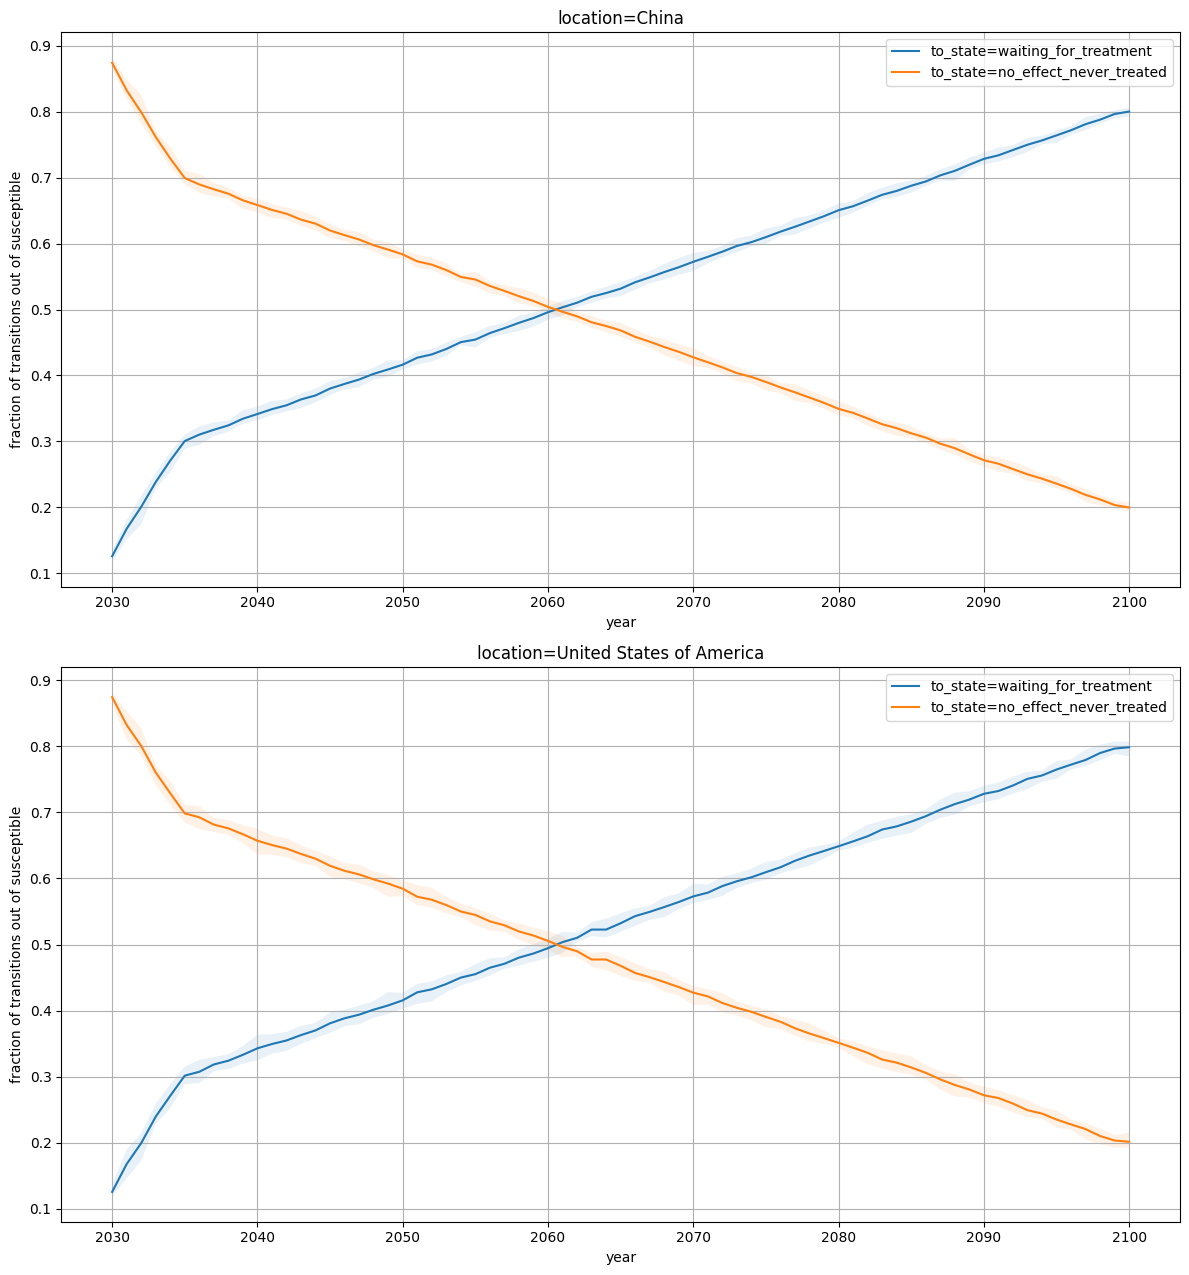

In [50]:
fig = plot_over_time_by_column_for_row_x_1(
    initiate_vs_not,
    'to_state',
    'location',
    ylabel='fraction of transitions out of susceptible',
)
for ax in fig.axes:
    # Looks like this is unnecessary after converting year to int
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)

# Check #2 (completes vs. discontinues treatment)

10% of transitions to Full treatment effect status are by simulants who
discontinue treatment

## Strategy using new `treatment_duration` dataframe

For each year, compute the fraction of simulants who complete 9 months
of treatment among those who complete more than 0 months of treatment.
This should be 90%. Moreover, in this same group, for each $k\in \{1, \dotsc, 8\}$, the
fraction of those who complete $k$ months of treatment should be 10/8 =
1.25%.

Out of the total, the fraction of simulants who complete more than 0
months of treatment should (maybe) be the treatment rate for the year.

## Looks ???

In [51]:
treatment_duration = load_sim_output('treatment_duration')
treatment_duration

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2369995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2369996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2369997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2369998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2369999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw  \
0        treatment       cause        2022        236   
1        treatment       cause        2022        236   
2        treatment       cause        2022        236   
3        treatment       cause        2022        236   
4        treatment       cause        2022        236   
...            ...         ...         ...        ...   
2369995  treatment       cause        2100         63   
2369996  treatment       cause        2100         63   
2369997  treatment       cause        2100         63   
2369998  treatment       cause        2100         63   
2369999  treatment       cause        2100         63   

                          measure                    scenario     sex  \
0        treatment_duration_count                    baseline  Female   
1        treatment_duration_count                    baseline  Female   
2        treatment_duration_count                    baseline  Female   
3        treatment_duration_count                    baseline  Female   
4        treatment_duration_count                    baseline  Female   
...                           ...                         ...     ...   
2369995  treatment_duration_count  bbbm_testing_and_treatment    Male   
2369996  treatment_duration_count  bbbm_testing_and_treatment    Male   
2369997  treatment_duration_count  bbbm_testing_and_treatment    Male   
2369998  treatment_duration_count  bbbm_testing_and_treatment    Male   
2369999  treatment_duration_count  bbbm_testing_and_treatment    Male   

        sub_entity  value                  location  
0                0    0.0  United States of America  
1                1    0.0  United States of America  
2                2    0.0  United States of America  
3                3    0.0  United States of America  
4                4    0.0  United States of America  
...            ...    ...                       ...  
2369995          5    0.0                     China  
2369996          6    0.0                     China  
2369997          7    0.0                     China  
2369998          8    0.0                     China  
2369999          9    0.0                     China  

[2370000 rows x 12 columns]

In [52]:
treatment_duration.scenario.unique()

['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

In [53]:
assert set(treatment_duration.query("value > 0").scenario.unique()) == {'bbbm_testing_and_treatment'}, \
    "Treatments occurring in wrong scenarios"

In [54]:
assert set(treatment_duration.query("value > 0").age_group.unique()) \
    == {'60_to_64', '65_to_69', '70_to_74', '75_to_79'}, \
        "Treatments occurring in wrong age groups"

In [55]:
# Compute fraction of treatments discontinued after k months, where k =
# 1, 2, 3, ..., 9
fraction_among_treated = ops.ratio(
    treatment_duration,
    treatment_duration,
    # Stratify by year so we can plot over time
    strata=['event_year'],
    # Stratify numerator by months of treatment; denominator will be the
    # sum of all those with more than 0 months
    numerator_broadcast=['sub_entity'],
    # Filter to those who got treatment
    prefilter_query="sub_entity > 0",
).rename(columns={'sub_entity': 'months_of_treatment'})
fraction_among_treated

event_year  input_draw                    scenario  \
0            2022           1                    baseline   
1            2022           1                    baseline   
2            2022           1                    baseline   
3            2022           1                    baseline   
4            2022           1                    baseline   
...           ...         ...                         ...   
71095        2100         249  bbbm_testing_and_treatment   
71096        2100         249  bbbm_testing_and_treatment   
71097        2100         249  bbbm_testing_and_treatment   
71098        2100         249  bbbm_testing_and_treatment   
71099        2100         249  bbbm_testing_and_treatment   

                       location months_of_treatment     value  \
0                         China                   1       NaN   
1                         China                   2       NaN   
2                         China                   3       NaN   
3                         China                   4       NaN   
4                         China                   5       NaN   
...                         ...                 ...       ...   
71095  United States of America                   5  0.024869   
71096  United States of America                   6  0.015707   
71097  United States of America                   7  0.015707   
71098  United States of America                   8  0.013089   
71099  United States of America                   9  0.887435   

              numerator_measure       denominator_measure  multiplier  
0      treatment_duration_count  treatment_duration_count           1  
1      treatment_duration_count  treatment_duration_count           1  
2      treatment_duration_count  treatment_duration_count           1  
3      treatment_duration_count  treatment_duration_count           1  
4      treatment_duration_count  treatment_duration_count           1  
...                         ...                       ...         ...  
71095  treatment_duration_count  treatment_duration_count           1  
71096  treatment_duration_count  treatment_duration_count           1  
71097  treatment_duration_count  treatment_duration_count           1  
71098  treatment_duration_count  treatment_duration_count           1  
71099  treatment_duration_count  treatment_duration_count           1  

[71100 rows x 9 columns]

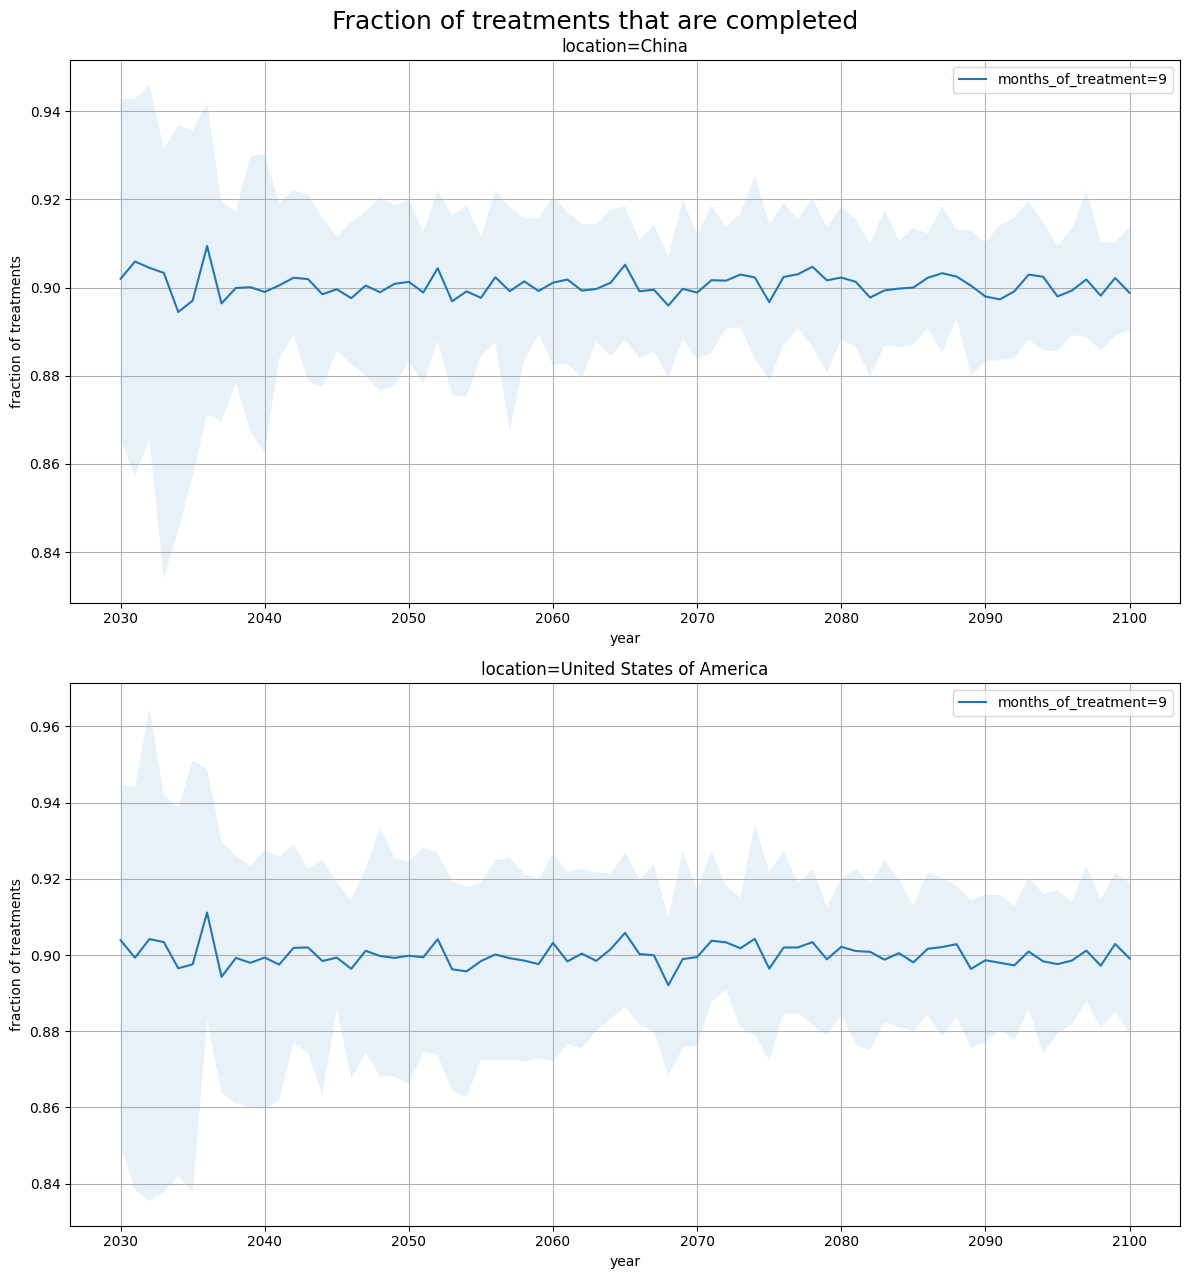

In [56]:
fig = plot_over_time_by_column_for_row_x_1(
    # Sub-entity is the number of months of treatment received
    fraction_among_treated.query("months_of_treatment == 9"),
    'months_of_treatment',
    'location',
    ylabel='fraction of treatments',
    suptitle='Fraction of treatments that are completed',
)
for ax in fig.axes:
    ax.grid(True)

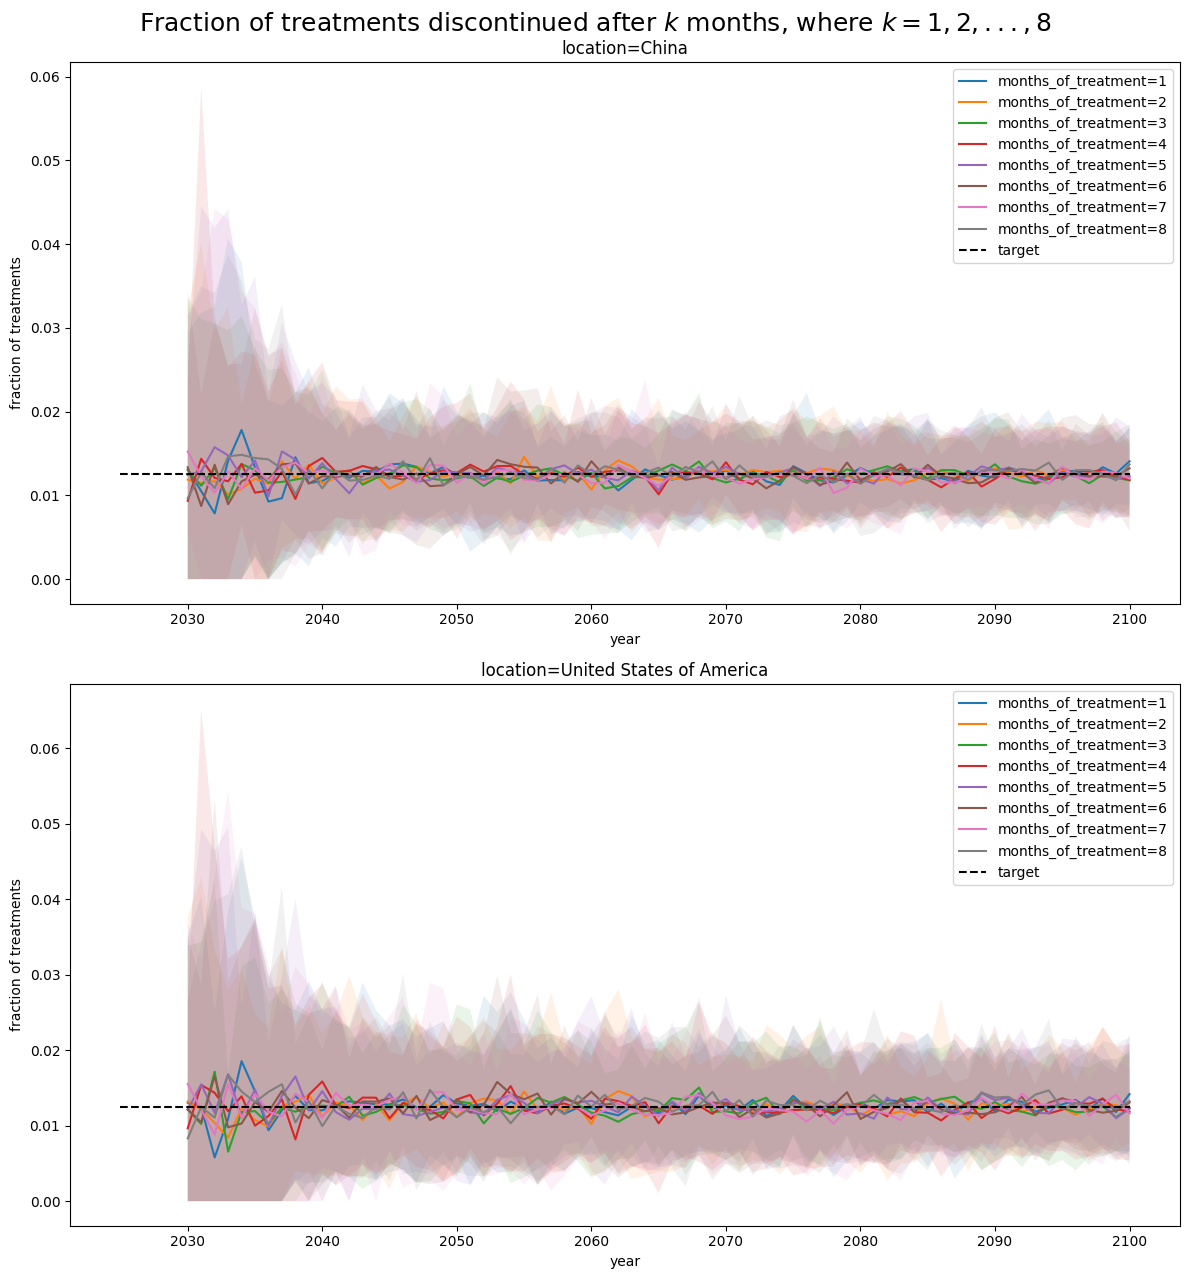

In [57]:
fig = plot_over_time_by_column_for_row_x_1(
    fraction_among_treated.query("months_of_treatment != 9"),
    'months_of_treatment',
    'location',
    ylabel='fraction of treatments',
    suptitle='Fraction of treatments discontinued after $k$ months, where $k=1, 2, ..., 8$',
)
for ax in fig.axes:
    ax.hlines(0.1/8, 2025, 2100, 'black', '--', label='target')
    ax.legend()

## Check fraction of people treated

In [58]:
treated_vs_not = ops.aggregate_categories(
    treatment_duration,
    'sub_entity',
    {'treated': range(1, 10), 'not_treated': 0},
)
treated_vs_not

age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
473995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type  event_year input_draw  \
0       treatment       cause        2022        236   
1       treatment       cause        2022        236   
2       treatment       cause        2022        236   
3       treatment       cause        2022        236   
4       treatment       cause        2022        236   
...           ...         ...         ...        ...   
473995  treatment       cause        2100         63   
473996  treatment       cause        2100         63   
473997  treatment       cause        2100         63   
473998  treatment       cause        2100         63   
473999  treatment       cause        2100         63   

                        location                   measure  \
0       United States of America  treatment_duration_count   
1       United States of America  treatment_duration_count   
2       United States of America  treatment_duration_count   
3       United States of America  treatment_duration_count   
4       United States of America  treatment_duration_count   
...                          ...                       ...   
473995                     China  treatment_duration_count   
473996                     China  treatment_duration_count   
473997                     China  treatment_duration_count   
473998                     China  treatment_duration_count   
473999                     China  treatment_duration_count   

                          scenario     sex   sub_entity  value  
0                         baseline  Female  not_treated    0.0  
1                         baseline  Female      treated    0.0  
2                         baseline    Male  not_treated    0.0  
3                         baseline    Male      treated    0.0  
4       bbbm_testing_and_treatment  Female  not_treated    0.0  
...                            ...     ...          ...    ...  
473995                    baseline    Male      treated    0.0  
473996  bbbm_testing_and_treatment  Female  not_treated    0.0  
473997  bbbm_testing_and_treatment  Female      treated    0.0  
473998  bbbm_testing_and_treatment    Male  not_treated    0.0  
473999  bbbm_testing_and_treatment    Male      treated    0.0  

[474000 rows x 12 columns]

In [59]:
fraction_treated = ops.ratio(
    treated_vs_not,
    treated_vs_not,
    strata=['event_year'],
    numerator_broadcast='sub_entity',
    prefilter_query=f"age_group in {testing_eligible_age_groups}",
)
fraction_treated


event_year  input_draw                    scenario  \
0            2022           1                    baseline   
1            2022           1                    baseline   
2            2022           1                    baseline   
3            2022           1                    baseline   
4            2022           1  bbbm_testing_and_treatment   
...           ...         ...                         ...   
15795        2100         249                    baseline   
15796        2100         249  bbbm_testing_and_treatment   
15797        2100         249  bbbm_testing_and_treatment   
15798        2100         249  bbbm_testing_and_treatment   
15799        2100         249  bbbm_testing_and_treatment   

                       location   sub_entity     value  \
0                         China  not_treated       NaN   
1                         China      treated       NaN   
2      United States of America  not_treated       NaN   
3      United States of America      treated       NaN   
4                         China  not_treated       NaN   
...                         ...          ...       ...   
15795  United States of America      treated       NaN   
15796                     China  not_treated  0.800589   
15797                     China      treated  0.199411   
15798  United States of America  not_treated  0.802482   
15799  United States of America      treated  0.197518   

              numerator_measure       denominator_measure  multiplier  
0      treatment_duration_count  treatment_duration_count           1  
1      treatment_duration_count  treatment_duration_count           1  
2      treatment_duration_count  treatment_duration_count           1  
3      treatment_duration_count  treatment_duration_count           1  
4      treatment_duration_count  treatment_duration_count           1  
...                         ...                       ...         ...  
15795  treatment_duration_count  treatment_duration_count           1  
15796  treatment_duration_count  treatment_duration_count           1  
15797  treatment_duration_count  treatment_duration_count           1  
15798  treatment_duration_count  treatment_duration_count           1  
15799  treatment_duration_count  treatment_duration_count           1  

[15800 rows x 9 columns]

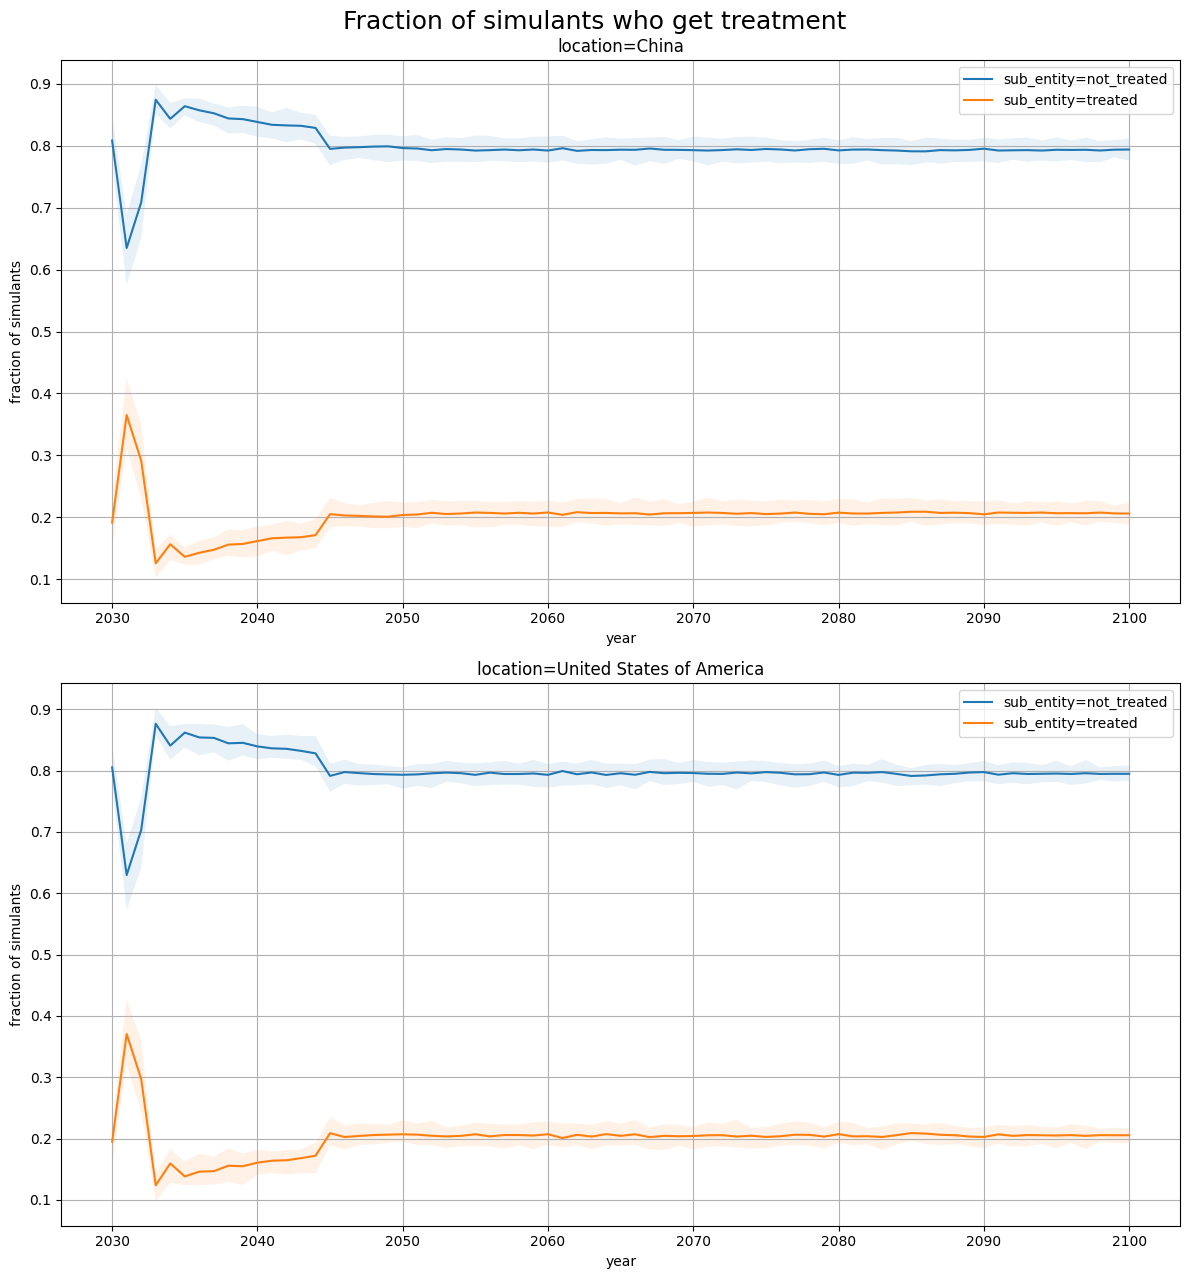

In [60]:
fig = plot_over_time_by_column_for_row_x_1(
    fraction_treated,
    'sub_entity',
    'location',
    ylabel='fraction of simulants',
    suptitle='Fraction of simulants who get treatment',
)
for ax in fig.axes:
    ax.grid(True)

In [61]:
treatment_duration.query("event_year>=2050").groupby('sub_entity')['value'].sum()

sub_entity
0    8788182.0
1      28629.0
2      28638.0
3      28457.0
4      28293.0
5      28646.0
6      28657.0
7      28093.0
8      28981.0
9    2062003.0
Name: value, dtype: float64

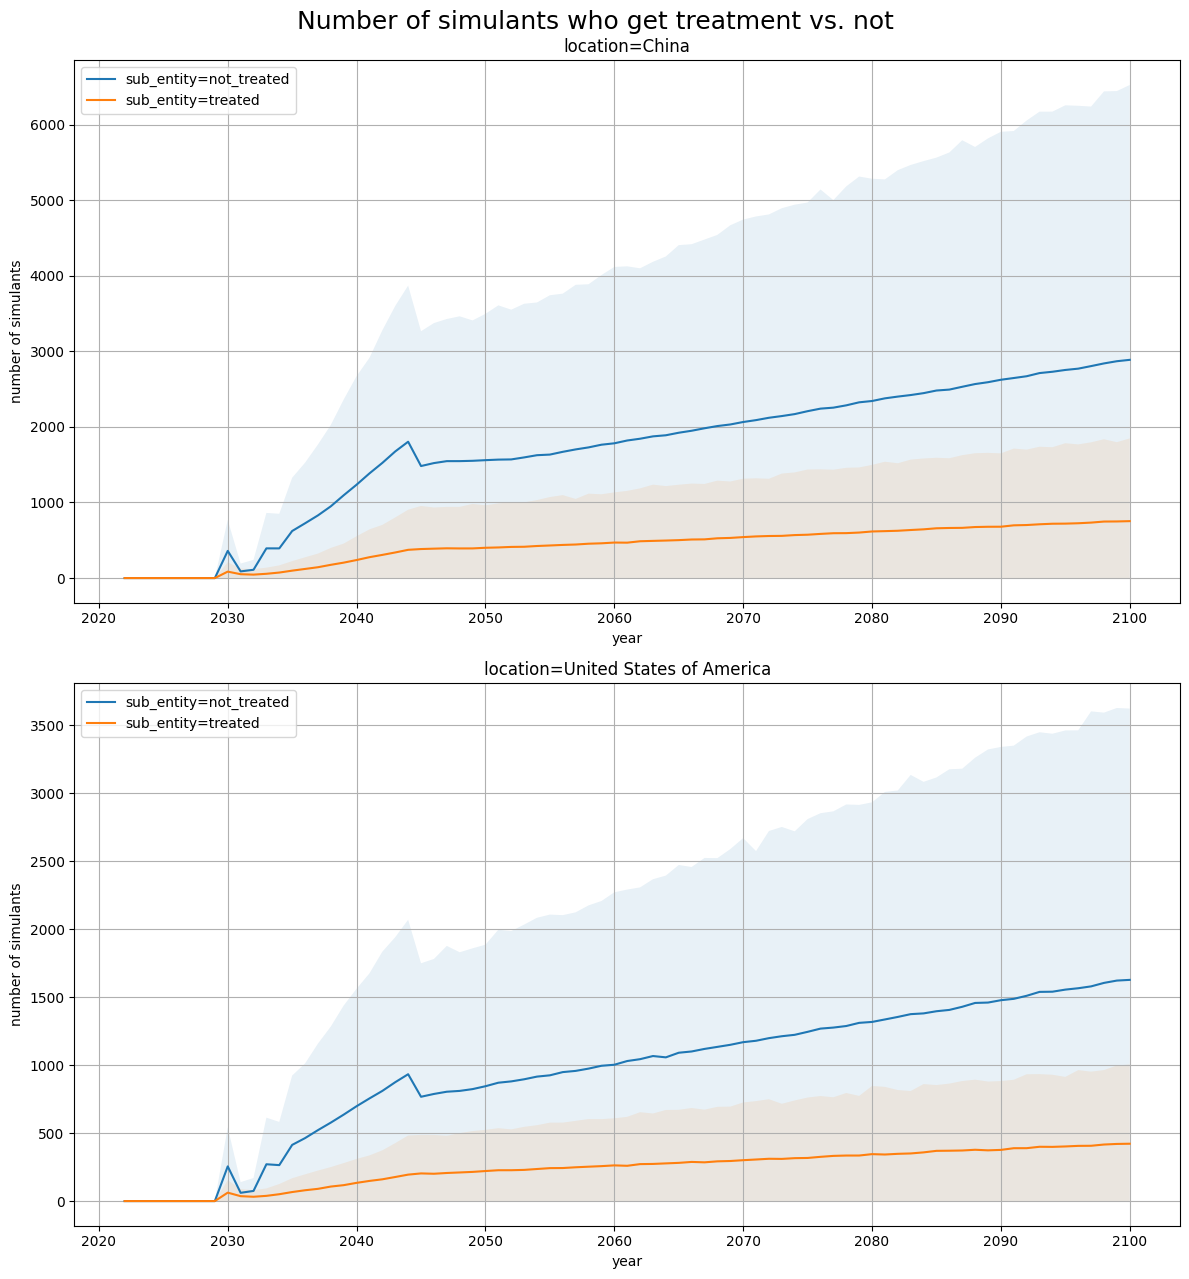

In [ ]:
fig = plot_over_time_by_column_for_row_x_1(
    ops.stratify(treated_vs_not, ['sub_entity', 'event_year']),
    ops.stratify(treatment_duration,)
    'sub_entity',
    'location',
    uncertainty=True,
    ylabel='number of simulants',
    suptitle='Number of simulants who get treatment vs. not',
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()

In [159]:
treatment_transitions.sub_entity.unique()

['waiting_for_treatment_to_treatment_effect', 'treatment_effect_to_waning_effect', 'waning_effect_to_no_effect_after_treatment', 'susceptible_to_treatment_to_waiting_for_treat..., 'susceptible_to_treatment_to_no_effect_never_t...]
Categories (5, object): ['susceptible_to_treatment_to_no_effect_never_t..., 'susceptible_to_treatment_to_waiting_for_treat..., 'treatment_effect_to_waning_effect', 'waiting_for_treatment_to_treatment_effect', 'waning_effect_to_no_effect_after_treatment']

In [154]:
treatment_transitions.value_counts(['from_state', 'to_state'])

from_state                to_state                 
susceptible_to_treatment  no_effect_never_treated      118500
                          waiting_for_treatment        118500
treatment_effect          waning_effect                118500
waiting_for_treatment     treatment_effect             118500
waning_effect             no_effect_after_treatment    118500
dtype: int64

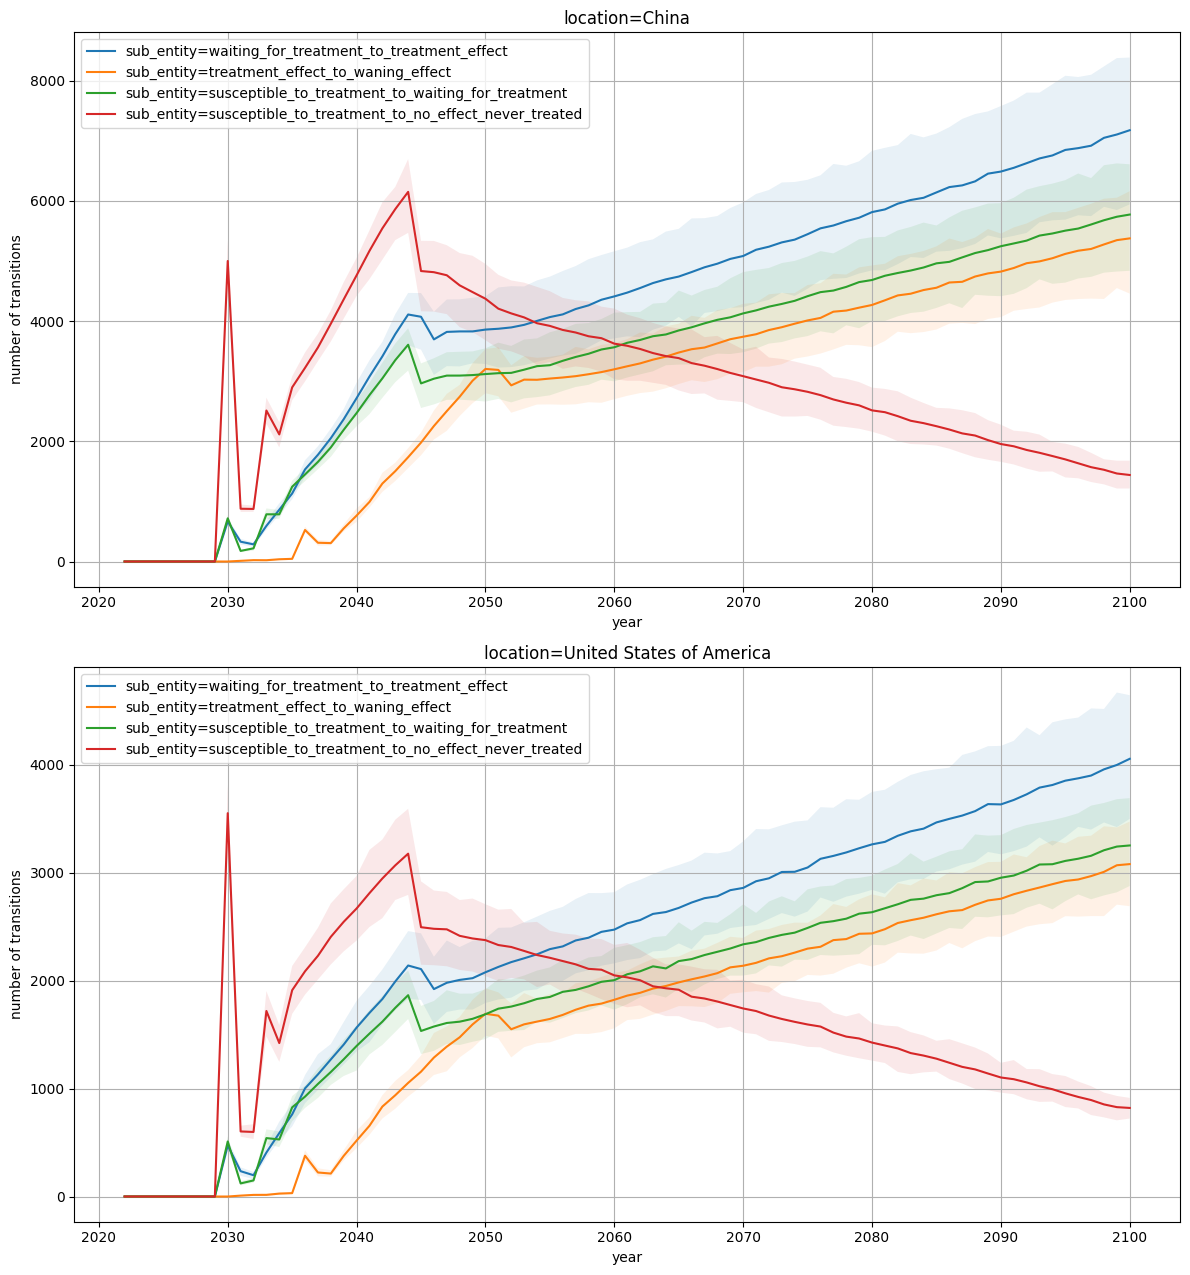

In [165]:
fig = plot_over_time_by_column_for_row_x_1(
    (
        treatment_transitions
        .query(
        # "sub_entity == 'susceptible_to_treatment_to_waiting_for_treatment'"
        "from_state in ['susceptible_to_treatment', 'waiting_for_treatment', 'treatment_effect']")
        .pipe(ops.stratify, ['sub_entity', 'event_year'])
    ),
    'sub_entity',
    'location',
    uncertainty=True,
    ylabel='number of transitions',
    # suptitle='Number of simulants who get treatment vs. not',
)
for ax in fig.axes:
    # ax.semilogy()
    ax.grid(True)

## Old version of Check #2

In [64]:
treatment_transitions.from_state.unique()

['waiting_for_treatment', 'treatment_effect', 'waning_effect', 'susceptible_to_treatment']
Categories (4, object): ['susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [65]:
# This gives the fraction of the total transitions out of
# 'waiting_for_treatment' that go to 'full_effect_long' vs.
# 'full_effect_short'. These ratios should be 0.9 and 0.1, respectively,
# across locations, age groups, draws, etc.
complete_vs_discontinue = ops.ratio(
    treatment_transitions,
    treatment_transitions,
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_vs_discontinue

input_draw                    scenario                  location  \
0         236  bbbm_testing_and_treatment                     China   
1         236  bbbm_testing_and_treatment  United States of America   
2         187  bbbm_testing_and_treatment                     China   
3         187  bbbm_testing_and_treatment  United States of America   
4         204  bbbm_testing_and_treatment                     China   
5         204  bbbm_testing_and_treatment  United States of America   
6         211  bbbm_testing_and_treatment                     China   
7         211  bbbm_testing_and_treatment  United States of America   
8         248  bbbm_testing_and_treatment                     China   
9         248  bbbm_testing_and_treatment  United States of America   
10         35  bbbm_testing_and_treatment                     China   
11         35  bbbm_testing_and_treatment  United States of America   
12         69  bbbm_testing_and_treatment                     China   
13         69  bbbm_testing_and_treatment  United States of America   
14        123  bbbm_testing_and_treatment                     China   
15        123  bbbm_testing_and_treatment  United States of America   
16          6  bbbm_testing_and_treatment                     China   
17          6  bbbm_testing_and_treatment  United States of America   
18        103  bbbm_testing_and_treatment                     China   
19        103  bbbm_testing_and_treatment  United States of America   
20        235  bbbm_testing_and_treatment                     China   
21        235  bbbm_testing_and_treatment  United States of America   
22         24  bbbm_testing_and_treatment                     China   
23         24  bbbm_testing_and_treatment  United States of America   
24        172  bbbm_testing_and_treatment                     China   
25        172  bbbm_testing_and_treatment  United States of America   
26        122  bbbm_testing_and_treatment                     China   
27        122  bbbm_testing_and_treatment  United States of America   
28         41  bbbm_testing_and_treatment                     China   
29         41  bbbm_testing_and_treatment  United States of America   
30         50  bbbm_testing_and_treatment                     China   
31         50  bbbm_testing_and_treatment  United States of America   
32        219  bbbm_testing_and_treatment                     China   
33        219  bbbm_testing_and_treatment  United States of America   
34          1  bbbm_testing_and_treatment                     China   
35          1  bbbm_testing_and_treatment  United States of America   
36        245  bbbm_testing_and_treatment                     China   
37        245  bbbm_testing_and_treatment  United States of America   
38        161  bbbm_testing_and_treatment                     China   
39        161  bbbm_testing_and_treatment  United States of America   
40        199  bbbm_testing_and_treatment                     China   
41        199  bbbm_testing_and_treatment  United States of America   
42        249  bbbm_testing_and_treatment                     China   
43        249  bbbm_testing_and_treatment  United States of America   
44        183  bbbm_testing_and_treatment                     China   
45        183  bbbm_testing_and_treatment  United States of America   
46          7  bbbm_testing_and_treatment                     China   
47          7  bbbm_testing_and_treatment  United States of America   
48         63  bbbm_testing_and_treatment                     China   
49         63  bbbm_testing_and_treatment  United States of America   

            to_state  value numerator_measure denominator_measure  multiplier  
0   treatment_effect    1.0  transition_count    transition_count           1  
1   treatment_effect    1.0  transition_count    transition_count           1  
2   treatment_effect    1.0  transition_count    transition_count           1  
3   treatment_effect    1.0  transition_count    transition_c

In [66]:
# Draw 2 in Japan: ratio of fraction of transitions to full_effect_long
# to fraction of transitions to full_effect short (rowss 0 and 1 above),
# gives the same value as the row for draw 2 in Japan in the table
# below:
# 8	2	bbbm_testing_and_treatment	Japan	8.956227	transition_count	transition_count	1
0.899560 / 0.100440

8.956192751891678

In [67]:
# This gives the ratio of the total transitions from start -> long to
# start -> short. The ratio should be approximately 9.0 for all
# locations, draws, age groups, etc. These ratios are equivalent to
# dividing the 'full_effect_long' rows in the previous dataframe by the
# 'full_effect_short' rows (see above cell for an example).
complete_to_discontinue_ratio = ops.ratio(
    treatment_transitions.query("to_state == 'full_effect_long'"),
    treatment_transitions.query("to_state == 'full_effect_short'"),
    strata=[],
    prefilter_query="from_state == 'waiting_for_treatment'",
    # numerator_broadcast=['to_state'],
    # denominator_broadcast=['to_state'],
)
complete_to_discontinue_ratio

Empty DataFrame
Columns: [input_draw, scenario, location, value, numerator_measure, denominator_measure, multiplier]
Index: []

In [68]:
# NOTE: ops.describe explicitly calculates uncertainty over
# ops.draw_col, so setting the draw column to 'random_seed' makes this
# work. Another option would be to allow passing in the "uncertainty"
# column instead of always assuming it's the input draw.
summarize_sim_data(complete_to_discontinue_ratio)

Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

In [69]:
summarize_sim_data(complete_vs_discontinue)

count  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                  
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect   25.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect   25.0   

                                                                                                                       mean  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                 
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect   1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect   1.0   

                                                                                                                       std  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  0.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  0.0   

                                                                                                                       min  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   

                                                                                                                       25%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   

                                                                                                                       50%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   

                                                                                                                       75%  \
denominator_measure location                 multiplier numerator_measure scenario                   to_state                
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0   

                                                                                                                       max  
denominator_measure location                 multiplier numerator_measure scenario                   to_state               
transition_count    China                    1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0  
                    United States of America 1          transition_count  bbbm_testing_and_treatment treatment_effect  1.0

# Check #3 (durations of full vs. waning treatment)

Full/Waning durations are accurate (use person-time ratios between
states?)

## Strategy

Look at ratio of person-time in each state to the person-time in the
`'waiting_for_treatment'` state. Using the fact that 90% of simulants complete
treatment and end up in the "long" states, while 10% of simulants
discontinue treatment and end up in the "short" states, we can predict
what these ratios should be.

## Results

Things look good except for the `'waning_effect_long'` state, whose
ratio to the `'waiting_for_treatment'` state looks too low (it's the same as
for the `'full_effect_long'` state).

In [70]:
all_tx_states = person_time_treatment.sub_entity.unique()
all_tx_states

['susceptible_to_treatment', 'waiting_for_treatment', 'treatment_effect', 'waning_effect', 'no_effect_after_treatment', 'no_effect_never_treated']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [71]:
no_effect_states = [state for state in all_tx_states if 'no_effect' in state]
no_effect_states

['no_effect_after_treatment', 'no_effect_never_treated']

In [72]:
# Compute ratio of person-time in each state to the person-time in the
# "waiting_for_treatment" state
tx_person_time_ratios = ops.ratio(
    person_time_treatment,
    person_time_treatment.query("sub_entity == 'waiting_for_treatment'"),
    strata=['event_year'],
    prefilter_query=(
        "scenario == 'bbbm_testing_and_treatment'"
        f" and event_year >= 2030" #" and age_group in {treatment_eligible_age_groups}"
        f" and sub_entity not in {no_effect_states + ['susceptible_to_treatment']}"
    ),
    numerator_broadcast=['sub_entity'],
)
tx_person_time_ratios

event_year  input_draw                    scenario  \
0            2030           1  bbbm_testing_and_treatment   
1            2030           1  bbbm_testing_and_treatment   
2            2030           1  bbbm_testing_and_treatment   
3            2030           1  bbbm_testing_and_treatment   
4            2030           1  bbbm_testing_and_treatment   
...           ...         ...                         ...   
10645        2100         249  bbbm_testing_and_treatment   
10646        2100         249  bbbm_testing_and_treatment   
10647        2100         249  bbbm_testing_and_treatment   
10648        2100         249  bbbm_testing_and_treatment   
10649        2100         249  bbbm_testing_and_treatment   

                       location             sub_entity     value  \
0                         China  waiting_for_treatment  1.000000   
1                         China       treatment_effect  0.000000   
2                         China          waning_effect  0.000000   
3      United States of America  waiting_for_treatment  1.000000   
4      United States of America       treatment_effect  0.000000   
...                         ...                    ...       ...   
10645                     China       treatment_effect  9.185154   
10646                     China          waning_effect  9.879481   
10647  United States of America  waiting_for_treatment  1.000000   
10648  United States of America       treatment_effect  9.021957   
10649  United States of America          waning_effect  9.390096   

      numerator_measure denominator_measure  multiplier  
0           person_time         person_time           1  
1           person_time         person_time           1  
2           person_time         person_time           1  
3           person_time         person_time           1  
4           person_time         person_time           1  
...                 ...                 ...         ...  
10645       person_time         person_time           1  
10646       person_time         person_time           1  
10647       person_time         person_time           1  
10648       person_time         person_time           1  
10649       person_time         person_time           1  

[10650 rows x 9 columns]

In [73]:
tx_state_durations = pd.DataFrame(
    {
        # Durations from state diagram in treatment documentation
        'duration': [0.5, 5.0, 0.5, 9.0, 2.5],
        # 90% of people complete treatment and get long treatment
        # effect, 10% discontinue and get short treatment effect 
        'population_fraction': [1, 0.9, 0.1, 0.9, 0.1],
    },
    index=pd.CategoricalIndex(
        ['waiting_for_treatment', 'full_effect_long', 'full_effect_short', 'waning_effect_long', 'waning_effect_short'],
        name='sub_entity',
    )
)
# Compute the ratio of the population-weighted duration of each state to
# the duration of the "start treatment" state.
tx_state_durations['target_person_time_ratio'] = (
    tx_state_durations['duration'] * tx_state_durations['population_fraction']
    / tx_state_durations.at['waiting_for_treatment', 'duration']
)
tx_state_durations


duration  population_fraction  target_person_time_ratio
sub_entity                                                                    
waiting_for_treatment       0.5                  1.0                       1.0
full_effect_long            5.0                  0.9                       9.0
full_effect_short           0.5                  0.1                       0.1
waning_effect_long          9.0                  0.9                      16.2
waning_effect_short         2.5                  0.1                       0.5

In [74]:
# For posting in Slack...
print(tx_state_durations.rename(
    columns={'population_fraction': 'pop_frac', 'target_person_time_ratio': 'pt_ratio'}))

                       duration  pop_frac  pt_ratio
sub_entity                                         
waiting_for_treatment       0.5       1.0       1.0
full_effect_long            5.0       0.9       9.0
full_effect_short           0.5       0.1       0.1
waning_effect_long          9.0       0.9      16.2
waning_effect_short         2.5       0.1       0.5


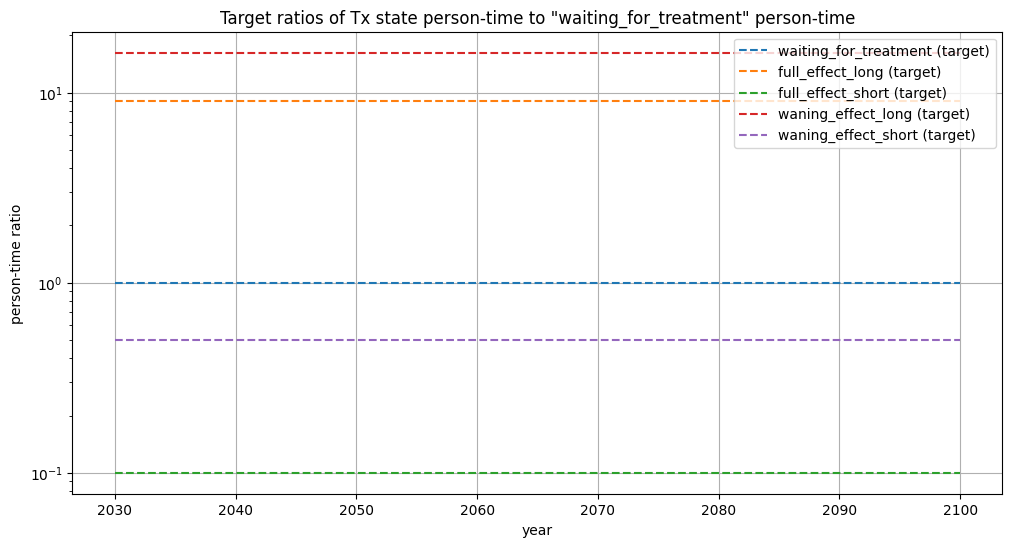

In [75]:
def plot_treatment_state_targets(tx_state_durations, column, ax):
    """Plot horizontal lines for values in one column of the treatment
    state durations table.
    """
    existing_lines = ax.get_lines()
    if len(existing_lines) == 0:
        # Axes.hlines plots all lines in a single color by default, so if you
        # want different colors, you have to explicitly cycle through them 
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']

    for i, state in enumerate(tx_state_durations.index):
        # Find color corresponding to state if there already exists a
        # line for that state
        for line in existing_lines:
            if state in line.get_label():
                color = line.get_color()
                break
        # If there were no existing lines, go to next color in cycle
        if len(existing_lines) == 0:
            color = colors[i % len(colors)]
        ax.hlines(tx_state_durations.at[state, column], 2030, 2100, color, '--', label=f'{state} (target)')
    return ax

fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target ratios of Tx state person-time to "waiting_for_treatment" person-time',
)
ax.grid(True)
ax.legend()
ax.semilogy()
plt.show()

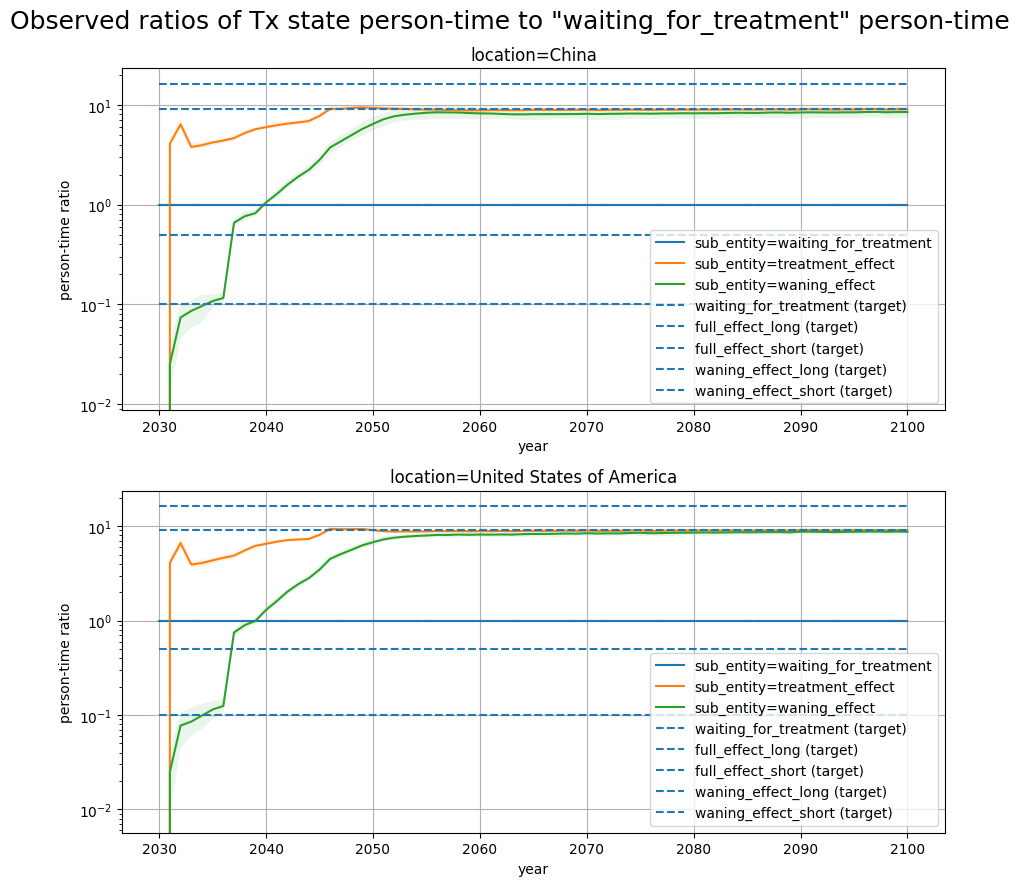

In [76]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_person_time_ratios,
    'sub_entity',
    'location',
    ylabel='person-time ratio',
    suptitle='Observed ratios of Tx state person-time to "waiting_for_treatment" person-time',
    axes_width=9,
    axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'target_person_time_ratio', ax)
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
    ax.legend()
    ax.semilogy()
plt.show()

In [77]:
tx_person_time_ratios.groupby(['event_year', 'sub_entity'])['value'].describe()

count      mean       std       min  \
event_year sub_entity                                                   
2030       treatment_effect        50.0  0.000000  0.000000  0.000000   
           waiting_for_treatment   50.0  1.000000  0.000000  1.000000   
           waning_effect           50.0  0.000000  0.000000  0.000000   
2031       treatment_effect        50.0  4.088411  0.332350  3.529851   
           waiting_for_treatment   50.0  1.000000  0.000000  1.000000   
...                                 ...       ...       ...       ...   
2099       waiting_for_treatment   50.0  1.000000  0.000000  1.000000   
           waning_effect           50.0  8.611126  0.548625  7.337122   
2100       treatment_effect        50.0  9.003086  0.138857  8.681134   
           waiting_for_treatment   50.0  1.000000  0.000000  1.000000   
           waning_effect           50.0  8.591596  0.512766  7.355486   

                                       25%       50%       75%        max  
event_year sub_entity                                                      
2030       treatment_effect       0.000000  0.000000  0.000000   0.000000  
           waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
           waning_effect          0.000000  0.000000  0.000000   0.000000  
2031       treatment_effect       3.816118  3.991116  4.213522   4.860987  
           waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
...                                    ...       ...       ...        ...  
2099       waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
           waning_effect          8.222352  8.676616  8.929278  10.212681  
2100       treatment_effect       8.901260  9.008210  9.116226   9.233241  
           waiting_for_treatment  1.000000  1.000000  1.000000   1.000000  
           waning_effect          8.350265  8.661540  8.928754   9.879481  

[213 rows x 8 columns]

## Check values

In [78]:
tx_person_time_ratios.query("sub_entity == 'waning_effect_long' and event_year>2060").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [79]:
tx_person_time_ratios.query("sub_entity == 'full_effect_long' and event_year>2060").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [80]:
# Compute implied durations from the ratios above
# Target durations are (9, 5)
12.576105 / .9 * .5, 8.641488 / .9 * .5

(6.986725, 4.800826666666667)

In [81]:
ops.index_cols

['input_draw', 'scenario', 'location']

## Look at actual person-time instead of the ratio

In [82]:
ops.describe(
    ops.stratify(
        person_time_treatment.query(
            "value > 0 and "
            "(sub_entity == 'waiting_for_treatment' or "
            " sub_entity.str.endswith('effect_long')) and event_year > 2050"
            # " and location == 'Spain'"
        ),
        ['event_year', 'sub_entity']
    )
)

count  \
event_year location                 scenario                   sub_entity                     
2051       China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
2052       China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
2053       China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
...                                                                                     ...   
2098       United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
2099       China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   
2100       China                    bbbm_testing_and_treatment waiting_for_treatment   25.0   
           United States of America bbbm_testing_and_treatment waiting_for_treatment   25.0   

                                                                                             mean  \
event_year location                 scenario                   sub_entity                           
2051       China                    bbbm_testing_and_treatment waiting_for_treatment  2166.998385   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  1190.192799   
2052       China                    bbbm_testing_and_treatment waiting_for_treatment  2181.329172   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  1215.705188   
2053       China                    bbbm_testing_and_treatment waiting_for_treatment  2206.363203   
...                                                                                           ...   
2098       United States of America bbbm_testing_and_treatment waiting_for_treatment  2219.498097   
2099       China                    bbbm_testing_and_treatment waiting_for_treatment  3975.786886   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  2235.961561   
2100       China                    bbbm_testing_and_treatment waiting_for_treatment  4020.612950   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  2271.080958   

                                                                                             std  \
event_year location                 scenario                   sub_entity                          
2051       China                    bbbm_testing_and_treatment waiting_for_treatment  215.569938   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  102.630274   
2052       China                    bbbm_testing_and_treatment waiting_for_treatment  221.679828   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  101.695724   
2053       China                    bbbm_testing_and_treatment waiting_for_treatment  215.215278   
...                                                                                          ...   
2098       United States of America bbbm_testing_and_treatment waiting_for_treatment  177.856213   
2099       China                    bbbm_testing_and_treatment waiting_for_treatment  427.390567   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  193.655186   
2100       China                    bbbm_testing_and_treatment waiting_for_treatment  411.150267   
           United States of America bbbm_testing_and_treatment waiting_for_treatment  181.103734   

                                                                                              min  \
event_year location                 scenario                   sub_entity                           
2051       China                 

In [83]:
9721.296427 / 1129.481287

8.606868071998433

In [84]:
13995.099904 / 1129.481287

12.390731980316554

# Check #4 (duration of start treatment/waiting for treatment)

“In treatment/waiting for treatment” duration is accurate (use
person-time ratios between states?)

This duration is supposed to be 6 months for all simulants.

## Strategy

To compute the average duration of each state, divide the total
person-time of that state by the number of simulants entering that
state, i.e., the the sum of transition counts where it's the `to_state`.

Alternatively, compute the average duration by dividing the total
person-time by the number of simulants *exiting* the state, i.e., the
sum of transition counts where it's the `from_state`.

## Results

I'm not sure how closely either of these strategies should match the
actual duration... Neither takes deaths into account, and I stratified
the calculations by year, which seems weird because some of the
durations are much longer than a year.

Nevertheless, the observed average durations for 4 out of 5 of the
states eventually converge to a value pretty close to the specified
duration, using either of the above two methods. The fifth state,
`'waning_effect_long'`, converges to different values in each of the
above two methods, neither of which is particularly close to the target
duration of 9 years. We think this is probably due to mortality.

In [85]:
person_time_treatment

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1421995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1421999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw      measure  \
0        treatment       cause        2022        236  person_time   
1        treatment       cause        2022        236  person_time   
2        treatment       cause        2022        236  person_time   
3        treatment       cause        2022        236  person_time   
4        treatment       cause        2022        236  person_time   
...            ...         ...         ...        ...          ...   
1421995  treatment       cause        2100         63  person_time   
1421996  treatment       cause        2100         63  person_time   
1421997  treatment       cause        2100         63  person_time   
1421998  treatment       cause        2100         63  person_time   
1421999  treatment       cause        2100         63  person_time   

                           scenario     sex                 sub_entity  \
0                          baseline  Female   susceptible_to_treatment   
1                          baseline  Female      waiting_for_treatment   
2                          baseline  Female           treatment_effect   
3                          baseline  Female              waning_effect   
4                          baseline  Female  no_effect_after_treatment   
...                             ...     ...                        ...   
1421995  bbbm_testing_and_treatment    Male      waiting_for_treatment   
1421996  bbbm_testing_and_treatment    Male           treatment_effect   
1421997  bbbm_testing_and_treatment    Male              waning_effect   
1421998  bbbm_testing_and_treatment    Male  no_effect_after_treatment   
1421999  bbbm_testing_and_treatment    Male    no_effect_never_treated   

             value                  location  
0         0.000000  United States of America  
1         0.000000  United States of America  
2         0.000000  United States of America  
3         0.000000  United States of America  
4         0.000000  United States of America  
...            ...                       ...  
1421995   0.000000                     China  
1421996   0.000000                     China  
1421997  16.941821                     China  
1421998  94.176591                     China  
1421999  40.361396                     China  

[1422000 rows x 12 columns]

In [86]:
treatment_transitions.query("value>0")

age_group                                      artifact_path  \
278500  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
278503  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
278504  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
278505  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
278508  60_to_64  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
592477   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592482   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592487   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592492   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
592497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

           entity entity_type event_year input_draw                  location  \
278500  treatment       cause       2030        236  United States of America   
278503  treatment       cause       2030        236  United States of America   
278504  treatment       cause       2030        236  United States of America   
278505  treatment       cause       2030        236  United States of America   
278508  treatment       cause       2030        236  United States of America   
...           ...         ...        ...        ...                       ...   
592477  treatment       cause       2100        183                     China   
592482  treatment       cause       2100          7                     China   
592487  treatment       cause       2100          7                     China   
592492  treatment       cause       2100         63                     China   
592497  treatment       cause       2100         63                     China   

                 measure                    scenario     sex  \
278500  transition_count  bbbm_testing_and_treatment  Female   
278503  transition_count  bbbm_testing_and_treatment  Female   
278504  transition_count  bbbm_testing_and_treatment  Female   
278505  transition_count  bbbm_testing_and_treatment    Male   
278508  transition_count  bbbm_testing_and_treatment    Male   
...                  ...                         ...     ...   
592477  transition_count  bbbm_testing_and_treatment    Male   
592482  transition_count  bbbm_testing_and_treatment  Female   
592487  transition_count  bbbm_testing_and_treatment    Male   
592492  transition_count  bbbm_testing_and_treatment  Female   
592497  transition_count  bbbm_testing_and_treatment    Male   

                                               sub_entity  value  \
278500          waiting_for_treatment_to_treatment_effect   28.0   
278503  susceptible_to_treatment_to_waiting_for_treatment   30.0   
278504  susceptible_to_treatment_to_no_effect_never_tr...  198.0   
278505          waiting_for_treatment_to_treatment_effect   11.0   
278508  susceptible_to_treatment_to_waiting_for_treatment   15.0   
...                                                   ...    ...   
592477         waning_effect_to_no_effect_after_treatment    8.0   
592482         waning_effect_to_no_effect_after_treatment   62.0   
592487         waning_effect_to_no_effect_after_treatment    6.0   
592492         waning_effect_to_no_effect_after_treatment   86.0   
592497         waning_effect_to_no_effect_after_treatment    5.0   

                      from_state                   to_state  
278500     waiting_for_treatment           treatment_effect  
278503  susceptible_to_treatment      waiting_for_treatment  
278504  susceptible_to_treatment    no_effect_never_treated  
278505     waiting_for_treatment           treatment_effect  
278508  susceptible_to_treatment      waiting_for_treatment  
...                          ...                        ...  
592477             waning_effect  no_effect_after_treatment  
592482             waning_effect  no_effect_after_treatment  
592487             waning_effect  no_

In [87]:
tx_state_mean_durations_incoming = ops.ratio(
    person_time_treatment.assign(to_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'to_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_incoming

event_year                   to_state  input_draw  \
0            2030  no_effect_after_treatment           1   
1            2030  no_effect_after_treatment           1   
2            2030  no_effect_after_treatment           6   
3            2030  no_effect_after_treatment           6   
4            2030  no_effect_after_treatment           7   
...           ...                        ...         ...   
21295        2100              waning_effect         245   
21296        2100              waning_effect         248   
21297        2100              waning_effect         248   
21298        2100              waning_effect         249   
21299        2100              waning_effect         249   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                     China       NaN   
1      bbbm_testing_and_treatment  United States of America       NaN   
2      bbbm_testing_and_treatment                     China       NaN   
3      bbbm_testing_and_treatment  United States of America       NaN   
4      bbbm_testing_and_treatment                     China       NaN   
...                           ...                       ...       ...   
21295  bbbm_testing_and_treatment  United States of America  6.480480   
21296  bbbm_testing_and_treatment                     China  6.145598   
21297  bbbm_testing_and_treatment  United States of America  6.319607   
21298  bbbm_testing_and_treatment                     China  6.843871   
21299  bbbm_testing_and_treatment  United States of America  6.712705   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
21295       person_time    transition_count           1  
21296       person_time    transition_count           1  
21297       person_time    transition_count           1  
21298       person_time    transition_count           1  
21299       person_time    transition_count           1  

[21300 rows x 9 columns]

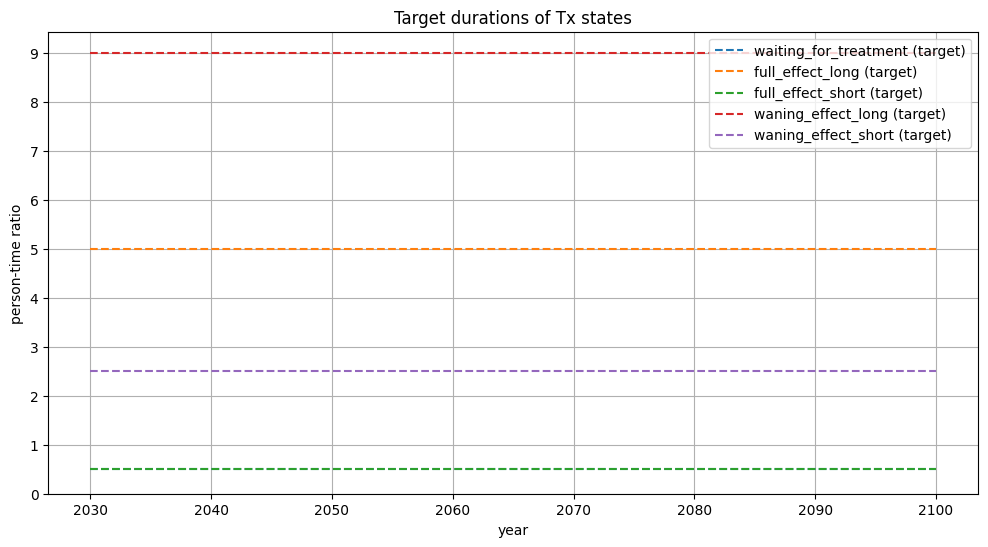

In [88]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
# ax.semilogy()
plt.show()

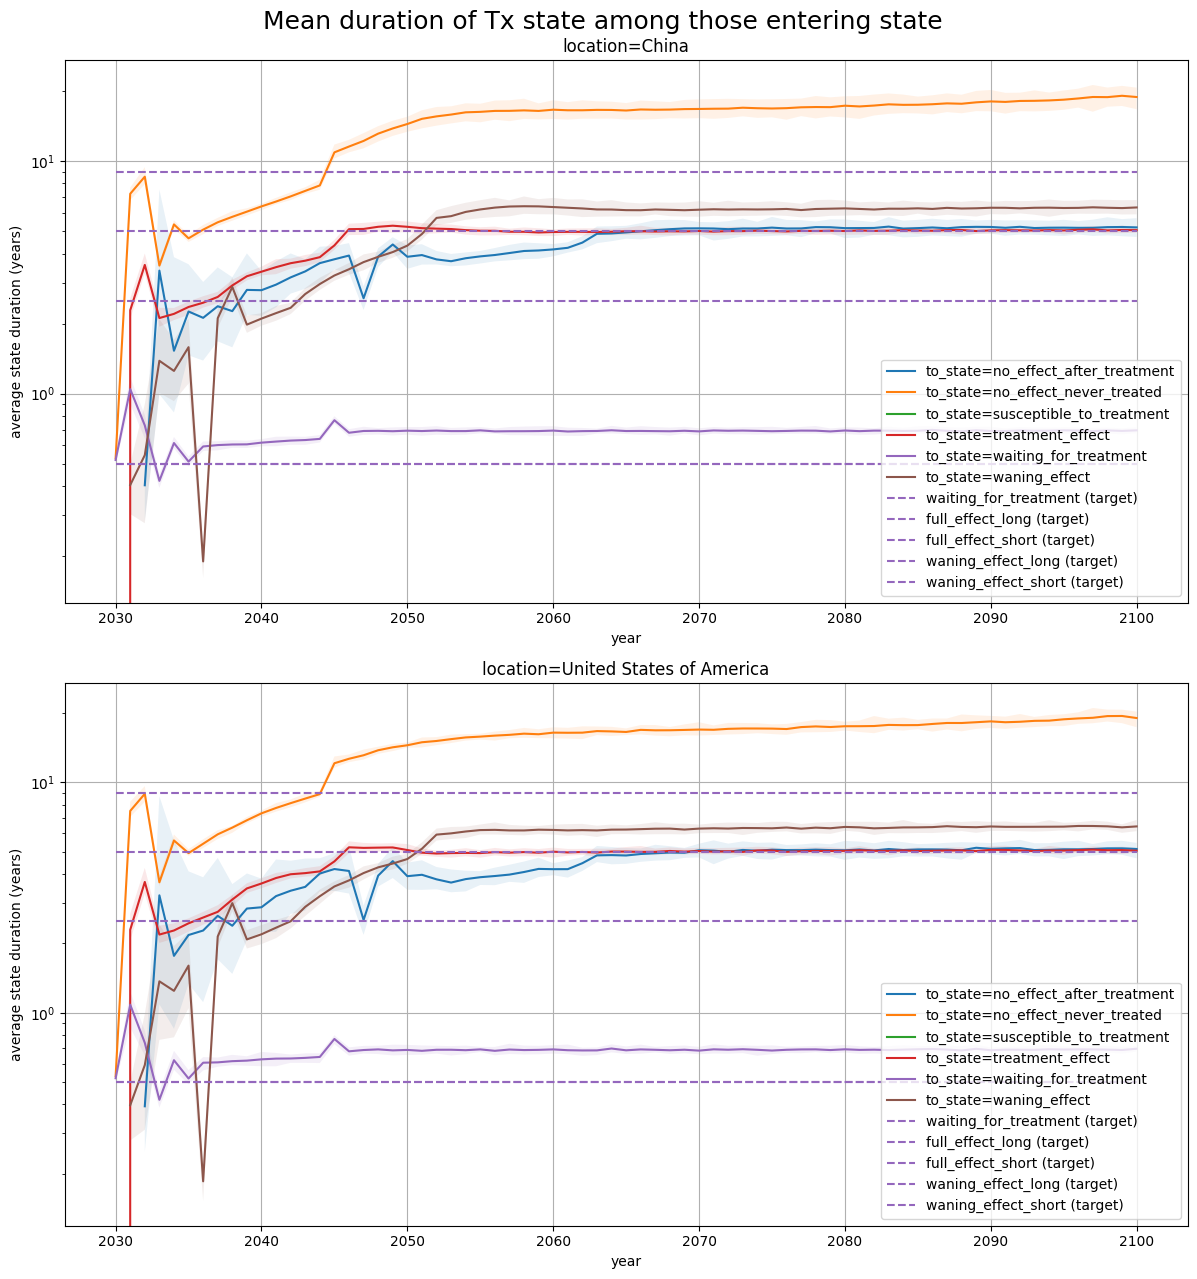

In [89]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_incoming,
    'to_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those entering state",
    # axes_width=9,
    # axes_height=4,
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

In [90]:
tx_state_mean_durations_outgoing = ops.ratio(
    person_time_treatment.assign(from_state=lambda df: df['sub_entity']),
    treatment_transitions.query("value>0"),
    strata=['event_year', 'from_state'],
    prefilter_query=(
        "scenario=='bbbm_testing_and_treatment' and event_year >= 2030"
    )
)
tx_state_mean_durations_outgoing

event_year                 from_state  input_draw  \
0            2030  no_effect_after_treatment           1   
1            2030  no_effect_after_treatment           1   
2            2030  no_effect_after_treatment           6   
3            2030  no_effect_after_treatment           6   
4            2030  no_effect_after_treatment           7   
...           ...                        ...         ...   
21295        2100              waning_effect         245   
21296        2100              waning_effect         248   
21297        2100              waning_effect         248   
21298        2100              waning_effect         249   
21299        2100              waning_effect         249   

                         scenario                  location      value  \
0      bbbm_testing_and_treatment                     China        NaN   
1      bbbm_testing_and_treatment  United States of America        NaN   
2      bbbm_testing_and_treatment                     China        NaN   
3      bbbm_testing_and_treatment  United States of America        NaN   
4      bbbm_testing_and_treatment                     China        NaN   
...                           ...                       ...        ...   
21295  bbbm_testing_and_treatment  United States of America  21.821596   
21296  bbbm_testing_and_treatment                     China  22.350697   
21297  bbbm_testing_and_treatment  United States of America  22.450404   
21298  bbbm_testing_and_treatment                     China  19.910507   
21299  bbbm_testing_and_treatment  United States of America  21.309269   

      numerator_measure denominator_measure  multiplier  
0           person_time    transition_count           1  
1           person_time    transition_count           1  
2           person_time    transition_count           1  
3           person_time    transition_count           1  
4           person_time    transition_count           1  
...                 ...                 ...         ...  
21295       person_time    transition_count           1  
21296       person_time    transition_count           1  
21297       person_time    transition_count           1  
21298       person_time    transition_count           1  
21299       person_time    transition_count           1  

[21300 rows x 9 columns]

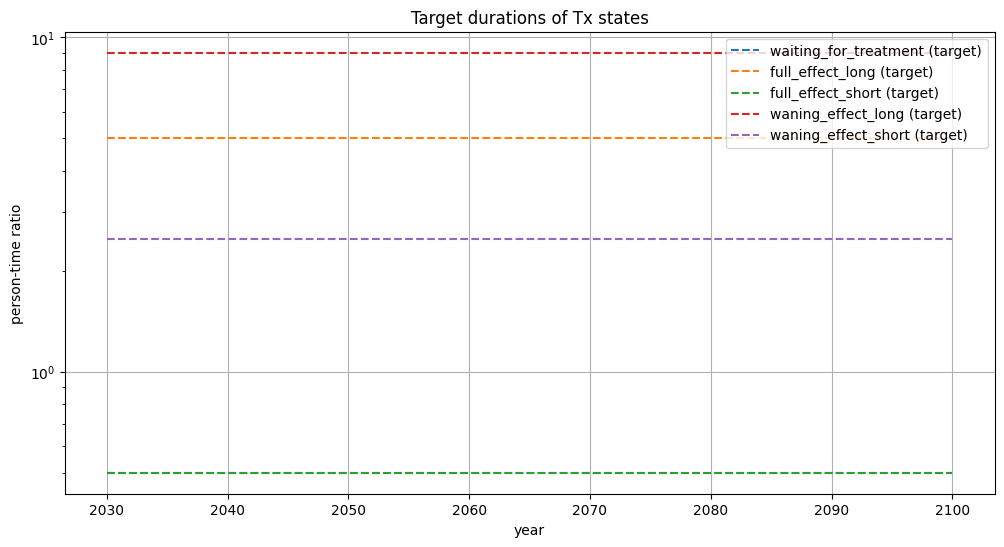

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
ax.set(
    xlabel='year',
    ylabel='person-time ratio',
    title='Target durations of Tx states',
)
ax.grid(True)
ax.legend()
ax.set(yticks=range(0,10))
ax.semilogy()
plt.show()

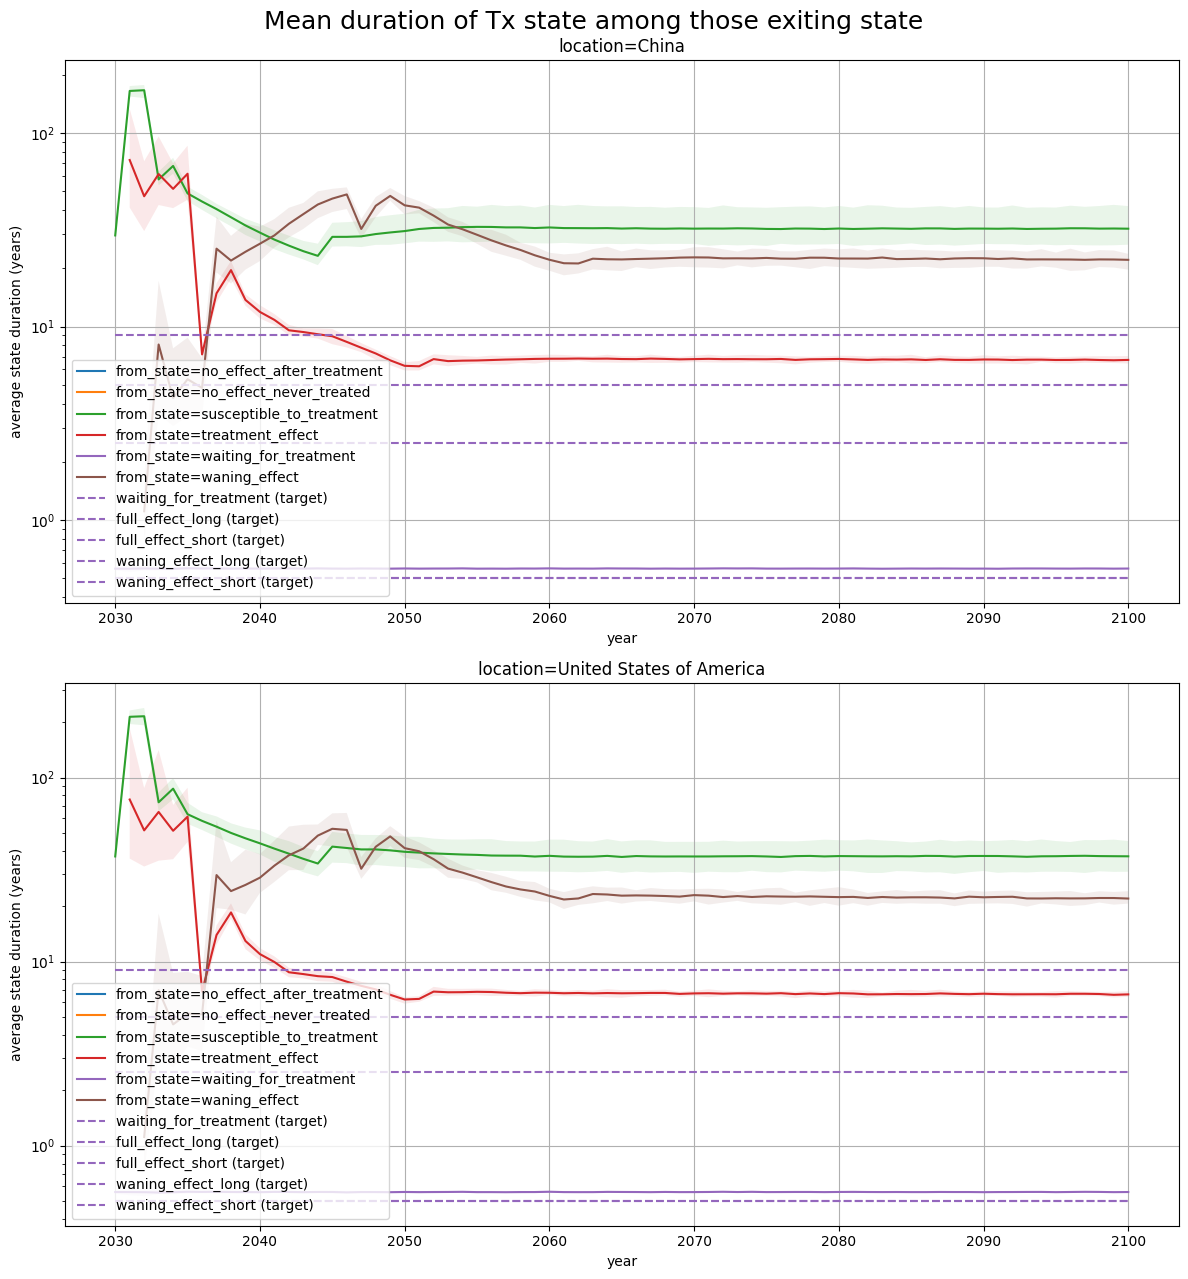

In [92]:
fig = plot_over_time_by_column_for_row_x_1(
    tx_state_mean_durations_outgoing,
    'from_state',
    'location',
    ylabel='average state duration (years)',
    suptitle="Mean duration of Tx state among those exiting state",
)
for ax in fig.axes:
    ax = plot_treatment_state_targets(tx_state_durations, 'duration', ax)
    ax.legend()
    ax.grid(True)
    ax.semilogy()
plt.show()

## Check value of `waning_effect_long`

It's not close to 9 years in either graph.

In [93]:
tx_state_mean_durations_incoming.query("to_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [94]:
tx_state_mean_durations_outgoing.query("from_state == 'waning_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

## By contrast, check the value of `full_effect_long`

It **is** close to 5 years in _both_ graphs.

In [95]:
tx_state_mean_durations_incoming.query("to_state == 'full_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

In [96]:
tx_state_mean_durations_outgoing.query("from_state == 'full_effect_long' and event_year > 2050").value.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: value, dtype: float64

# Check #5 (Interactive sim)

I'm planning to do the interactive sim in another notebook.

# Check #6 (hazard ratio)

Check hazard ratios for simulants who begin treatment and those who
transition to *No treatment effect* (Check hazard ratio of treated to
not treated for hazard rate from BBBM to MCI)

## I think I can't check this in the outputs because neither cause transitions nor cause state person-time is stratified by treatment status

In [97]:
person_time_cause_states = load_sim_output(
    'person_time_alzheimers_disease_and_other_dementias',
)
print_memory_usage(person_time_cause_states)
person_time_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])
89.591219 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
4265995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
4265999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
4265995  alzheimers_disease_and_other_dementias       cause        2100   
4265996  alzheimers_disease_and_other_dementias       cause        2100   
4265997  alzheimers_disease_and_other_dementias       cause        2100   
4265998  alzheimers_disease_and_other_dementias       cause        2100   
4265999  alzheimers_disease_and_other_dementias       cause        2100   

        input_draw      measure                    scenario     sex  \
0              236  person_time                    baseline  Female   
1              236  person_time                    baseline  Female   
2              236  person_time                    baseline  Female   
3              236  person_time                    baseline  Female   
4              236  person_time                    baseline  Female   
...            ...          ...                         ...     ...   
4265995         63  person_time  bbbm_testing_and_treatment    Male   
4265996         63  person_time  bbbm_testing_and_treatment    Male   
4265997         63  person_time  bbbm_testing_and_treatment    Male   
4265998         63  person_time  bbbm_testing_and_treatment    Male   
4265999         63  person_time  bbbm_testing_and_treatment    Male   

                                     sub_entity                  treatment  \
0        alzheimers_blood_based_biomarker_state   susceptible_to_treatment   
1        alzheimers_blood_based_biomarker_state      waiting_for_treatment   
2        alzheimers_blood_based_biomarker_state           treatment_effect   
3        alzheimers_blood_based_biomarker_state              waning_effect   
4        alzheimers_blood_based_biomarker_state  no_effect_after_treatment   
...                                         ...                        ...   
4265995                alzheimers_disease_state      waiting_for_treatment   
4265996                alzheimers_disease_state           treatment_effect   
4265997                alzheimers_disease_state              waning_effect   
4265998                alzheimers_disease_state  no_effect_after_treatment   
4265999                alzheimers_disease_state    no_effect_never_treated   

             value                  location  
0         0.000000  United States of America  
1         0.000000  United States of America  
2         0.000000  United States of America  
3         0.000000  United States of America  
4         0.000000  United States of America  
...            ...                       ...  
4265995   0.000000                     China  
4265996   0.000000                     China  
4265997   6.976044           

In [98]:
person_time_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year          int16
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
dtype: object

In [99]:
person_time_cause_states.treatment.unique()

['susceptible_to_treatment', 'waiting_for_treatment', 'treatment_effect', 'waning_effect', 'no_effect_after_treatment', 'no_effect_never_treated']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [100]:
person_time_cause_states.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state', 'alzheimers_disease_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [101]:
transition_count_cause_states = (
    load_sim_output(
        'transition_count_alzheimers_disease_and_other_dementias',
    )
    # Display memory usage of loaded dataframe before adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Add columns for from and to state
    .pipe(lambda df: df.join(
        cleaning.extract_transition_states(df, 'sub_entity'))
    )
    # Display memory usage of loaded dataframe after adding columns
    .pipe(lambda df: print_memory_usage(df) or df)
    # Convert the new columns to Categoricals
    .pipe(convert_to_categorical)
)
print_memory_usage(transition_count_cause_states)
transition_count_cause_states

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])
59.729217 MB
591.557217 MB
62.576543 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2843995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2843999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type event_year  \
0        alzheimers_disease_and_other_dementias       cause       2022   
1        alzheimers_disease_and_other_dementias       cause       2022   
2        alzheimers_disease_and_other_dementias       cause       2022   
3        alzheimers_disease_and_other_dementias       cause       2022   
4        alzheimers_disease_and_other_dementias       cause       2022   
...                                         ...         ...        ...   
2843995  alzheimers_disease_and_other_dementias       cause       2100   
2843996  alzheimers_disease_and_other_dementias       cause       2100   
2843997  alzheimers_disease_and_other_dementias       cause       2100   
2843998  alzheimers_disease_and_other_dementias       cause       2100   
2843999  alzheimers_disease_and_other_dementias       cause       2100   

        input_draw           measure                    scenario     sex  \
0              236  transition_count                    baseline  Female   
1              236  transition_count                    baseline  Female   
2              236  transition_count                    baseline  Female   
3              236  transition_count                    baseline  Female   
4              236  transition_count                    baseline  Female   
...            ...               ...                         ...     ...   
2843995         63  transition_count  bbbm_testing_and_treatment    Male   
2843996         63  transition_count  bbbm_testing_and_treatment    Male   
2843997         63  transition_count  bbbm_testing_and_treatment    Male   
2843998         63  transition_count  bbbm_testing_and_treatment    Male   
2843999         63  transition_count  bbbm_testing_and_treatment    Male   

                                                sub_entity  \
0        alzheimers_blood_based_biomarker_state_to_alzh...   
1        alzheimers_blood_based_biomarker_state_to_alzh...   
2        alzheimers_blood_based_biomarker_state_to_alzh...   
3        alzheimers_blood_based_biomarker_state_to_alzh...   
4        alzheimers_blood_based_biomarker_state_to_alzh...   
...                                                    ...   
2843995  alzheimers_mild_cognitive_impairment_state_to_...   
2843996  alzheimers_mild_cognitive_impairment_state_to_...   
2843997  alzheimers_mild_cognitive_impairment_state_to_...   
2843998  alzheimers_mild_cognitive_impairment_state_to_...   
2843999  alzheimers_mild_cognitive_impairment_state_to_...   

                         treatment  value                  location  \
0         susceptible_to_treatment    0.0  United States of America   
1            waiting_for_treatment    0.0  United States of America   
2                 treatment_effect    0.0  United States of America   
3                    waning_effect    0.0  United States of America   
4        no_effect_after_treatment    0.0  United States of America   
...                            ...    ...                       ...   
2843995      waiting_for_treatment    0.0                     China   
2843996           treatment_

In [102]:
transition_count_cause_states.dtypes

age_group        category
artifact_path    category
entity           category
entity_type      category
event_year       category
input_draw       category
measure          category
scenario         category
sex              category
sub_entity       category
treatment        category
value             float64
location         category
from_state       category
to_state         category
dtype: object

In [103]:
transition_count_cause_states.from_state.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (2, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_mild_cognitive_impairment_state']

In [104]:
incidence_rates_by_treatment = ops.ratio(
    transition_count_cause_states,
    person_time_cause_states.rename(columns={'sub_entity': 'from_state'}),
    strata=['event_year', 'from_state', 'treatment'],
    numerator_broadcast='to_state', # doesn't actually broadcast, just records it
    measure='transition_rate',
    dropna=True,
)
incidence_rates_by_treatment

event_year                                  from_state  \
0            2022      alzheimers_blood_based_biomarker_state   
1            2022      alzheimers_blood_based_biomarker_state   
2            2022      alzheimers_blood_based_biomarker_state   
3            2022      alzheimers_blood_based_biomarker_state   
4            2022      alzheimers_blood_based_biomarker_state   
...           ...                                         ...   
50776        2100  alzheimers_mild_cognitive_impairment_state   
50777        2100  alzheimers_mild_cognitive_impairment_state   
50778        2100  alzheimers_mild_cognitive_impairment_state   
50779        2100  alzheimers_mild_cognitive_impairment_state   
50780        2100  alzheimers_mild_cognitive_impairment_state   

                      treatment  input_draw                    scenario  \
0      susceptible_to_treatment           1                    baseline   
1      susceptible_to_treatment           1                    baseline   
2      susceptible_to_treatment           1  bbbm_testing_and_treatment   
3      susceptible_to_treatment           1  bbbm_testing_and_treatment   
4      susceptible_to_treatment           6                    baseline   
...                         ...         ...                         ...   
50776             waning_effect         245  bbbm_testing_and_treatment   
50777             waning_effect         248  bbbm_testing_and_treatment   
50778             waning_effect         248  bbbm_testing_and_treatment   
50779             waning_effect         249  bbbm_testing_and_treatment   
50780             waning_effect         249  bbbm_testing_and_treatment   

                       location                                    to_state  \
0                         China  alzheimers_mild_cognitive_impairment_state   
1      United States of America  alzheimers_mild_cognitive_impairment_state   
2                         China  alzheimers_mild_cognitive_impairment_state   
3      United States of America  alzheimers_mild_cognitive_impairment_state   
4                         China  alzheimers_mild_cognitive_impairment_state   
...                         ...                                         ...   
50776  United States of America                    alzheimers_disease_state   
50777                     China                    alzheimers_disease_state   
50778  United States of America                    alzheimers_disease_state   
50779                     China                    alzheimers_disease_state   
50780  United States of America                    alzheimers_disease_state   

          value          measure numerator_measure denominator_measure  \
0      0.141152  transition_rate  transition_count         person_time   
1      0.143119  transition_rate  transition_count         person_time   
2      0.141152  transition_rate  transition_count         person_time   
3      0.143119  transition_rate  transition_count         person_time   
4      0.141580  transition_rate  transition_count         person_time   
...         ...              ...               ...                 ...   
50776  0.270684  transition_rate  transition_count         person_time   
50777  0.268635  transition_rate  transition_count         person_time   
50778  0.263672  transition_rate  transition_count         person_time   
50779  0.262071  transition_rate  transition_count         person_time   
50780  0.258643  transition_rate  transition_count         person_time   

       multiplier  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
50776           1  
50777           1  
50778           1  
50779           1  
50780           1  

[50781 rows x 12 columns]

## Investigate infinite transition rates between disease states

My plotting code below initially failed with `FloatingPointError:
invalid value encountered in subtract` in the `lower` function, due to
infinities in the transition rates data.

According to the engineers, we may be getting 0 person-time in some
strata where counts are nonzero because person-time is recorded at the
beginning of a time step, while transition counts are recorded at the
end. So for example, if someone starts in preclinical, in the "waiting
for treatment" state, then transitions to MCI and to "full effect long"
on the same time step, then they would have their person-time recorded
in the (preclinical, waiting for treatment) stratum, but their disease
transition recorded in the (preclinical- > MCI, full effect long)
stratum.

The engineers said there was a bugfix in model 7.2 that *might* address
this problem, so I'll try this again there...

In [105]:
incidence_rates_by_treatment.value.describe()

count    5.078100e+04
mean              inf
std               NaN
min      0.000000e+00
25%      1.390611e-01
50%      1.688425e-01
75%      2.510242e-01
max               inf
Name: value, dtype: float64

In [106]:
inf = np.isinf(incidence_rates_by_treatment.value)
print(inf.sum(), "rows with infinite values")
incidence_rates_by_treatment.loc[inf]#.query("from_state=='alzheimers_blood_based_biomarker_state'")

58 rows with infinite values


event_year                                  from_state  \
1750        2030      alzheimers_blood_based_biomarker_state   
1751        2030      alzheimers_blood_based_biomarker_state   
1752        2030      alzheimers_blood_based_biomarker_state   
1753        2030      alzheimers_blood_based_biomarker_state   
1754        2030      alzheimers_blood_based_biomarker_state   
1755        2030      alzheimers_blood_based_biomarker_state   
1756        2030      alzheimers_blood_based_biomarker_state   
1757        2030      alzheimers_blood_based_biomarker_state   
1758        2030      alzheimers_blood_based_biomarker_state   
1759        2030      alzheimers_blood_based_biomarker_state   
1760        2030      alzheimers_blood_based_biomarker_state   
1761        2030      alzheimers_blood_based_biomarker_state   
1762        2030      alzheimers_blood_based_biomarker_state   
1763        2030      alzheimers_blood_based_biomarker_state   
1764        2030      alzheimers_blood_based_biomarker_state   
1765        2030      alzheimers_blood_based_biomarker_state   
1766        2030      alzheimers_blood_based_biomarker_state   
1767        2030      alzheimers_blood_based_biomarker_state   
1768        2030      alzheimers_blood_based_biomarker_state   
1769        2030      alzheimers_blood_based_biomarker_state   
1770        2030      alzheimers_blood_based_biomarker_state   
1771        2030      alzheimers_blood_based_biomarker_state   
1772        2030      alzheimers_blood_based_biomarker_state   
1773        2030      alzheimers_blood_based_biomarker_state   
1774        2030      alzheimers_blood_based_biomarker_state   
1775        2030      alzheimers_blood_based_biomarker_state   
1776        2030      alzheimers_blood_based_biomarker_state   
1777        2030      alzheimers_blood_based_biomarker_state   
1778        2030      alzheimers_blood_based_biomarker_state   
1779        2030      alzheimers_blood_based_biomarker_state   
1780        2030      alzheimers_blood_based_biomarker_state   
1781        2030      alzheimers_blood_based_biomarker_state   
1782        2030      alzheimers_blood_based_biomarker_state   
1783        2030      alzheimers_blood_based_biomarker_state   
1784        2030      alzheimers_blood_based_biomarker_state   
1785        2030      alzheimers_blood_based_biomarker_state   
1786        2030      alzheimers_blood_based_biomarker_state   
1787        2030      alzheimers_blood_based_biomarker_state   
1788        2030      alzheimers_blood_based_biomarker_state   
1789        2030      alzheimers_blood_based_biomarker_state   
1790        2030      alzheimers_blood_based_biomarker_state   
1791        2030      alzheimers_blood_based_biomarker_state   
1792        2030      alzheimers_blood_based_biomarker_state   
1793        2030      alzheimers_blood_based_biomarker_state   
1794        2030      alzheimers_blood_based_biomarker_state   
1795        2030      alzheimers_blood_based_biomarker_state   
1796        2030      alzheimers_blood_based_biomarker_state   
1797        2030      alzheimers_blood_based_biomarker_state   
1798        2030      alzheimers_blood_based_biomarker_state   
1799        2030      alzheimers_blood_based_biomarker_state   
2887        2032  alzheimers_mild_cognitive_impairment_state   
2900        2032  alzheimers_mild_cognitive_impairment_state   
2909        2032  alzheimers_mild_cognitive_impairment_state   
2910        2032  alzheimers_mild_cognitive_impairment_state   
3158        2032  alzheimers_mild_cognitive_impairment_state   
3159        2032  alzheimers_mild_cognitive_impairment_state   
3199        2032  alzheimers_mild_cognitive_impairment_state   
3200        2032  alzheimers_mild_cognitive_impairment_state   

                      treatment  input_draw                    scenario  \
1750           treatment_effect           1  bbbm_testing_and_treatment   
1751           treatment_effect           1  bbbm_testing_and_treatment   
1752

In [107]:
transition_count_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2044 and from_state=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==499 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, treatment, value, location, from_state, to_state]
Index: []

In [108]:
person_time_cause_states.query(
    "scenario=='bbbm_testing_and_treatment'"
    " and event_year==2030 and sub_entity=='alzheimers_blood_based_biomarker_state'"
    " and input_draw==2 and treatment=='full_effect_long'"
    " and age_group in @treatment_eligible_age_groups"
)

Empty DataFrame
Columns: [age_group, artifact_path, entity, entity_type, event_year, input_draw, measure, scenario, sex, sub_entity, treatment, value, location]
Index: []

## Plot disease transition rates stratified by treatment status, filtering out $\infty$

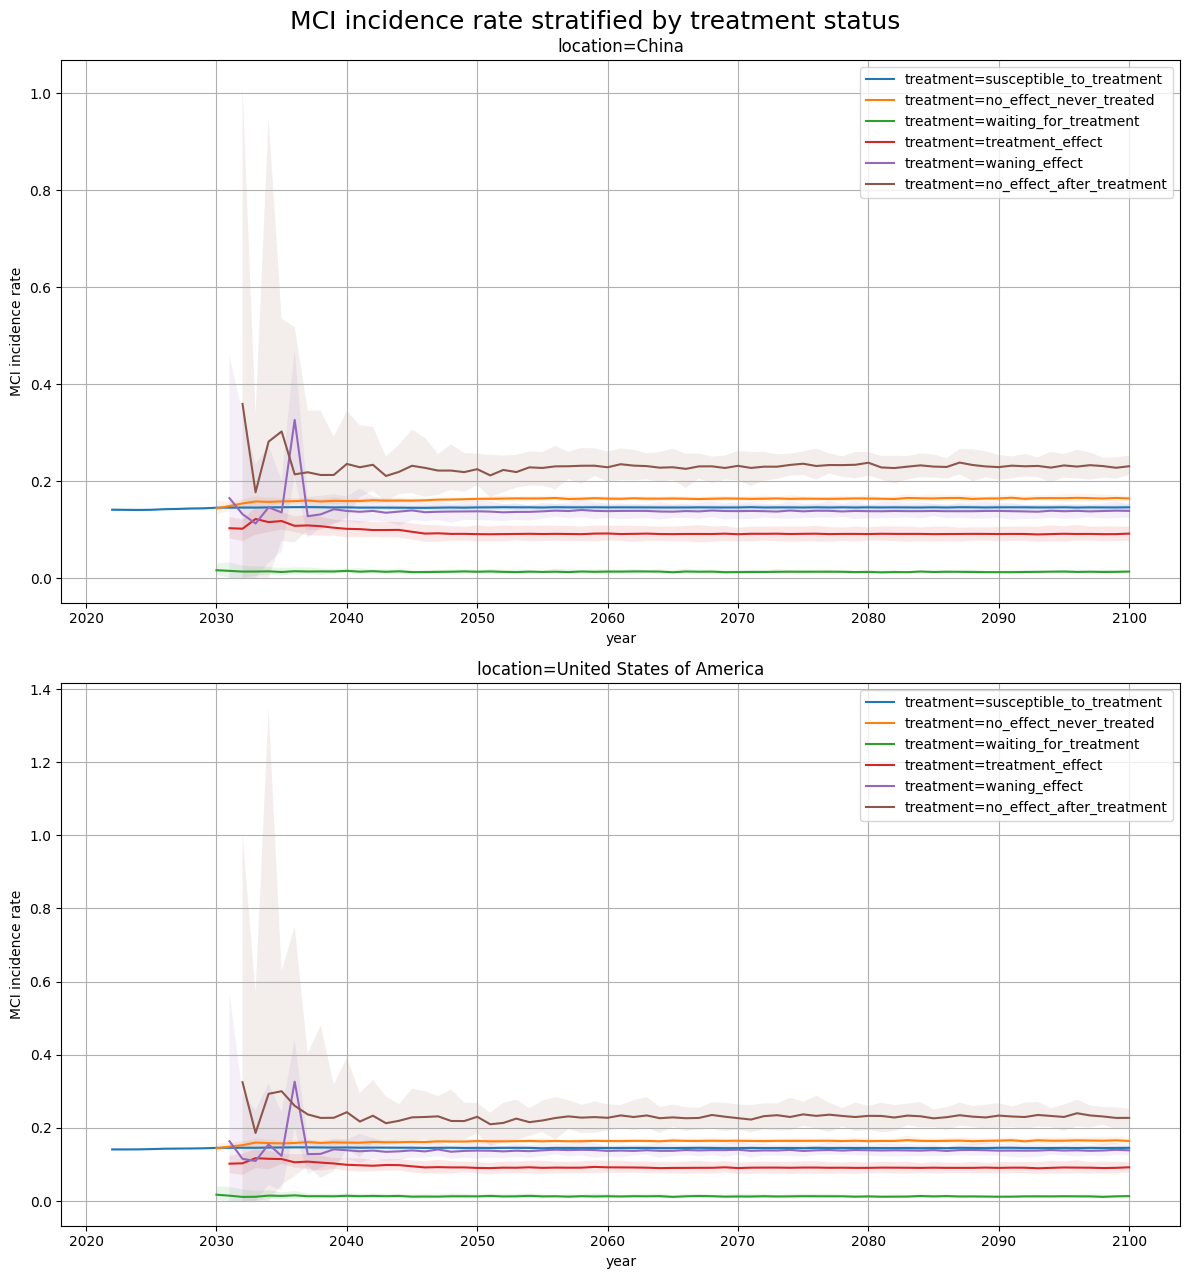

In [109]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_blood_based_biomarker_state'"),
    'treatment',
    'location',
    ylabel='MCI incidence rate',
    suptitle='MCI incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

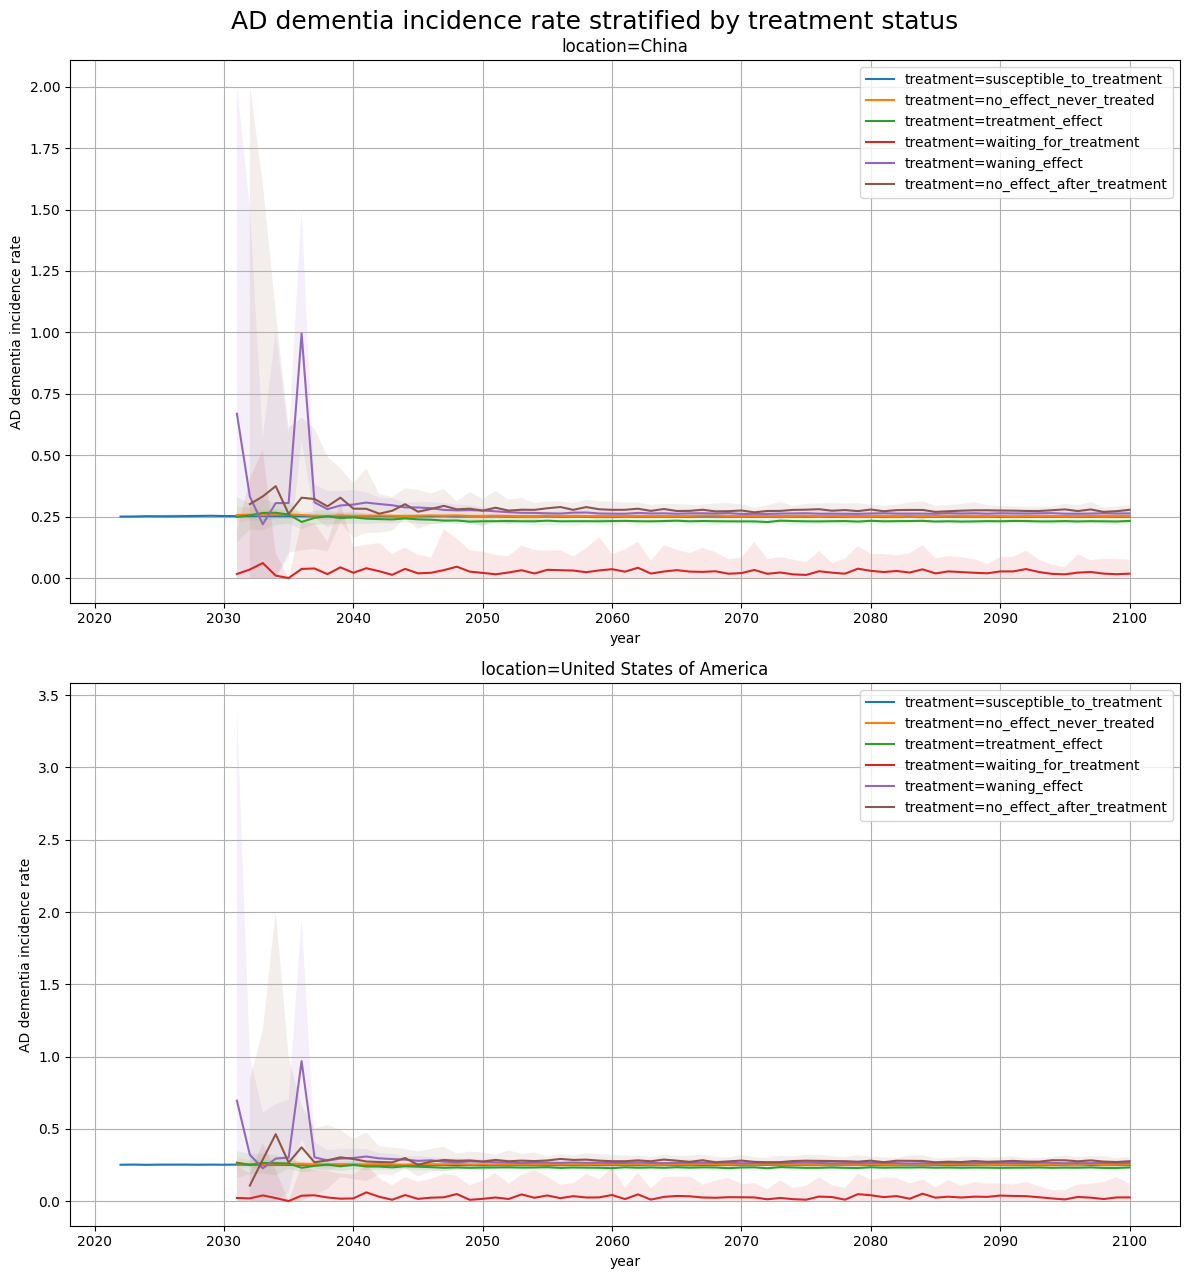

In [110]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    incidence_rates_by_treatment.loc[~inf].query("from_state=='alzheimers_mild_cognitive_impairment_state'"),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate',
    suptitle='AD dementia incidence rate stratified by treatment status',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

## Compute hazard ratio

In [111]:
hazard_ratio = ops.ratio(
    incidence_rates_by_treatment,
    incidence_rates_by_treatment.query("treatment=='susceptible_to_treatment'"),
    strata=['event_year', 'from_state'],
    numerator_broadcast=['treatment'],
    # prefilter_query="from_state=='alzheimers_blood_based_biomarker_state'",
)
hazard_ratio

event_year                                  from_state  input_draw  \
0            2022      alzheimers_blood_based_biomarker_state           1   
1            2022      alzheimers_blood_based_biomarker_state           1   
2            2022      alzheimers_blood_based_biomarker_state           1   
3            2022      alzheimers_blood_based_biomarker_state           1   
4            2022      alzheimers_blood_based_biomarker_state           6   
...           ...                                         ...         ...   
50776        2100  alzheimers_mild_cognitive_impairment_state         249   
50777        2100  alzheimers_mild_cognitive_impairment_state         249   
50778        2100  alzheimers_mild_cognitive_impairment_state         249   
50779        2100  alzheimers_mild_cognitive_impairment_state         249   
50780        2100  alzheimers_mild_cognitive_impairment_state         249   

                         scenario                  location  \
0                        baseline                     China   
1                        baseline  United States of America   
2      bbbm_testing_and_treatment                     China   
3      bbbm_testing_and_treatment  United States of America   
4                        baseline                     China   
...                           ...                       ...   
50776  bbbm_testing_and_treatment  United States of America   
50777  bbbm_testing_and_treatment  United States of America   
50778  bbbm_testing_and_treatment  United States of America   
50779  bbbm_testing_and_treatment  United States of America   
50780  bbbm_testing_and_treatment  United States of America   

                      treatment     value numerator_measure  \
0      susceptible_to_treatment  1.000000   transition_rate   
1      susceptible_to_treatment  1.000000   transition_rate   
2      susceptible_to_treatment  1.000000   transition_rate   
3      susceptible_to_treatment  1.000000   transition_rate   
4      susceptible_to_treatment  1.000000   transition_rate   
...                         ...       ...               ...   
50776   no_effect_never_treated  1.056894   transition_rate   
50777  susceptible_to_treatment  1.000000   transition_rate   
50778          treatment_effect  0.940510   transition_rate   
50779     waiting_for_treatment  0.321032   transition_rate   
50780             waning_effect  1.034354   transition_rate   

      denominator_measure  multiplier  
0         transition_rate           1  
1         transition_rate           1  
2         transition_rate           1  
3         transition_rate           1  
4         transition_rate           1  
...                   ...         ...  
50776     transition_rate           1  
50777     transition_rate           1  
50778     transition_rate           1  
50779     transition_rate           1  
50780     transition_rate           1  

[50781 rows x 10 columns]

In [112]:
hazard_ratio.value.describe()

count    5.078100e+04
mean              inf
std               NaN
min      0.000000e+00
25%      9.064528e-01
50%      1.000000e+00
75%      1.048279e+00
max               inf
Name: value, dtype: float64

In [113]:
inf_ratio = np.isinf(hazard_ratio.value)
print(inf_ratio.sum(), "rows with infinite values")

58 rows with infinite values


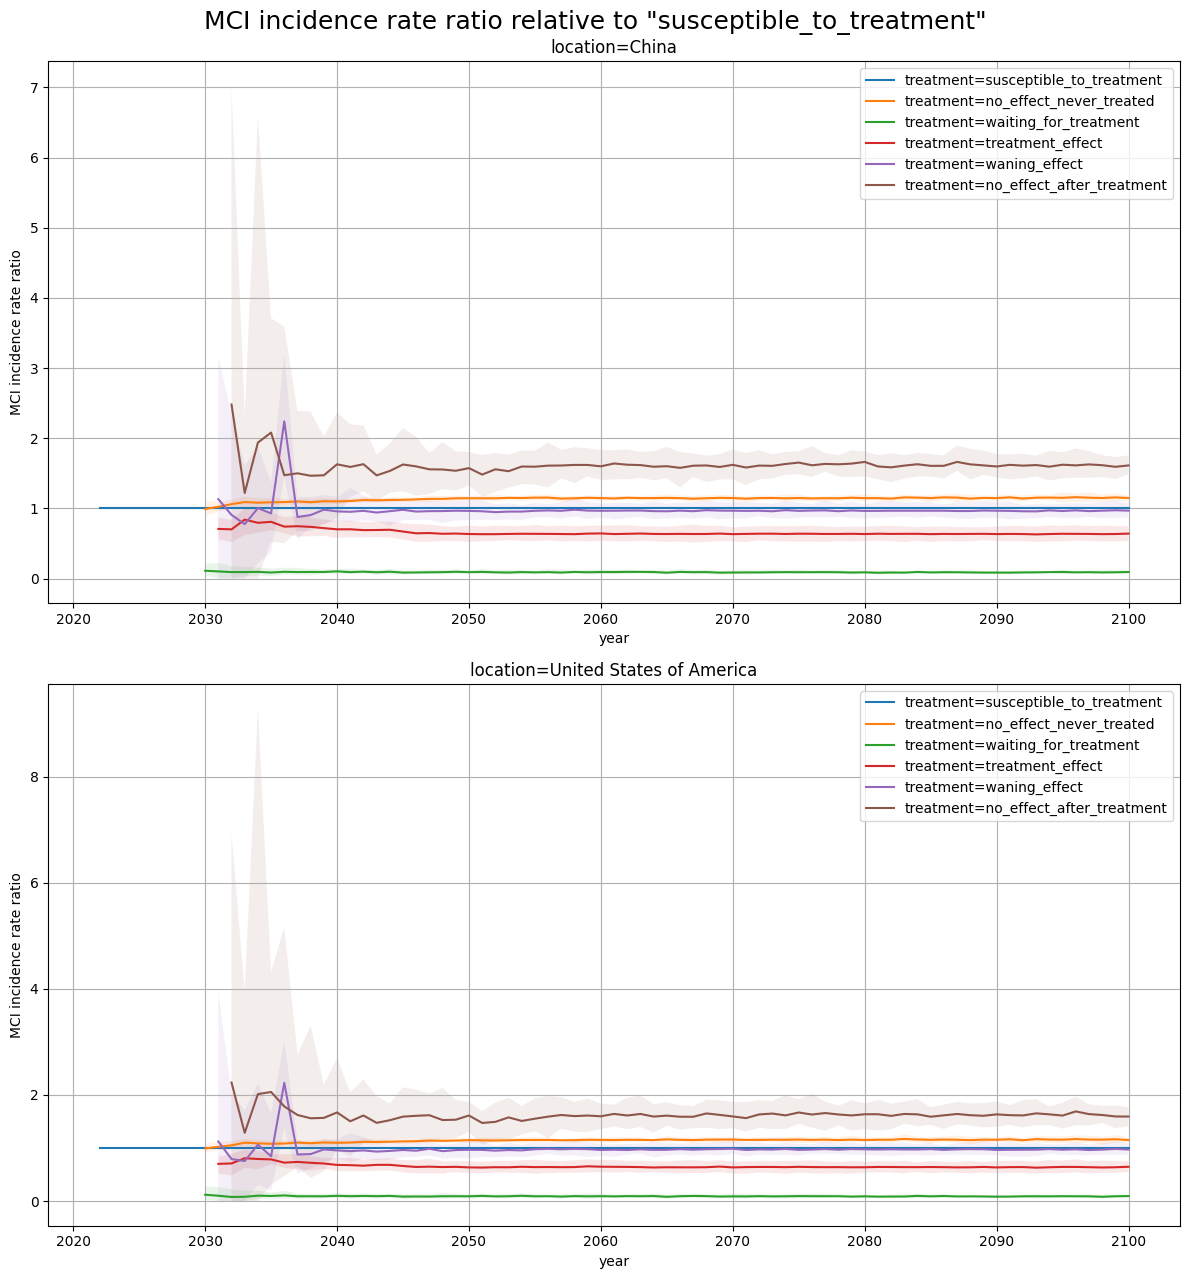

In [114]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment'"# and event_year > 2035"
        " and from_state=='alzheimers_blood_based_biomarker_state'"
        ),
    'treatment',
    'location',
    ylabel='MCI incidence rate ratio',
    suptitle='MCI incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

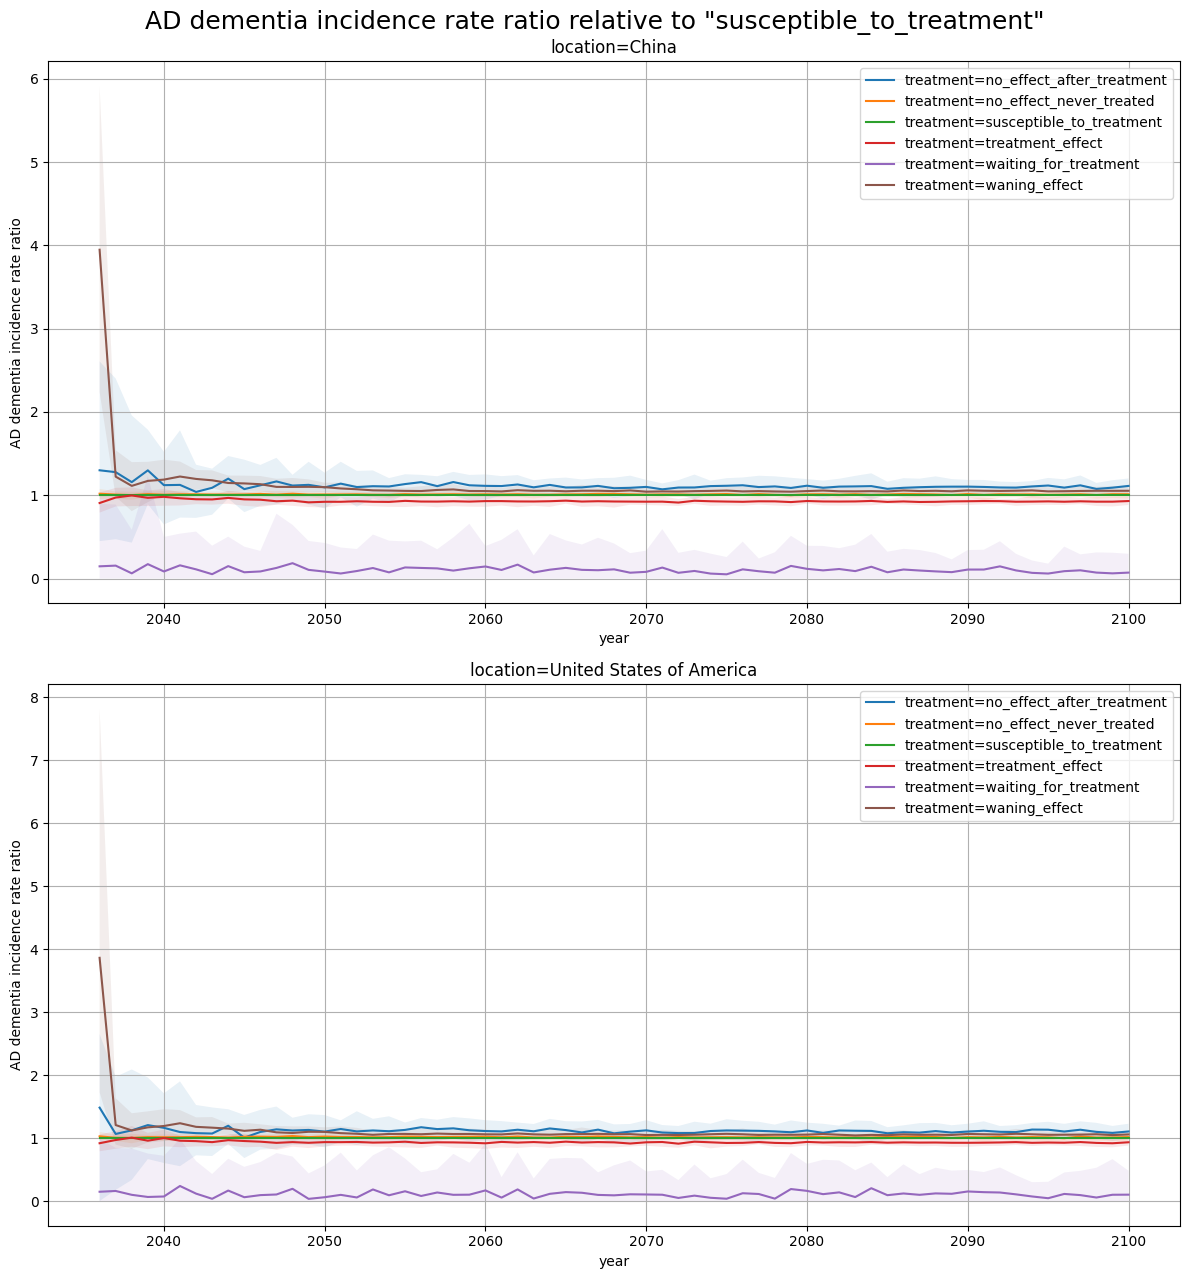

In [115]:
fig = plot_over_time_by_column_for_row_x_1(
    # NOTE: Without filtering infinities out, the `lower` method fails
    # with "FloatingPointError: invalid value encountered in subtract"
    hazard_ratio.loc[~inf_ratio].query(
        "scenario=='bbbm_testing_and_treatment' and event_year > 2035"
        " and from_state=='alzheimers_mild_cognitive_impairment_state'"
        ),
    'treatment',
    'location',
    ylabel='AD dementia incidence rate ratio',
    suptitle='AD dementia incidence rate ratio relative to "susceptible_to_treatment"',
    # uncertainty=False,
)
for ax in fig.axes:
    ax.grid(True)
    # ax.semilogy()
plt.show()

# Results!

# Load deaths and plot averted deaths by scenario

In [116]:
deaths = load_sim_output('deaths')
print_memory_usage(deaths)
deaths

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])
9.01025 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
473995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        236  deaths   
1       alzheimers_disease_state       cause        2022        236  deaths   
2       alzheimers_disease_state       cause        2022        236  deaths   
3       alzheimers_disease_state       cause        2022        236  deaths   
4       alzheimers_disease_state       cause        2022        187  deaths   
...                          ...         ...         ...        ...     ...   
473995              other_causes       cause        2100          7  deaths   
473996              other_causes       cause        2100         63  deaths   
473997              other_causes       cause        2100         63  deaths   
473998              other_causes       cause        2100         63  deaths   
473999              other_causes       cause        2100         63  deaths   

                          scenario     sex   value                  location  
0                         baseline  Female     0.0  United States of America  
1                         baseline    Male     0.0  United States of America  
2       bbbm_testing_and_treatment  Female     0.0  United States of America  
3       bbbm_testing_and_treatment    Male     0.0  United States of America  
4                         baseline  Female     0.0  United States of America  
...                            ...     ...     ...                       ...  
473995  bbbm_testing_and_treatment    Male   315.0                     China  
473996                    baseline  Female  3032.0                     China  
473997                    baseline    Male   317.0                     China  
473998  bbbm_testing_and_treatment  Female  3131.0                     China  
473999  bbbm_testing_and_treatment    Male   327.0                     China  

[474000 rows x 11 columns]

In [117]:
# NOTE: I had to rework some code in my vph_output.operators.difference
# function to prevent this code from converting Categoricals back to
# strings and making the memory explode...
averted_deaths = ops.averted(deaths, baseline_scenario='baseline')
print_memory_usage(averted_deaths)
# convert_dtypes(averted_deaths, colname_to_dtype=colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths)
# convert_to_categorical(averted_deaths, inplace=True)
# print_memory_usage(averted_deaths)
averted_deaths

9.01025 MB measure
6.403118 MB minuend
6.403118 MB subtrahend
4.273422 MB minuend re-indexed
4.273422 MB subtrahend re-indexed
4.273482 MB difference
5.92925 MB difference with reset index
6.166575 MB final difference
6.166575 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
236995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
236999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        236  deaths   
1       alzheimers_disease_state       cause        2022        236  deaths   
2       alzheimers_disease_state       cause        2022        187  deaths   
3       alzheimers_disease_state       cause        2022        187  deaths   
4       alzheimers_disease_state       cause        2022        204  deaths   
...                          ...         ...         ...        ...     ...   
236995              other_causes       cause        2100        183  deaths   
236996              other_causes       cause        2100          7  deaths   
236997              other_causes       cause        2100          7  deaths   
236998              other_causes       cause        2100         63  deaths   
236999              other_causes       cause        2100         63  deaths   

           sex                  location                    scenario  \
0       Female  United States of America  bbbm_testing_and_treatment   
1         Male  United States of America  bbbm_testing_and_treatment   
2       Female  United States of America  bbbm_testing_and_treatment   
3         Male  United States of America  bbbm_testing_and_treatment   
4       Female  United States of America  bbbm_testing_and_treatment   
...        ...                       ...                         ...   
236995    Male                     China  bbbm_testing_and_treatment   
236996  Female                     China  bbbm_testing_and_treatment   
236997    Male                     China  bbbm_testing_and_treatment   
236998  Female                     China  bbbm_testing_and_treatment   
236999    Male                     China  bbbm_testing_and_treatment   

       subtracted_from  value  
0             baseline    0.0  
1             baseline    0.0  
2             baseline    0.0  
3             baseline    0.0  
4             baseline    0.0  
...                ...    ...  
236995        baseline   -4.0  
236996        baseline  -65.0  
236997        baseline   -6.0  
236998        baseline  -99.0  
236999        baseline  -10.0  

[237000 rows x 12 columns]

In [118]:
averted_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237000 entries, 0 to 236999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   age_group        237000 non-null  category
 1   artifact_path    237000 non-null  category
 2   entity           237000 non-null  category
 3   entity_type      237000 non-null  category
 4   event_year       237000 non-null  int64   
 5   input_draw       237000 non-null  category
 6   measure          237000 non-null  category
 7   sex              237000 non-null  category
 8   location         237000 non-null  category
 9   scenario         237000 non-null  category
 10  subtracted_from  237000 non-null  category
 11  value            237000 non-null  float64 
dtypes: category(10), float64(1), int64(1)
memory usage: 5.9 MB


In [119]:
averted_deaths['scenario'].dtype.categories

Index(['baseline', 'bbbm_testing', 'bbbm_testing_and_treatment'], dtype='object')

In [120]:
averted_deaths.index.memory_usage(deep=True)

132

In [121]:
averted_deaths.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

In [122]:
averted_deaths.value.describe()

count    237000.000000
mean          0.650882
std          16.658031
min        -167.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         205.000000
Name: value, dtype: float64

In [123]:
# convert_dtypes(averted_deaths, colname_to_categorical_dtype, inplace=True)
# convert_to_categorical(averted_deaths, inplace=True)
print_memory_usage(averted_deaths)

6.166575 MB


In [124]:
# FIXME: Wait, to get percent deaths averted, do I want to be dividing
# by deaths in the intervention scenarios (like I do here), or should I
# be dividing by deaths in the *baseline* scenario? Probably the
# latter...
print_memory_usage(averted_deaths)
averted_deaths_pct = ops.ratio(
    averted_deaths,
    deaths.query("scenario != 'baseline'"),
    strata=['entity', 'age_group', 'event_year'],
    dropna=True, # Drop strata in younger age groups where we divided by 0
    multiplier=100,
)
print_memory_usage(averted_deaths_pct)
# convert_dtypes(averted_deaths_pct, colname_to_categorical_dtype, inplace=True)
# print_memory_usage(averted_deaths_pct)
# convert_to_categorical(averted_deaths_pct, inplace=True)
# print_memory_usage(averted_deaths_pct)
averted_deaths_pct

6.166575 MB
2.693929 MB


entity age_group  event_year input_draw  \
0      alzheimers_disease_state  40_to_44        2026        204   
1      alzheimers_disease_state  40_to_44        2026        204   
2      alzheimers_disease_state  40_to_44        2026        123   
3      alzheimers_disease_state  40_to_44        2026         50   
4      alzheimers_disease_state  40_to_44        2026         50   
...                         ...       ...         ...        ...   
86780              other_causes   95_plus        2100        183   
86781              other_causes   95_plus        2100          7   
86782              other_causes   95_plus        2100          7   
86783              other_causes   95_plus        2100         63   
86784              other_causes   95_plus        2100         63   

                         scenario                  location     value  \
0      bbbm_testing_and_treatment                     China  0.000000   
1      bbbm_testing_and_treatment  United States of America  0.000000   
2      bbbm_testing_and_treatment  United States of America  0.000000   
3      bbbm_testing_and_treatment                     China  0.000000   
4      bbbm_testing_and_treatment  United States of America  0.000000   
...                           ...                       ...       ...   
86780  bbbm_testing_and_treatment  United States of America -4.288165   
86781  bbbm_testing_and_treatment                     China -1.915295   
86782  bbbm_testing_and_treatment  United States of America -2.139800   
86783  bbbm_testing_and_treatment                     China -3.152111   
86784  bbbm_testing_and_treatment  United States of America -2.223191   

      numerator_measure denominator_measure  multiplier  
0                deaths              deaths         100  
1                deaths              deaths         100  
2                deaths              deaths         100  
3                deaths              deaths         100  
4                deaths              deaths         100  
...                 ...                 ...         ...  
86780            deaths              deaths         100  
86781            deaths              deaths         100  
86782            deaths              deaths         100  
86783            deaths              deaths         100  
86784            deaths              deaths         100  

[86785 rows x 10 columns]

In [125]:
averted_deaths_pct.memory_usage(deep=True)

Index                     132
entity                  87043
age_group               88315
event_year             694280
input_draw              87541
scenario                87110
location                87036
value                  694280
numerator_measure       86956
denominator_measure     86956
multiplier             694280
dtype: int64

In [126]:
ops.stratify(averted_deaths, 'event_year')

event_year input_draw                    scenario  \
0           2022        236  bbbm_testing_and_treatment   
1           2022        236  bbbm_testing_and_treatment   
2           2022        187  bbbm_testing_and_treatment   
3           2022        187  bbbm_testing_and_treatment   
4           2022        204  bbbm_testing_and_treatment   
...          ...        ...                         ...   
3945        2100        183  bbbm_testing_and_treatment   
3946        2100          7  bbbm_testing_and_treatment   
3947        2100          7  bbbm_testing_and_treatment   
3948        2100         63  bbbm_testing_and_treatment   
3949        2100         63  bbbm_testing_and_treatment   

                      location  value  
0                        China    0.0  
1     United States of America    0.0  
2                        China    0.0  
3     United States of America    0.0  
4                        China    0.0  
...                        ...    ...  
3945  United States of America   40.0  
3946                     China   91.0  
3947  United States of America   39.0  
3948                     China   86.0  
3949  United States of America   34.0  

[3950 rows x 5 columns]

In [127]:
# # FIXME: For some reason, this was taking a long time (>30 seconds before I interrupted it)
# averted_deaths_summary = summarize_sim_data(averted_deaths)
# averted_deaths_summary

In [128]:
def f(a=None, *args, **kwargs):
    print(a, args, kwargs)

f(1,2,3)
f(2)
f(5, b=4)
f(5, 6, b=7)
f(a=5, b=7)
f()

1 (2, 3) {}
2 () {}
5 () {'b': 4}
5 (6,) {'b': 7}
5 () {'b': 7}
None () {}


In [129]:
f(2)

2 () {}


# Draw results plots

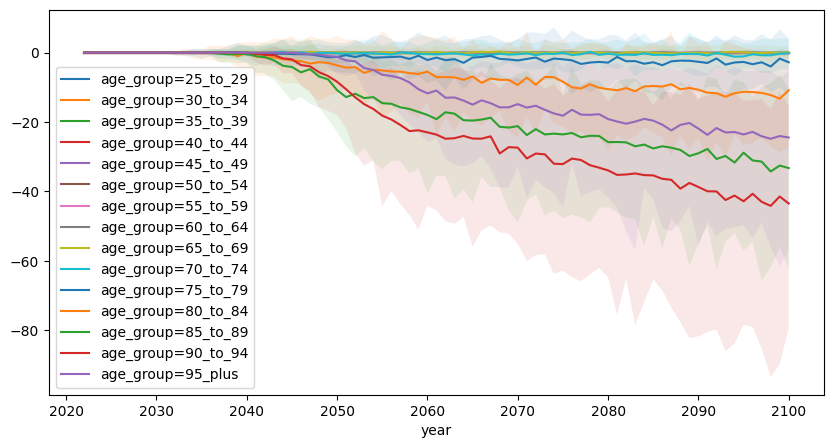

In [130]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(averted_deaths.query(
    "scenario == 'bbbm_testing_and_treatment' and entity == 'other_causes'"
    f" and location=={locations[0]!r}"
    ),
    'age_group'
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()


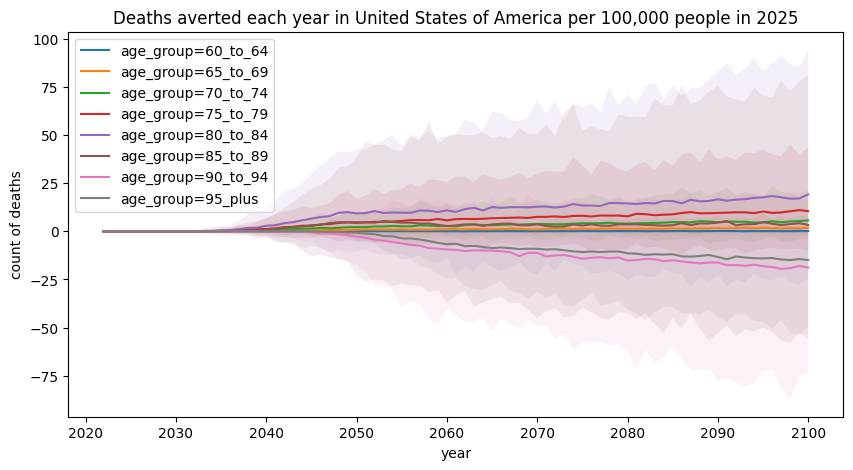

In [131]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="count of deaths",
    title=f"Deaths averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

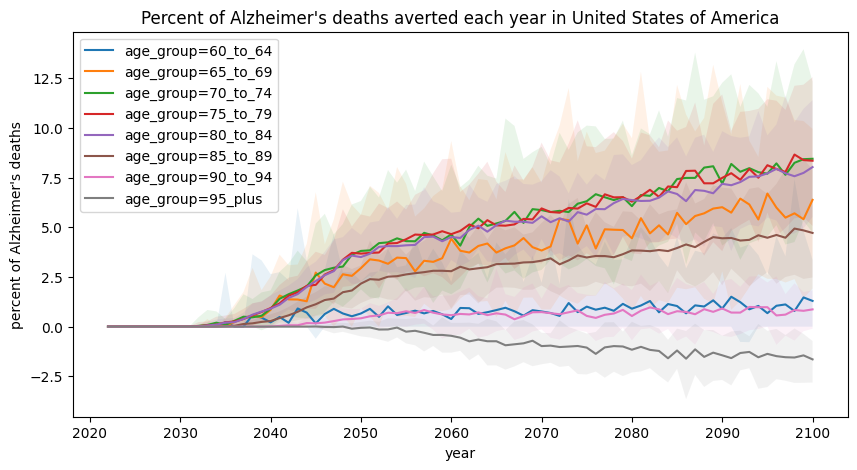

In [132]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="percent of Alzheimer's deaths",
    title=f"Percent of Alzheimer's deaths averted each year in {locations[0]}"
)
# ax.set_xticks(ax.get_xticks()[::10])
plt.show()

In [133]:
deaths.scenario.unique()

['baseline', 'bbbm_testing_and_treatment']
Categories (3, object): ['baseline' < 'bbbm_testing' < 'bbbm_testing_and_treatment']

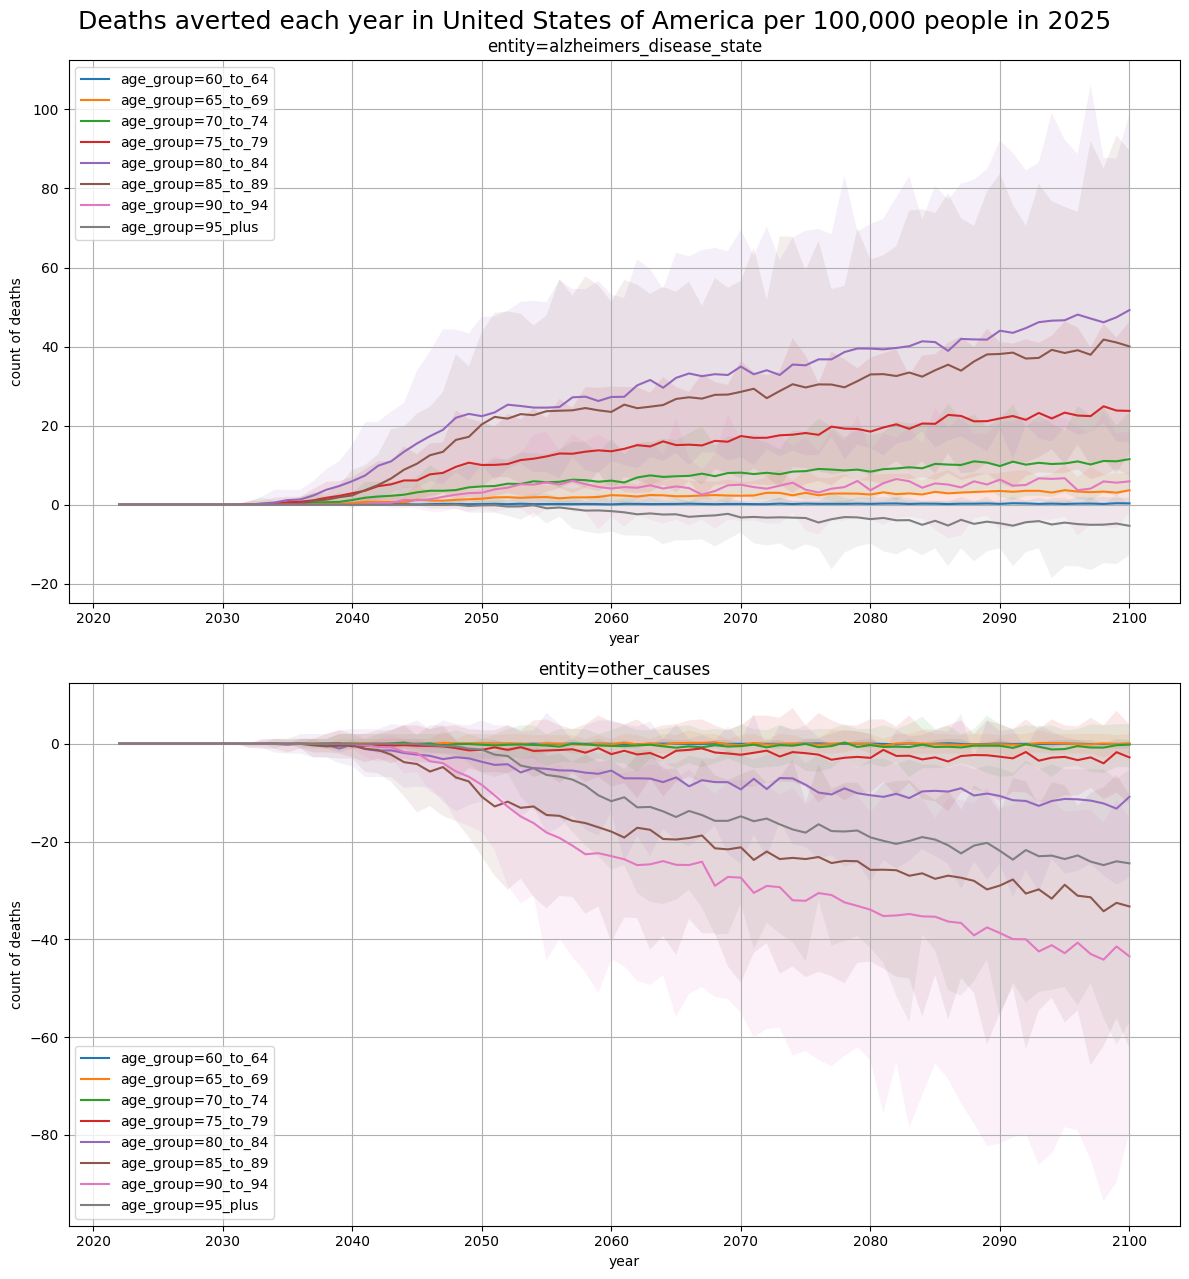

In [134]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="count of deaths",
    suptitle=f"Deaths averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Absolute reductions in AD deaths for all countries

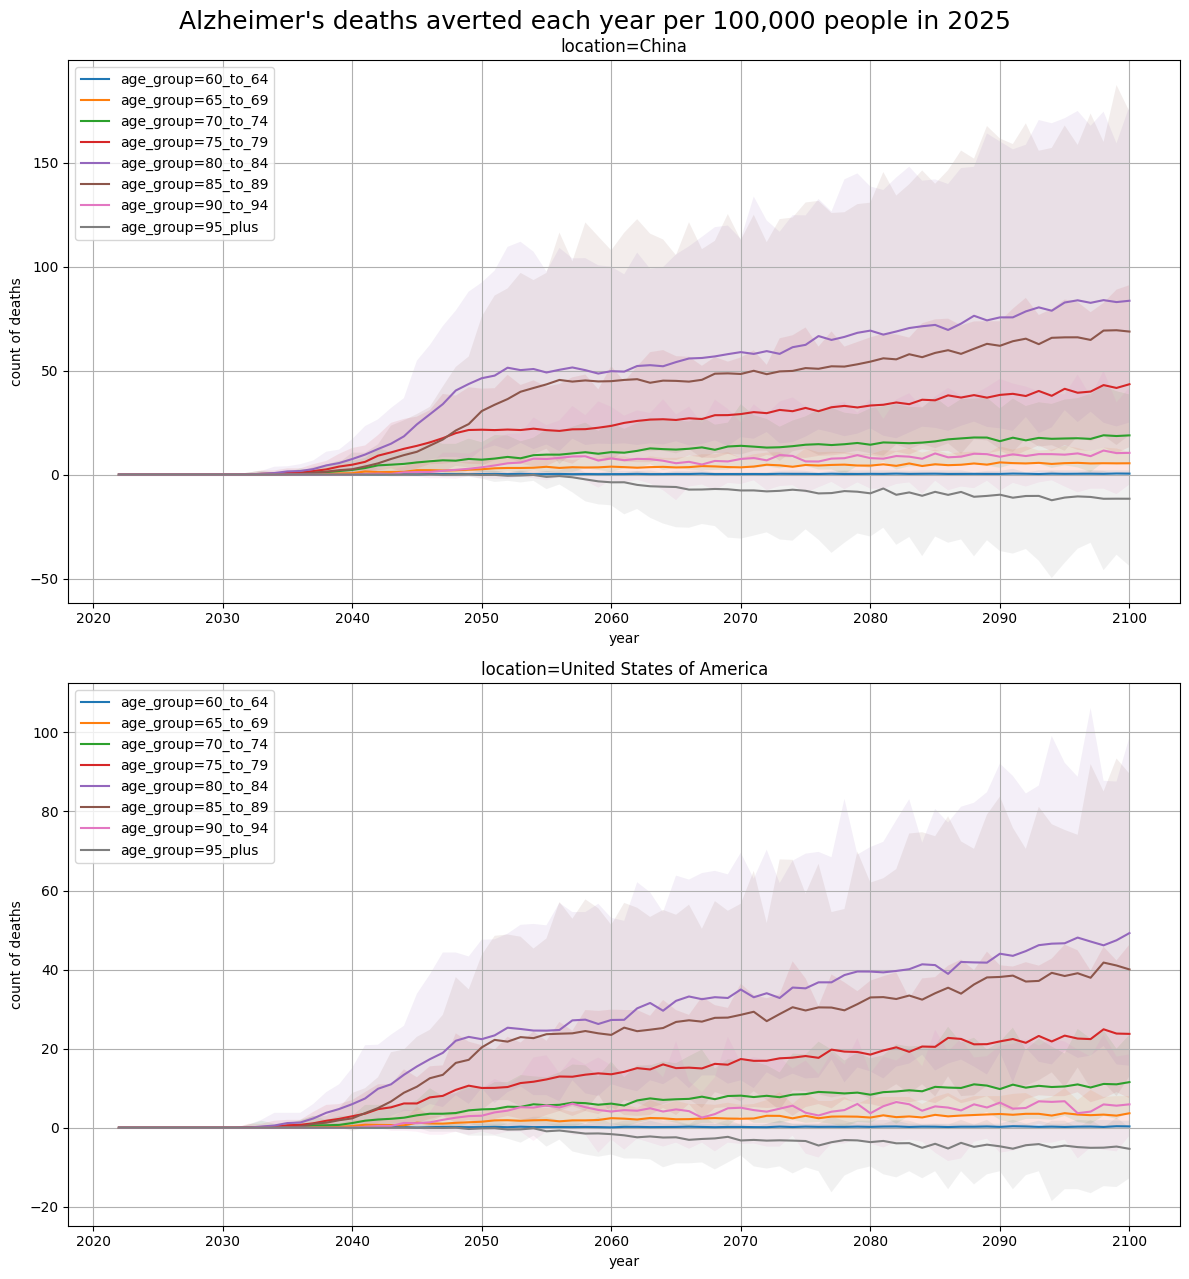

In [135]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="count of deaths",
    suptitle=f"Alzheimer's deaths averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Percent reductions in deaths for all countries

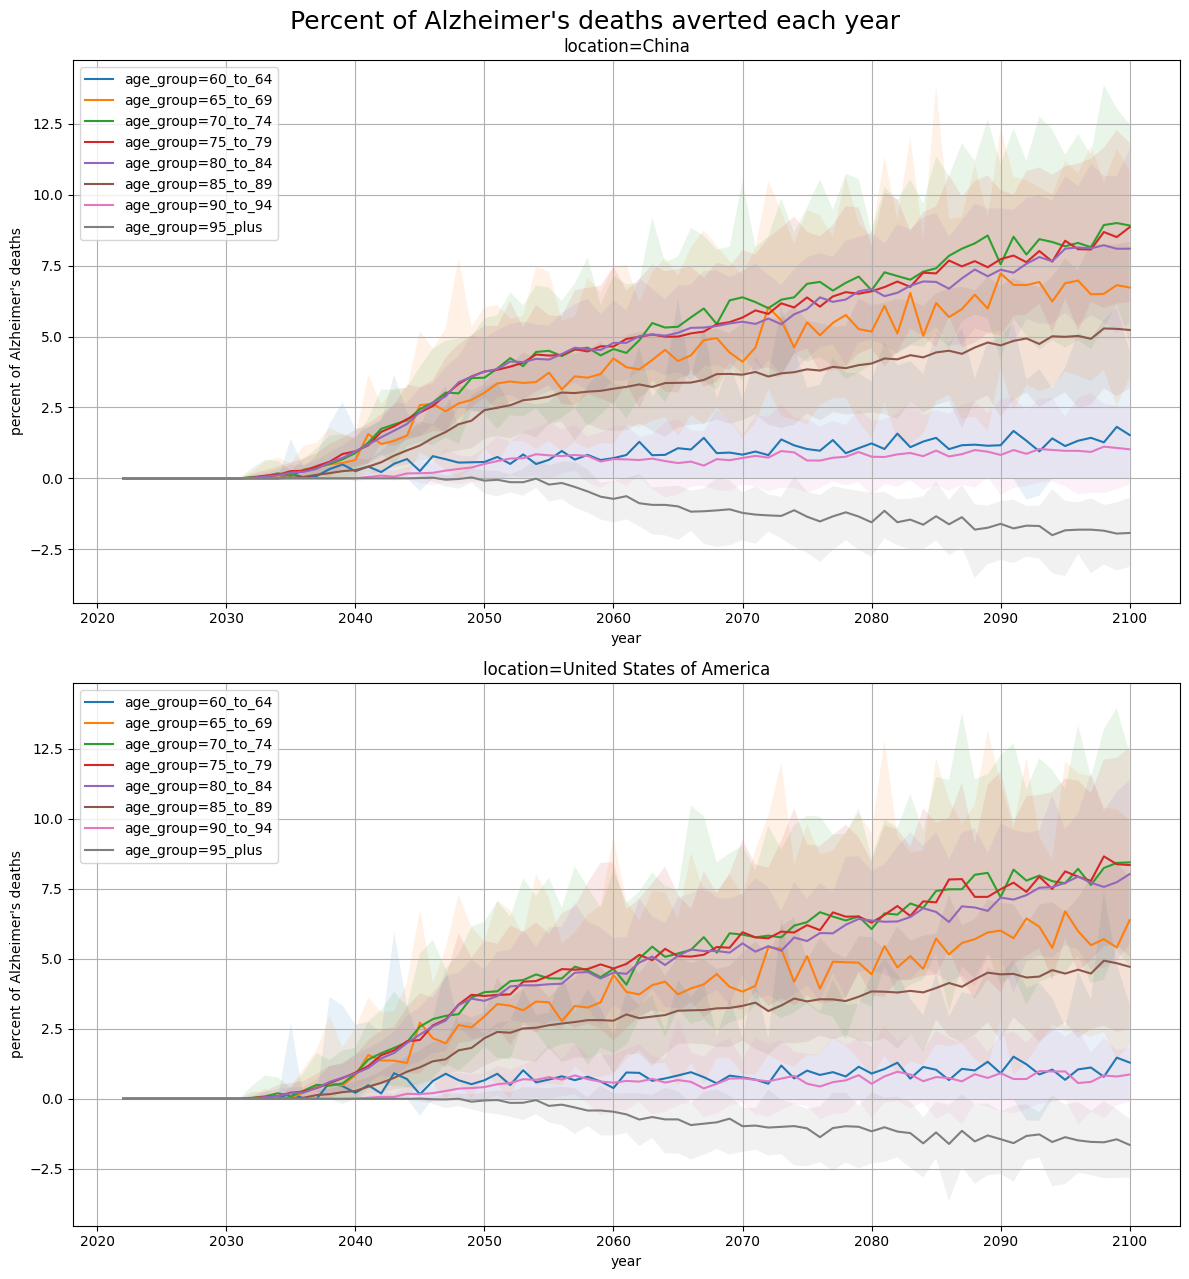

In [136]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_deaths_pct
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="percent of Alzheimer's deaths",
    suptitle=f"Percent of Alzheimer's deaths averted each year"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

# Load YLLs and plot averted YLLs

In [137]:
ylls = load_sim_output('ylls')
print_memory_usage(ylls)
ylls

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])
9.010248 MB


age_group                                      artifact_path  \
0       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4       25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...          ...                                                ...   
473995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
473999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                          entity entity_type  event_year input_draw measure  \
0       alzheimers_disease_state       cause        2022        236    ylls   
1       alzheimers_disease_state       cause        2022        236    ylls   
2       alzheimers_disease_state       cause        2022        236    ylls   
3       alzheimers_disease_state       cause        2022        236    ylls   
4       alzheimers_disease_state       cause        2022        187    ylls   
...                          ...         ...         ...        ...     ...   
473995              other_causes       cause        2100          7    ylls   
473996              other_causes       cause        2100         63    ylls   
473997              other_causes       cause        2100         63    ylls   
473998              other_causes       cause        2100         63    ylls   
473999              other_causes       cause        2100         63    ylls   

                          scenario     sex         value  \
0                         baseline  Female      0.000000   
1                         baseline    Male      0.000000   
2       bbbm_testing_and_treatment  Female      0.000000   
3       bbbm_testing_and_treatment    Male      0.000000   
4                         baseline  Female      0.000000   
...                            ...     ...           ...   
473995  bbbm_testing_and_treatment    Male   2570.689503   
473996                    baseline  Female  24352.428495   
473997                    baseline    Male   2584.946902   
473998  bbbm_testing_and_treatment  Female  25141.375549   
473999  bbbm_testing_and_treatment    Male   2667.550273   

                        location  
0       United States of America  
1       United States of America  
2       United States of America  
3       United States of America  
4       United States of America  
...                          ...  
473995                     China  
473996                     China  
473997                     China  
473998                     China  
473999                     China  

[474000 rows x 11 columns]

In [138]:
averted_ylls = ops.averted(ylls, baseline_scenario='baseline')
print_memory_usage(averted_ylls)

9.010248 MB measure
6.403116 MB minuend
6.403116 MB subtrahend
4.27342 MB minuend re-indexed
4.27342 MB subtrahend re-indexed
4.27348 MB difference
5.929248 MB difference with reset index
6.166573 MB final difference
6.166573 MB


In [139]:
averted_ylls.entity.unique()

['alzheimers_disease_state', 'other_causes']
Categories (2, object): ['alzheimers_disease_state', 'other_causes']

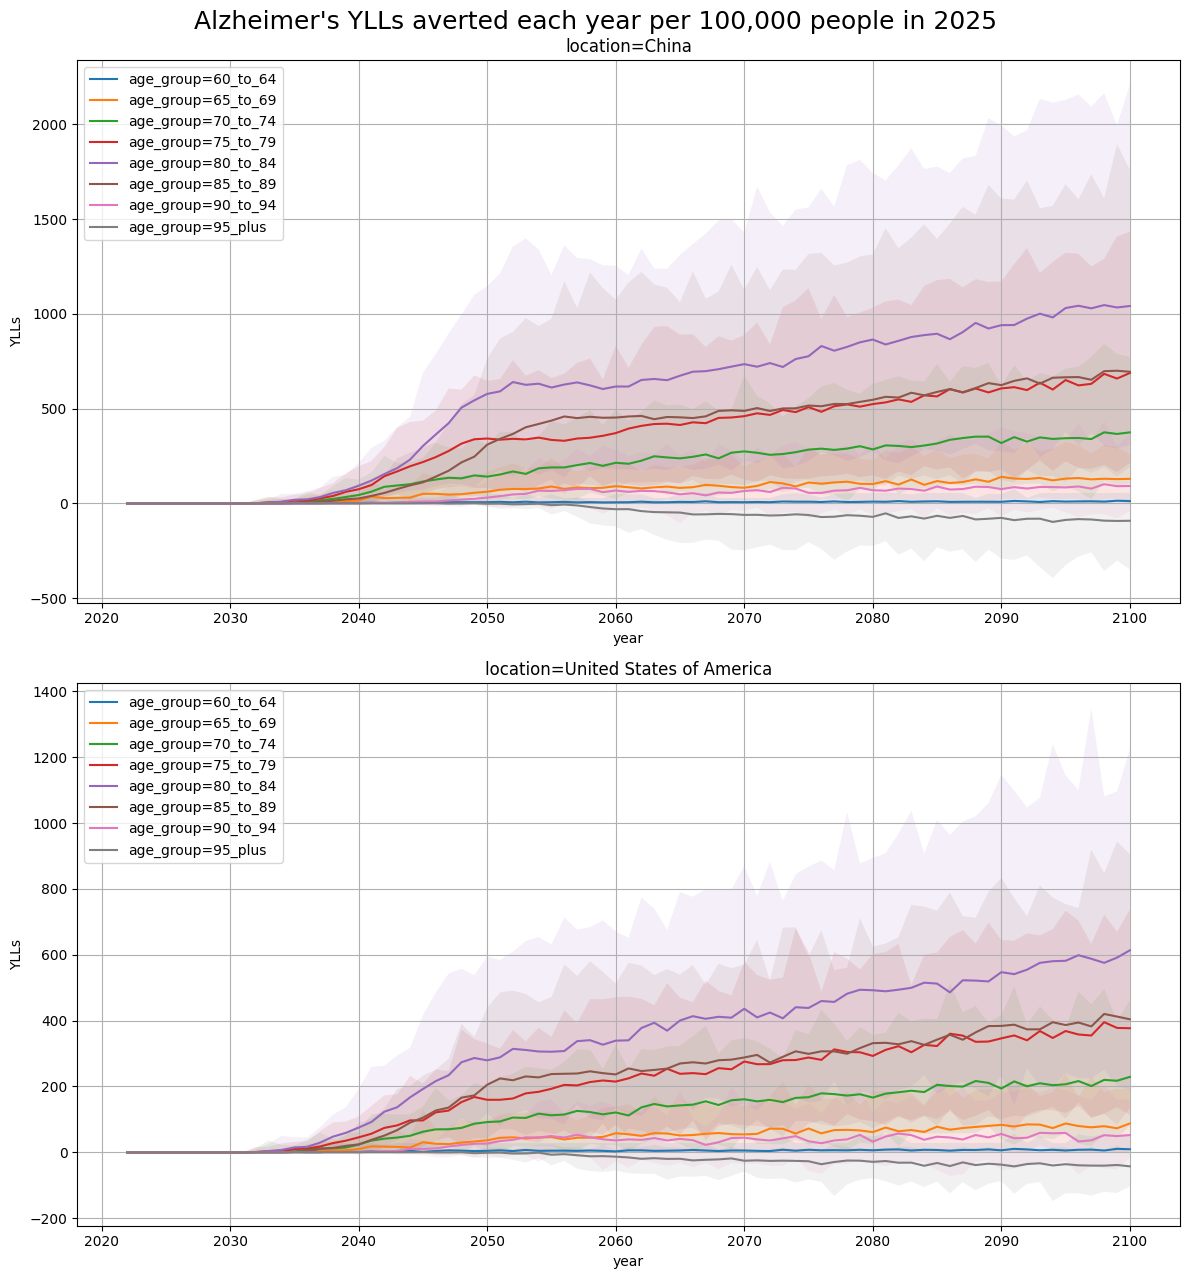

In [140]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_state'"
        ),
    'age_group',
    'location',
    ylabel="YLLs",
    suptitle=f"Alzheimer's YLLs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    ax.grid(True)
plt.show()

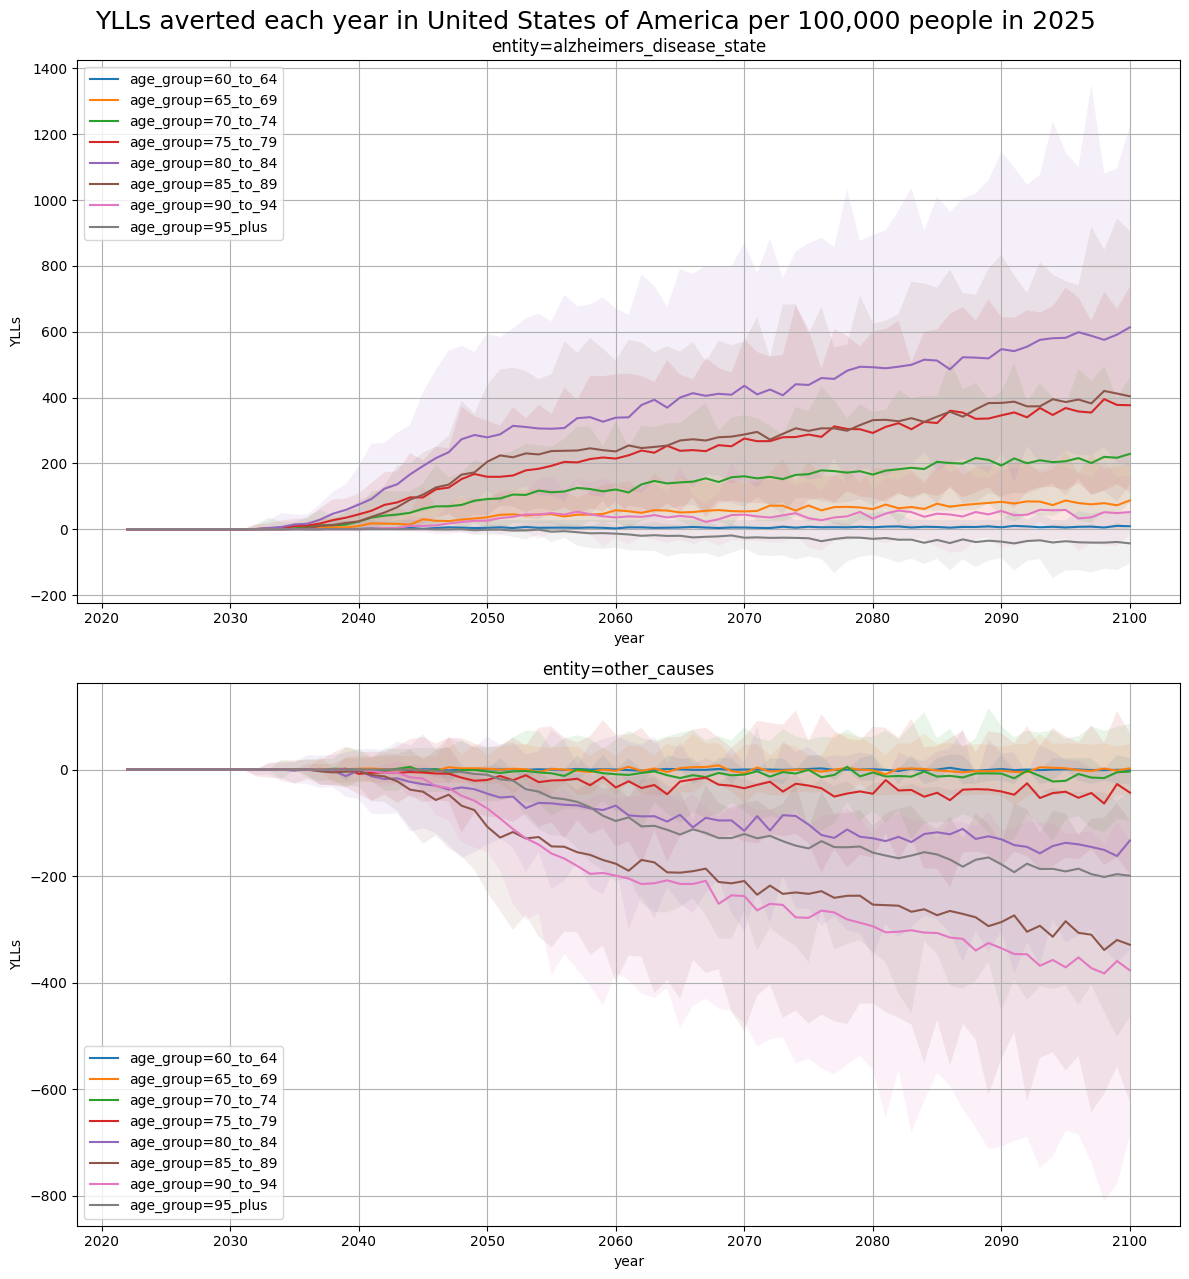

In [141]:
location = locations[0]
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and location==@location"
        ),
    'age_group',
    'entity',
    ylabel="YLLs",
    suptitle=f"YLLs averted each year in {location} per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

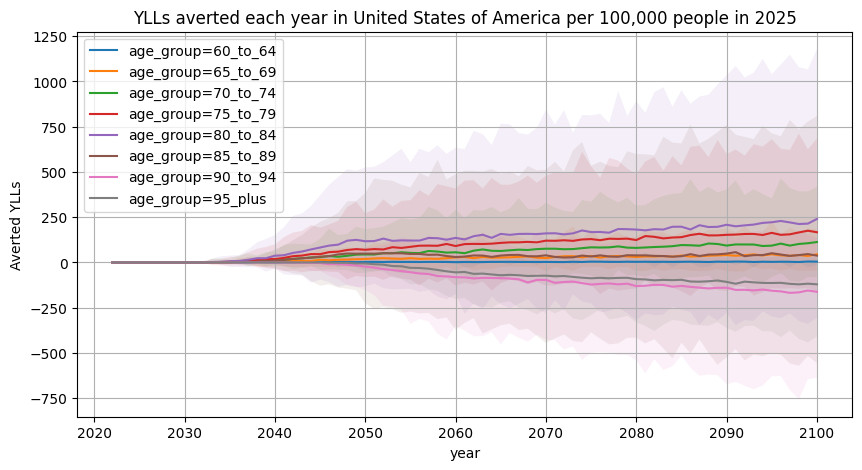

In [142]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plot_over_time_by_column(
    averted_ylls
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment'" #and entity == 'alzheimers_disease_state'"
        f" and location=={locations[0]!r}"
        ),
    'age_group',
    ylabel="Averted YLLs",
    title=f"YLLs averted each year in {locations[0]} per 100,000 people in 2025"
)
# ax.set_xticks(ax.get_xticks()[::10])
ax.grid(True)
plt.show()

# Load YLDs and plot averted YLDs

In [143]:
ylds = load_sim_output('ylds')
print_memory_usage(ylds)
ylds

('artifact_path', 'in', ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/united_states_of_america.hdf', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model8.3/china.hdf'])
42.665351 MB


age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
2132995   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132996   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132997   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132998   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
2132999   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
2132995                              all_causes       cause        2100   
2132996                              all_causes       cause        2100   
2132997                              all_causes       cause        2100   
2132998                              all_causes       cause        2100   
2132999                              all_causes       cause        2100   

        input_draw measure                    scenario     sex  \
0              236    ylds                    baseline  Female   
1              236    ylds                    baseline  Female   
2              236    ylds                    baseline  Female   
3              236    ylds                    baseline    Male   
4              236    ylds                    baseline    Male   
...            ...     ...                         ...     ...   
2132995          7    ylds  bbbm_testing_and_treatment    Male   
2132996         63    ylds                    baseline  Female   
2132997         63    ylds                    baseline    Male   
2132998         63    ylds  bbbm_testing_and_treatment  Female   
2132999         63    ylds  bbbm_testing_and_treatment    Male   

                                         sub_entity        value  \
0            alzheimers_blood_based_biomarker_state     0.000000   
1        alzheimers_mild_cognitive_impairment_state     0.000000   
2                          alzheimers_disease_state     0.000000   
3            alzheimers_blood_based_biomarker_state     0.000000   
4        alzheimers_mild_cognitive_impairment_state     0.000000   
...                                             ...          ...   
2132995                                  all_causes   190.792851   
2132996                                  all_causes  2411.278494   
2132997                                  all_causes   158.568254   
2132998                                  all_causes  2460.648799   
2132999                                  all_causes   161.485191   

                         location  
0        United States of America  
1        United States of America  
2        United States of America  
3        United States of America  
4        United States of America  
...                           ...  
2132995                     China  
2132996                     China  
2132997                     China  
2132998                     China  
2132999                     China  

[2133000 rows x 12 columns]

In [144]:
averted_ylds = ops.averted(ylds, baseline_scenario='baseline')
print_memory_usage(averted_ylds)
# This converts years from int64 to int16
# convert_dtypes(averted_ylds, colname_to_dtype, inplace=True)
averted_ylds = averted_ylds.astype(colname_to_dtype, copy=False)
print_memory_usage(averted_ylds)
# This would convert integer years to Categorical
# convert_to_categorical(averted_ylds, inplace=True)
# print_memory_usage(averted_ylds)

42.665351 MB measure
29.867219 MB minuend
29.867219 MB subtrahend
20.272092 MB minuend re-indexed
20.272092 MB subtrahend re-indexed
20.272152 MB difference
27.734351 MB difference with reset index
28.801176 MB final difference
28.801176 MB
22.402176 MB


In [145]:
1086.443257 / 27.372526

39.69101196579373

In [146]:
averted_ylds.memory_usage(deep=True)

Index                  132
age_group          1068030
artifact_path      1066925
entity             1066836
entity_type        1066670
event_year         2133000
input_draw         1067256
measure            1066669
sex                1066732
sub_entity         1067525
location           1066751
scenario           1066825
subtracted_from    1066825
value              8532000
dtype: int64

In [147]:
averted_ylds.dtypes

age_group          category
artifact_path      category
entity             category
entity_type        category
event_year            int16
input_draw         category
measure            category
sex                category
sub_entity         category
location           category
scenario           category
subtracted_from    category
value               float64
dtype: object

In [148]:
averted_ylds

age_group                                      artifact_path  \
0        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
1        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
2        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
3        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
4        25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1066495   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066496   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066497   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066498   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1066499   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

                                         entity entity_type  event_year  \
0        alzheimers_disease_and_other_dementias       cause        2022   
1        alzheimers_disease_and_other_dementias       cause        2022   
2        alzheimers_disease_and_other_dementias       cause        2022   
3        alzheimers_disease_and_other_dementias       cause        2022   
4        alzheimers_disease_and_other_dementias       cause        2022   
...                                         ...         ...         ...   
1066495                              all_causes       cause        2100   
1066496                              all_causes       cause        2100   
1066497                              all_causes       cause        2100   
1066498                              all_causes       cause        2100   
1066499                              all_causes       cause        2100   

        input_draw measure     sex  \
0              236    ylds  Female   
1              236    ylds  Female   
2              236    ylds  Female   
3              236    ylds    Male   
4              236    ylds    Male   
...            ...     ...     ...   
1066495        183    ylds    Male   
1066496          7    ylds  Female   
1066497          7    ylds    Male   
1066498         63    ylds  Female   
1066499         63    ylds    Male   

                                         sub_entity                  location  \
0            alzheimers_blood_based_biomarker_state  United States of America   
1        alzheimers_mild_cognitive_impairment_state  United States of America   
2                          alzheimers_disease_state  United States of America   
3            alzheimers_blood_based_biomarker_state  United States of America   
4        alzheimers_mild_cognitive_impairment_state  United States of America   
...                                             ...                       ...   
1066495                                  all_causes                     China   
1066496                                  all_causes                     China   
1066497                                  all_causes                     China   
1066498                                  all_causes                     China   
1066499                                  all_causes                     China   

                           scenario subtracted_from      value  
0        bbbm_testing_and_treatment        baseline   0.000000  
1        bbbm_testing_and_treatment        baseline   0.000000  
2        bbbm_testing_and_treatment        baseline   0.000000  
3        bbbm_testing_and_treatment        baseline   0.000000  
4        bbbm_testing_and_treatment        baseline   0.000000  
...                             ...             ...        ...  
1066495  bbbm_testing_and_treatment        baseline  -2.725556  
1066496  bbbm_testing_and_treatment        baseline -69.776557  
1066497  bbbm_testing_and_treatment        baseline  -3.110227  
1066498  bbbm_testing_and_treatment        baseline -49.370305  
1066499  bbbm_testing_and_treatment        baseline  -2.916937  

[1066500 rows x 13 columns]

In [149]:
averted_ylds.entity.unique()

['alzheimers_disease_and_other_dementias', 'treatment', 'all_causes']
Categories (3, object): ['all_causes', 'alzheimers_disease_and_other_dementias', 'treatment']

In [150]:
# All values are 0 in this sub-dataframe
averted_ylds.query("entity=='treatment'")

age_group                                      artifact_path  \
11850    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11851    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11852    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11853    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
11854    25_to_29  /mnt/team/simulation_science/pub/models/vivari...   
...           ...                                                ...   
1062545   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1062546   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1062547   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1062548   95_plus  /mnt/team/simulation_science/pub/models/vivari...   
1062549   95_plus  /mnt/team/simulation_science/pub/models/vivari...   

            entity entity_type  event_year input_draw measure     sex  \
11850    treatment       cause        2022        236    ylds  Female   
11851    treatment       cause        2022        236    ylds  Female   
11852    treatment       cause        2022        236    ylds  Female   
11853    treatment       cause        2022        236    ylds  Female   
11854    treatment       cause        2022        236    ylds  Female   
...            ...         ...         ...        ...     ...     ...   
1062545  treatment       cause        2100         63    ylds    Male   
1062546  treatment       cause        2100         63    ylds    Male   
1062547  treatment       cause        2100         63    ylds    Male   
1062548  treatment       cause        2100         63    ylds    Male   
1062549  treatment       cause        2100         63    ylds    Male   

                        sub_entity                  location  \
11850        waiting_for_treatment  United States of America   
11851             treatment_effect  United States of America   
11852                waning_effect  United States of America   
11853    no_effect_after_treatment  United States of America   
11854      no_effect_never_treated  United States of America   
...                            ...                       ...   
1062545      waiting_for_treatment                     China   
1062546           treatment_effect                     China   
1062547              waning_effect                     China   
1062548  no_effect_after_treatment                     China   
1062549    no_effect_never_treated                     China   

                           scenario subtracted_from  value  
11850    bbbm_testing_and_treatment        baseline    0.0  
11851    bbbm_testing_and_treatment        baseline    0.0  
11852    bbbm_testing_and_treatment        baseline    0.0  
11853    bbbm_testing_and_treatment        baseline    0.0  
11854    bbbm_testing_and_treatment        baseline    0.0  
...                             ...             ...    ...  
1062545  bbbm_testing_and_treatment        baseline    0.0  
1062546  bbbm_testing_and_treatment        baseline    0.0  
1062547  bbbm_testing_and_treatment        baseline    0.0  
1062548  bbbm_testing_and_treatment        baseline    0.0  
1062549  bbbm_testing_and_treatment        baseline    0.0  

[592500 rows x 13 columns]

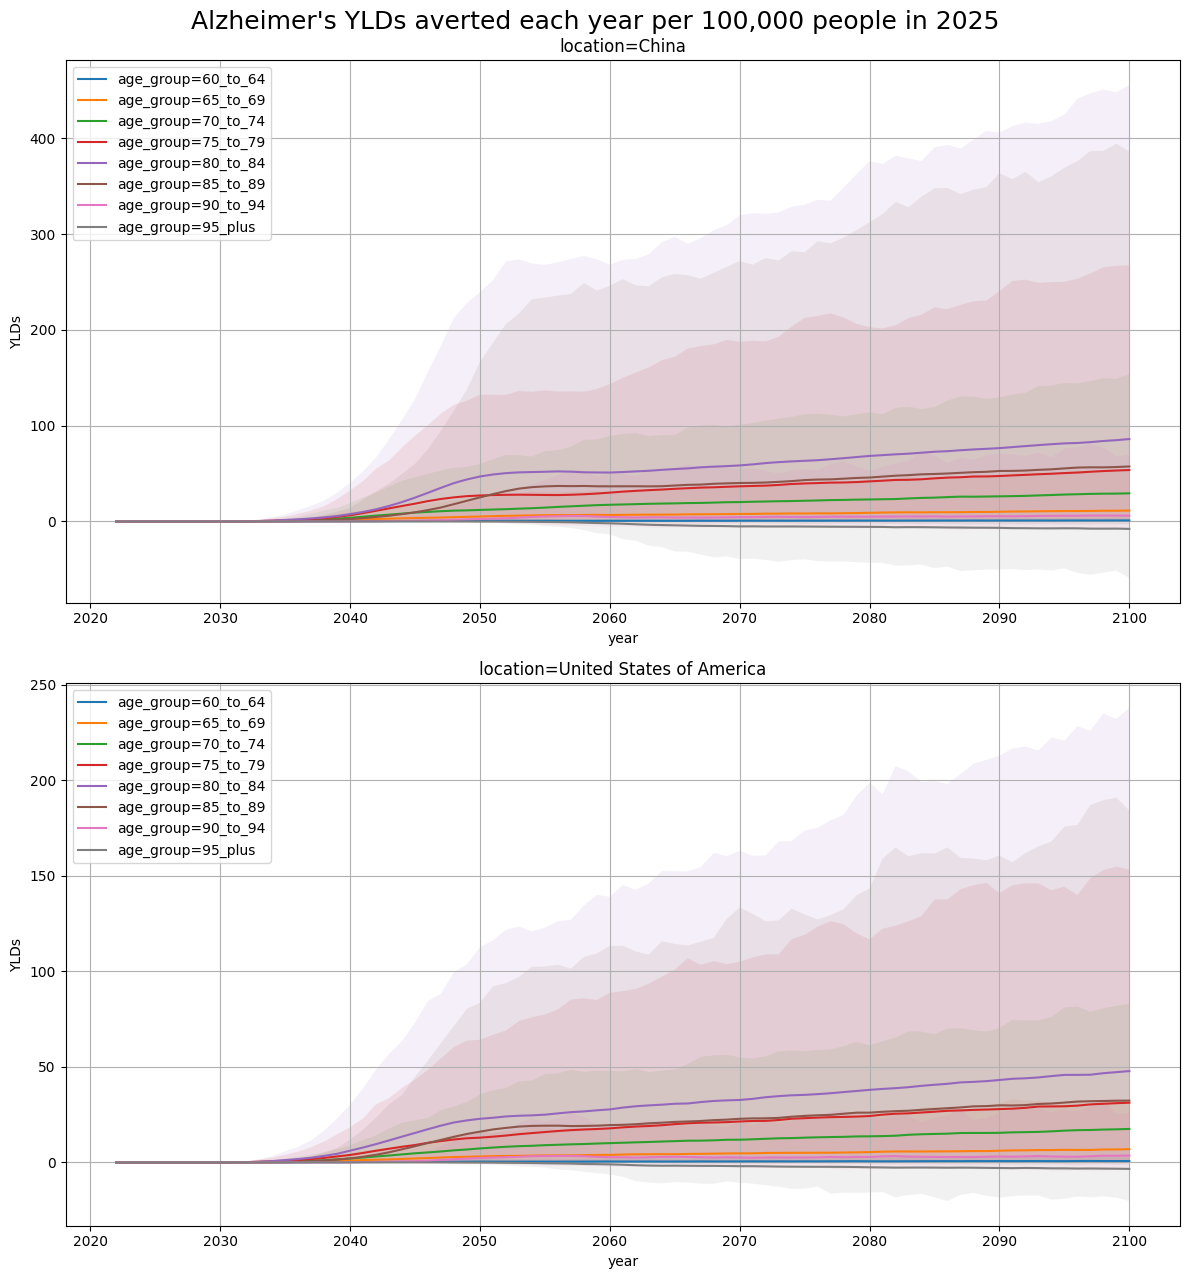

In [151]:
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'alzheimers_disease_and_other_dementias'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"Alzheimer's YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

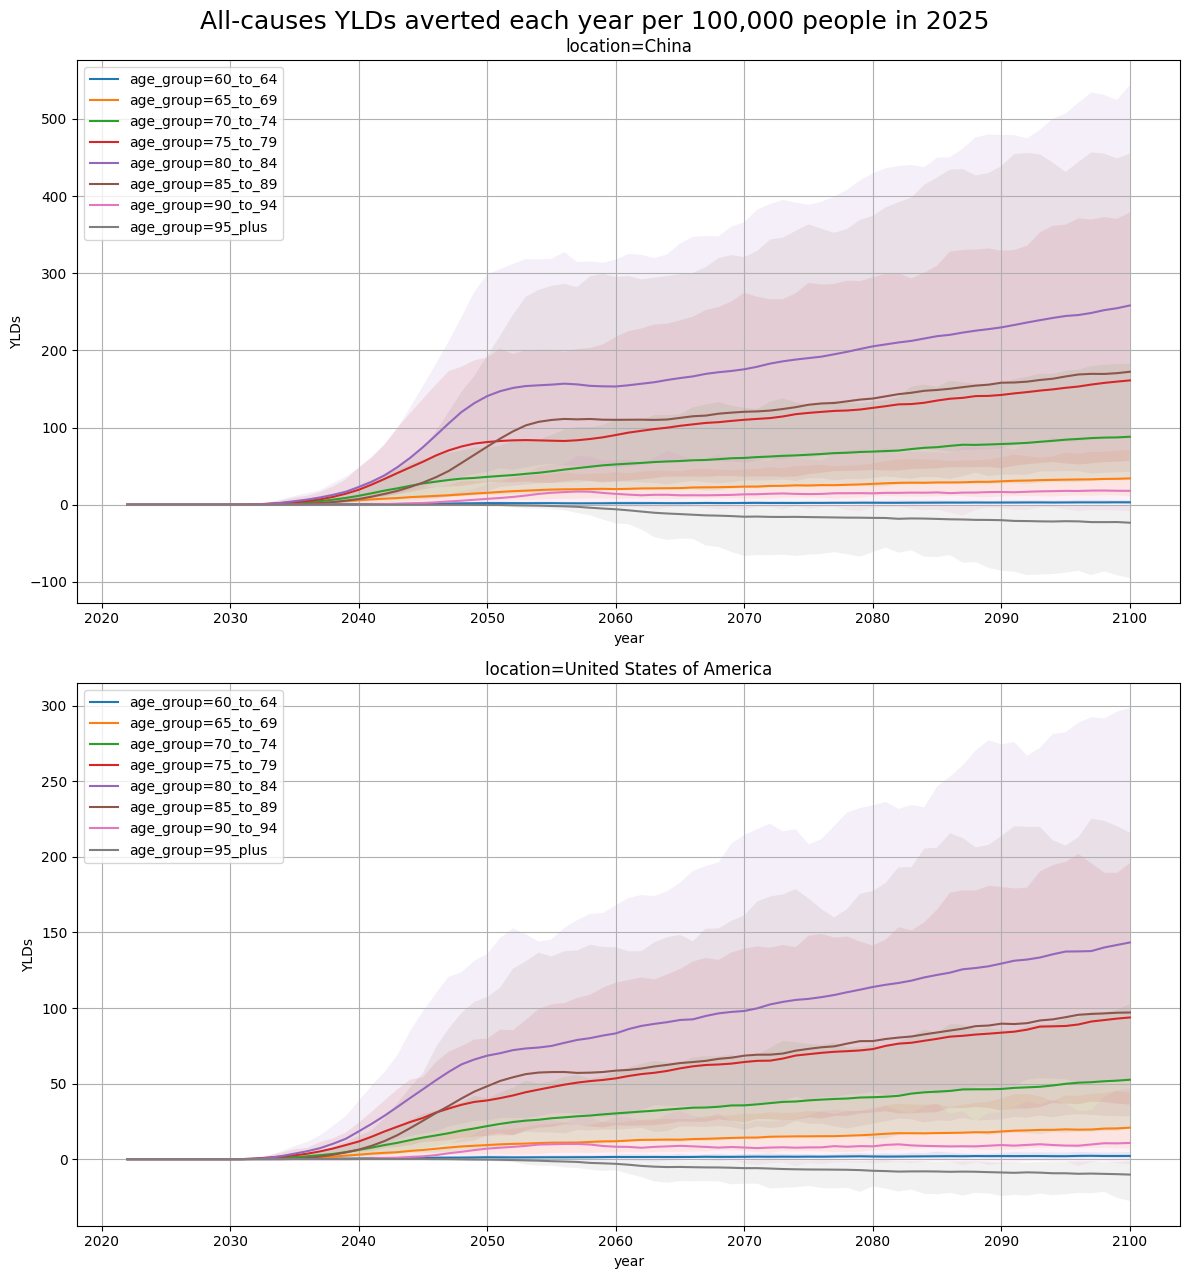

In [152]:
# I'm not sure why total YLDs averted is greater than Alzheimer's YLDs
# averted...
fig = plot_over_time_by_column_for_row_x_1(
    averted_ylds
    .astype({"age_group": 'str'})
    .query(
        "age_group >= '60_to_64' and "
        "scenario == 'bbbm_testing_and_treatment' and entity == 'all_causes'"
        ),
    'age_group',
    'location',
    ylabel="YLDs",
    suptitle=f"All-causes YLDs averted each year per 100,000 people in 2025"
)
for ax in fig.axes:
    # ax.set_xticks(ax.get_xticks()[::10])
    ax.grid(True)
plt.show()

In [153]:
# Print current time to easily check if notebook ran all the way through
# vs. hitting an error somewhere above
import datetime
print(datetime.datetime.now())

2026-01-29 23:42:26.291768
